# App Identification

Investagation 


IMPORTANT: Make sure the data are cached by running cache.py with the path in argument (#TODO)  

<a id='tc'></a>
## Table of content 

**PART I** - Introduction and setup 

0. [Introduction](#intro)
1. [Setup](#setup)
    1. [Imports](#imports)
    2. [helpers](#helpers)
    3. [evaluation function](#evaluation)
    

**PART II** - [model evaluation and Performance](#model_eval_perf)

1. [Banned App](#banned_app)
2. [Dataset size investigation](#dataset_size)
3. [Huawei](#huawei)
4. [Fossil](#fossil_eval)
5. [Apple Watch](#apple_watch)
5. [Action](#actions)
    1. [Foursquare city guide](#Foursquarecityguide)
    2. [DiabetesM](#DiabetesM)
    3. [Endomondo](#Endomondo)
    4. [Lifesum](#lifesum)
    5. [All action within apps](#all_action_within_apps)
6. [All apps and action together](#all)

**PART IV** - [Transferability](#transferability)
 
1. [Train and test with both watches](#huawei_fossil_train_test)
2. [Train and test with both watches with class separation](#huawei_fossil_train_test_class_separation)
3. [Training and testing with different watch respectively](#train_test_different_watch)
    1. [Train with Huawei test with Fossil](#thtf)
    2. [Train with Fossil test with Huawei](#tfth)
4. [Capacity and Transferability](#capa_tr)
    1. [Decrease Number of Features](#decrease_nb_features)
    2. [Increase Model Complexity](#increase_complexity)

**PART IV** - [Impact on time](#acc_time)
8. Separation of dataset by the date at which the capture has been performed

**OTHER** - 
9. [Tranferability apple-huawei](#apple-huawei)




6. Outliers Detections


## PART I - Introduction and Setup

<a id='intro'></a>
## Introduction
Datasets: Automated Captures 

Classes: Apps are chosen from different metric based on:
    - confidentiallity: what an attacker would gain by knowing which apps a victim is using.
    - popularity: Based on famous reviews ore 
    - nativity: If the application is by default installed on the application

<a id='setup'></a>
## 1. Setup

<a id='imports'></a>
### imports

In [1073]:
import pandas as pd
import numpy as np
import sys
import time
import random
from build_datasets import *
import csv
import os
import pickle
from copy import deepcopy
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import kurtosis
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn.utils import shuffle


<a id='helpers'></a>
### Helpers Functions
[Table of content](#tc)

In [1164]:
def merge_actions(events, to_merge, names=None):
    if not names: 
        names = [None] * len(to_merge)
    for actions, name in zip(to_merge, names):
        events = merge_action(events, actions, name)
    return events


def merge_action(events, to_merge, name=None, EQUALIZATION=True):
    """
    Merge actions in to_merge from events.
    Args:
        name : Tuple(AppName, ActionName). Name of the merged Application and Action
        events: dict
        to_merge : [app_action,]. Action to merge
        
    Cannot merge across apps
    """
    
    # prepare if Equalization is needed
    if EQUALIZATION:
        events, _ = equilibrate_events_across_apps_and_watch(events, SELECTIVE_ACTION=to_merge)
    
    events_out = deepcopy(events)

    for w in events:
        merged_actions = []
        app_merged = "NoApp"
        action_merged = ""
        
        for app in events[w]:
            for action in events[w][app]:
                if app+'_'+action in to_merge:
                    action_merged += action[:5].capitalize()
                    merged_actions += events[w][app][action]
                    del events_out[w][app][action]
        if name:
            app_merged = name.split("_")[0]
            action_merged = name.split("_")[1]
        if app_merged not in events_out[w]:
            events_out[w][app_merged] = dict()
        if action_merged not in events_out[w]:
            events_out[w][app_merged][action_merged] = dict()
        events_out[w][app_merged][action_merged] = merged_actions
        
    return events_out 
    


def discard_actions(source_files, to_discard):
    sf_new = []
    for f in source_files:
        _in = False
        for df in to_discard:
            if df in f:
                _in = True
        if not _in:
            sf_new.append(f)
    return sf_new



def separate_watch(events):
    """Separate events across datat"""
    
    if len(events.keys()) <= 1:
        print("Only 1 watch. Cannot separate")
        return events
    events_out = dict()
    
    all_devices = "-".join([device for device in events])
    events_out[all_devices] = dict()
    
    # dict init 
    for device in events:
        for app in events[device]:
            for action in events[device][app]:
                    
                if not app in events_out[all_devices]:
                    events_out[all_devices][device+"_"+app] = dict()
                if not action in events_out[all_devices][device+"_"+app]:
                    events_out[all_devices][device+"_"+app][action] = events[device][app][action]
    return events_out


def delete_different_action_across_watch(events):
        # Create common action set if multiple watches
    intersection_set = set()
    for i, w in enumerate(events):
        all_action = []
        for app in events[w]:
            actions = set(events[w][app].keys())
            all_action += [app + "_" + act for act in actions]
        if i == 0:
            intersection_set = set(all_action)
        else:
            intersection_set = intersection_set.intersection(set(all_action))
    
    events_copy = deepcopy(events)
    # Delete not common action from dictionnary
    for device in events_copy:
        for app in events_copy[device]:
            for action in events_copy[device][app]:
                if app + "_" + action not in intersection_set:
                    del events[device][app][action]
    return events



def create_sub_dataset(datasets, N_TO_PICK = -1, AppToKeepOnly="all"):
    datasets_to_analysis = []
    labels_to_analysis = []

    for watch in datasets:
        for app in datasets[watch]:
            if AppToKeepOnly != "all" and app not in AppToKeepOnly:
                continue
            for action in datasets[watch][app]:
                label= WATCH_NAME +"_"+app+"_"+action


                events = datasets[watch][app][action]
                chosen_events = []
                if type(datasets[watch][app][action]) is dict:
                    events = list(events.keys())

                if N_TO_PICK == -1 or len(events) < N_TO_PICK:
                    chosen_events = random.sample(events, len(events_nb))
                    if N_TO_PICK != -1:
                        print("N_TO_PICK too large. Took all the dataset for " + app + "_" + action ," instead")
                    chosen_events = random.sample(events, N_TO_PICK)

                if type(datasets[watch][app][action]) is dict:
                    labels_to_analysis += [label + "_" + nb for nb in chosen_events]
                    datasets_to_analysis += [datasets[watch][app][action][event_nb] for event_nb in chosen_events]
                else:
                    labels_to_analysis += [label for nb in chosen_events]
                    datasets_to_analysis += events

    return datasets_to_analysis, labels_to_analysis


def filter_by_length(events, minimum_payload=200, ratio_app_not_satisfing_minimum_payload_length=0.25, printInfo = False):
    results = deepcopy(events)
    for watch in events:
        for app in events[watch]:
            for action in events[watch][app]:
                total_event = len(events[watch][app][action])
                bellow_minimum_payload = 0
                for sample in events[watch][app][action]:

                    payload_length = sum([abs(s) for s in sample["ys"]])
                    if payload_length < minimum_payload:
                        bellow_minimum_payload += 1

                ratio_bellow = bellow_minimum_payload / total_event
                if ratio_bellow > ratio_app_not_satisfing_minimum_payload_length:
                    if printInfo:
                        print("total_event: ", total_event, " - bellow threshold: ", bellow_minimum_payload)
                        print(app + "_" + action + " removed")
                        print(" ratio_below = ", ratio_bellow)
                    del results[watch][app][action]

            if len(results[watch][app]) == 0:
                del results[watch][app]
    return results


def filer_by_data_size(events, N_TO_PICK):
    
    results = deepcopy(events)
    for watch in events:
        for app in events[watch]:
            for action in events[watch][app]:
                if len(events[watch][app][action]) < N_TO_PICK or N_TO_PICK == -1:
                    if N_TO_PICK != -1:
                        print("N_TO_PICK too large. Took all the dataset for " + app + "_" + action ," instead")
                    continue
                else:
                    chosen_indices = random.sample(range(len(events[watch][app][action])), N_TO_PICK)
                    chosen_events = list(np.array(events[watch][app][action])[chosen_indices])
                results[watch][app][action] = chosen_events
    return results




def plot_confusion_matrix(y_true, y_pred, normalize=True,
                          title=True, figname = None,
                          figsize=(20,20), PLOT_DIR="./plots/", 
                          ORDERED_LABELS=None, CM_NO_LABELS=False, 
                          CM_ALL_LABEL=False,
                          APP_TO_INDEX=False, SPACING=2):
    cm, fig, ax = None, None, None
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=ORDERED_LABELS)
    
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if ORDERED_LABELS:
        classes = ORDERED_LABELS
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if CM_ALL_LABEL:  
        fig, ax = plt.subplots(figsize=figsize, dpi= 180)
        ax.imshow(cm, interpolation='none', aspect='auto', cmap=plt.cm.Blues)

        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

        ax.set(xticks=np.arange(cm.shape[1]),
            yticks=np.arange(cm.shape[0]),
            # ... and label them with the respective list entries
            xticklabels=classes, yticklabels=classes,
            title=title,
            ylabel='True label',
            xlabel='Predicted label')

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")

        # Rotate the tick labels and set their alignment.
        #plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
        #         rotation_mode="anchor")

        if figname is not None:
            plt.savefig(PLOT_DIR+figname)
            print("Saved image", PLOT_DIR+figname+".png")

    if CM_NO_LABELS:   
        fig, ax = plt.subplots(figsize=figsize, dpi= 180)
        ax.imshow(cm, interpolation='none', aspect='auto', cmap=plt.cm.Blues)
        ax.tick_params(axis="both", which='both', bottom=False, top=False, labelbottom=False)
        plt.yticks([])
        if figname is not None:
            plt.savefig(PLOT_DIR+figname+"_nolabels")
            print("Saved image", PLOT_DIR+figname+"_nolabels.png")
            
    if APP_TO_INDEX:
        fig, ax = plt.subplots(figsize=figsize, dpi= 180)
        index_labels = [APP_TO_INDEX[l] for i, l in enumerate(classes) if i % SPACING == 0]
        im = ax.imshow(cm, interpolation='none', aspect='auto', cmap=plt.cm.Blues)
        #fig.colorbar(im, ax=ax)
        divider = make_axes_locatable(ax)

        ax.set(xticks=np.arange(cm.shape[1]//SPACING) * SPACING,
               yticks=np.arange(cm.shape[0]//SPACING) * SPACING,
               xticklabels=index_labels, yticklabels=index_labels)
        
        cax = divider.append_axes("right", size="3%", pad=0.05)
        cb = plt.colorbar(im, cax=cax)
        cb.ax.tick_params(labelsize=figsize[0] * 1.2)
        ax.set_xlabel(xlabel='Predicted label index', labelpad=20, fontsize=figsize[0] * 1.5)
        ax.set_ylabel(ylabel='True label index', labelpad=20, fontsize=figsize[0] * 1.5)
        ax.tick_params(labelsize=figsize[0] * 1.2)
        ax.set_title(title, fontsize=figsize[0] * 2)
        if figname is not None:
            plt.savefig(PLOT_DIR+figname+"_index", bbox_inches='tight')
            print("Saved image", PLOT_DIR+figname+"_index.png")
    return cm, fig, ax


def count_print(events):
    nb_categories = 0
    for d in events:
        for app in events[d]:
            nb_categories += len(events[d][app])
            for act in events[d][app]:
                print("{}: {}_{} - {}".format(d, app, act,  len(events[d][app][act])))
    print("Nb class = ", nb_categories)
    
    
def get_all_actions(events):
    all_actions = set()
    for d in events:
        for app in events[d]:
            for act in events[d][app]:
                all_actions.add(app+"_"+act)
    return all_actions
    

                
def plot_acc_and_conf(steps, accuracies, confs, repeat,
                      title=None, xlabel=None, ylabel=None, fname=None, y_lim=None, dpi=500):
    
    accuracies = np.array(accuracies)
    confs = np.array(confs)
    
    accuracies_avg = accuracies.reshape((-1,repeat)).mean(axis = 1)
    confs_avg = confs.reshape((-1,repeat)).mean(axis = 1)
    
    conf_upper = accuracies_avg + confs_avg
    conf_lower = accuracies_avg - confs_avg
    
    fig, ax = plt.subplots()
    ax.plot(steps, accuracies_avg, '-b', label='averaged accuracy')
    ax.plot(steps, conf_upper, '--r', label='95% confidence interval')
    ax.plot(steps, conf_lower, '--r')
    plt.title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if y_lim is not None:
        plt.ylim(y_lim[0], y_lim[1])
    leg = ax.legend()
    
    plt.savefig("./"+fname, dpi=dpi)
    
    
    
def feat_filter(X, f_name, to_withdraw):
    """
    Withdraw features specified in to withdraw
    Args: 
        X: [[X1_f1,],] dataset
        f_name : [f1,] feature names
        to_withdraw: [i1,] index of features to withdraw
    Return:
        X_new, f_name_new : Args filtered
    """
    X, f_name, to_withdraw = np.array(X), np.array(f_name), np.array(to_withdraw)
    mask = np.ones(len(f_name), np.bool)
    mask[to_withdraw] = 0
    return X[:,mask].tolist(), f_name[mask].tolist()

def build_app_to_index_dict(apple_only=False):
    
    c = 0
    if apple_only:
        c=72
    app_to_index = dict()
    def fill_dict(events, c):
        for device in events:
            for app in events[device]:
                for action in events[device][app]:
                    c+=1
                    label = app+"_"+action
                    if label in app_to_index:
                        label += "_"+device
                    app_to_index[label] = c
        return c
    
    if not apple_only:
        DATA_PATH = "data/huawei/open-3/"
        DISCARDED_ACTION = ["NoApp_NoAction"]
        events = evaluate(DATA_PATH, DISCARDED_ACTION=DISCARDED_ACTION, RETURN_EVENTS=True)
        c = fill_dict(events, c)

        DATA_PATH = ["data/huawei/Endomondo-1/", "data/huawei/DiabetesM-2/",
                     "data/huawei/FoursquareCityGuide-1/", "data/huawei/HealthyRecipes-1/",
                     "data/huawei/Lifesum-1/", "data/huawei/Playstore-1/"]
        events = evaluate(DATA_PATH, RETURN_EVENTS=True)    
        c = fill_dict(events, c)
    
    DATA_PATH = ["data/iwatch/batch-1/"]
    events = evaluate(DATA_PATH, RETURN_EVENTS=True)
    c = fill_dict(events, c)
    
    
    return app_to_index


<a id='evaluation'></a>
### Evaluation function
[Table of content](#tc)

In [1075]:
def time_serie_filtering(events, packet_min_length= 0, n_same_consecutive_packet_length=None):
    l_min = 999999999
    i_min =-1
    events_new = deepcopy(events)
    for w in events:
        for app in events[w]:
            for action in events[w][app]:
                new_event_list = []
                for event in events[w][app][action]:
                    xs = np.array(event['xs'])
                    ys = np.array(event['ys'])
                    xs = xs[np.argwhere(abs(ys)  >= packet_min_length)]
                    ys = ys[np.argwhere(abs(ys)  >= packet_min_length)]
                    d = dict()
                    d['xs'] = xs.flatten().tolist()
                    d['ys'] = ys.flatten().tolist()
                    new_event_list.append(d)
                events_new[w][app][action] = new_event_list
    return events_new

In [1076]:
def median_length_order(events):    
    n_and_s = []
    l_min = 999999999
    i_min =-1
    for w in events:
        for app in events[w]:
            for action in events[w][app]:
                name = app + "_" + action
                sizes = []
                for i, event in enumerate(events[w][app][action]):
                    ys = np.array(event["ys"])
                    sizes.append(sum(abs(ys)))
                n_and_s.append((name, np.median(sizes))) 
    n_and_s = sorted(n_and_s, key = lambda x : x[1])
    n_sorted = [n for n,s in n_and_s]
    s_sorted = [s for n,s in n_and_s]
    return n_sorted, s_sorted


def equilibrate_events_across_apps_and_watch(events, SELECTIVE_ACTION=None, equilibrate_events_across_apps_and_watch=None):
    """
    Equilibrate the events by identifing the minimum number of samples per class
    and discarding Randomly the extra samples.
    If there are multiple watchs, only the common application are kept

    Parameters: 
        events (dict[watch][app][action] -> event): dataset 
        SELECTIVE_ACTION ["app_action",] : only equalized on selective events

    Returns: 
        events (dict[watch][app][action] -> event): equilibrate dataset
    """
    
    events = delete_different_action_across_watch(events)
    
    # Find minimum samples 
    counts = dict()
    for device in events:
        for app in events[device]:
            for action in events[device][app]:
                counts[device + "_" + app +"_" + action] = 0
            for action in events[device][app]:
                counts[device + "_" + app + "_" + action] += len(events[device][app][action])
                
    if len(counts.values())== 0:
        return events, -1


    nb_samples_per_cat = min(counts.values())
    if SELECTIVE_ACTION:
        nb_samples_per_cat = nb_samples_per_cat // len(SELECTIVE_ACTION) + 1

    events_out = dict()

    # remove everything above the min across devices
    for device in events:
        for app in events[device]:

            for action in events[device][app]:

                if not device in events_out:
                    events_out[device] = dict()
                if not app in events_out[device]:
                    events_out[device][app] = dict()
                if not action in events_out[device][app]:
                    if not SELECTIVE_ACTION or app + "_" + action in SELECTIVE_ACTION:
                        events_out[device][app][action] = random.sample(events[device][app][action], k=nb_samples_per_cat)
                    else:
                        events_out[device][app][action] = events[device][app][action]
                        
    return events_out, nb_samples_per_cat



In [1352]:
def build_features_labels_dataset(events, adversary_capture_duration=-1, unique_from=46, unique_to=1006, 
                                  unique_granularity=1, unique_deltas=[0,46], to_withdraw=[]):
    data = []
    labels = []
    feature_names = None 
    for device in events:
        for app in events[device]:
            for action in events[device][app]:
                label = app + "_" + action
                for event in events[device][app][action]:
                    features_dict = extract_features(event, adversary_capture_duration, 
                                                     unique_from, unique_to, 
                                                     unique_granularity, unique_deltas=unique_deltas,
                                                     to_withdraw=to_withdraw
                                                    )
                    features = list(features_dict.values())
                    data.append(features)
                    labels.append(label)
                    if feature_names is None:
                        feature_names = list(features_dict.keys())

    return data, labels, feature_names


def extract_features(xy, capture_duration_does_nothing=0, unique_from=46, unique_to=1006, 
                     unique_granularity=1, unique_deltas=[0,46,1005], to_withdraw=[]): # dataset is {'xs': [packet1, packet2,...], 'ys': [packet1, packet2,...]} where x is time and y is size
    xs = xy['xs']
    ys = xy['ys']
    f = dict()
    bins = np.arange(0, 1000, step = unique_granularity)
    def extract_bins(x):
        
        if x > bins[-1]:
            b = bins[-1] + 10
        else:
            b = bins[np.digitize(x, bins, right = True)]
        return b

    def take(arr, n=30):
        if len(arr) > n:
            return arr[:30]
        return arr

    def stats(key, data):
        if len(data) == 0:
            data=[-1]
        f['min_'+key] = np.min(data)
        f['mean_'+key] = np.mean(data)
        f['max_'+key] = np.max(data)
        f['count_'+key] = len(data)
        f['std_'+key] = np.std(data)
        f['kurtosis_'+key] = kurtosis(data)



    # general statistics
    stats("non_null", [abs(y) for y in ys if abs(y) < unique_from])
    stats("outgoing", [abs(y) for y in ys if y > unique_from])
    stats("incoming", [abs(y) for y in ys if y < -unique_from])
    
    # unique packet lengths [Liberatore and Levine; Herrmann et al.]
    lengths = dict()
    for i in range(unique_from, unique_to):
        lengths[str(i)] = 0
    for y in ys:
        if str(abs(y)) in lengths:
            lengths[str(abs(y))] += 1

    lengths_array = list(lengths.values())
    stats("unique_lengths", lengths_array)
    
    # global stats about len
    for l in lengths:
        f['unique_lengths_'+str(l)] = extract_bins(lengths[l])


    # statistics about timings
    for u in unique_deltas:
        xs_filtered = [xs[i] for i, y in enumerate(ys) if abs(y) > u]
        x_deltas = []
        i=0
        while i<len(xs_filtered):
            x_deltas.append(xs_filtered[i]-xs_filtered[i-1])
            i += 1
        stats("x_deltas_"+str(u), x_deltas)
    for feature in to_withdraw:
        if feature in f:
            del f[feature]
        
    return f


def filter_feature_by_importance(X, y, feature_names, RATIO_FILTER_FEATURE,  N_ESTIMATOR, TEST_PERCENTAGE, RANDOM_STATE, DETAIL_PRINT):
    
    clf = build_train_clf(X, y, N_ESTIMATOR, TEST_PERCENTAGE, RANDOM_STATE, DPRINT=False)
    feature_names = np.array(feature_names)
    # filter ratio
    features_importance = clf.feature_importances_
    to_withdraw = np.where(features_importance<=RATIO_FILTER_FEATURE)[0]
    X, feature_names_new = feat_filter(X, feature_names, to_withdraw)

    if DPRINT:
        print(len(feature_names) - len(feature_names_new), " features removed")

        clf = build_train_clf(X, y, N_ESTIMATOR, TEST_PERCENTAGE, RANDOM_STATE)
        # Accuracy eval.
        shuf_split = ShuffleSplit(n_splits=30, test_size=TEST_PERCENTAGE, random_state=RANDOM_STATE)
        scores_shuffle = cross_val_score(clf, X, y, cv=shuf_split)

        print("Random split cross-validation: Accuracy=%0.3f (+/- %0.2f). " % (scores_shuffle.mean(), scores_shuffle.std() * 2))
    
    return X, y, feature_names_new, feature_names[to_withdraw]


def build_train_clf(X, y, N_ESTIMATOR, TEST_PERCENTAGE, RANDOM_STATE):
    clf=RandomForestClassifier(n_estimators=N_ESTIMATOR, random_state=RANDOM_STATE)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=TEST_PERCENTAGE, random_state=RANDOM_STATE)
    clf.fit(X_train, y_train)
    return clf


def find_feat_to_withdraw(DATA_PATH, UNIQUE_DELTAS = [0,46,1005], 
                          N_ESTIMATOR = 200, STOP_REMOVING_FROM = 0, N_ATTEMPS_AFTER_EXIT=30,
                          TEST_PERCENTAGE = 0.25, RANDOM_STATE = None, DPRINT=False, MAX_ITERATION=1):
    

    
    to_withdraw = np.array([])
    X, y, feature_names = evaluate(DATA_PATH, DETAIL_PRINT=True, RETURN_FEATURES_AND_LABELS=True, UNIQUE_DELTAS = [0,46,1005])
    feature_names = np.array(feature_names)
    zeros_counter = 0
    MAX_ITERATION = MAX_ITERATION if MAX_ITERATION else 999
    for _ in range(MAX_ITERATION):
        clf = build_train_clf(X, y, N_ESTIMATOR, TEST_PERCENTAGE, RANDOM_STATE)

        # filter ratio
        features_importance = clf.feature_importances_
        to_withdraw_tmp = np.where(features_importance<=0)
        to_withdraw = np.append(to_withdraw, feature_names[to_withdraw_tmp])
        X, feature_names = feat_filter(X, feature_names, to_withdraw_tmp)
        if DPRINT:
            print("to_withdraw_tmp: ", len(to_withdraw_tmp[0]), "nb features", len(feature_names))
        
        if len(to_withdraw_tmp[0]) <= STOP_REMOVING_FROM:
            zeros_counter += 1
            if zeros_counter >= N_ATTEMPS_AFTER_EXIT:
                return to_withdraw
    return to_withdraw

In [1319]:
def evaluate(DATA_PATH, DISCARDED_ACTION=None, TO_MERGE=None, MERGED_NAMES=None, 
             EQUALIZATION=True, TEST_PERCENTAGE=0.25, MINIMUM_PAYLOAD=200, RANDOM_STATE=None,
             UNIQUE_DELTAS=[0,46, 1005], UNIQUE_LENGTH_FROM=46, SPLIT_CRITERION='gini', 
             MAX_FEATURES='auto', RATIO_FILTER_FEATURE=None, TO_WITHDRAW=[],
             APP_TO_INDEX=False, CM_ALL_LABEL = False,
             FILTER_FEATURE=None, ORDER_CM_BY_SIZE=None, TIME_SERIE_FILTERING = None,
             KEEP_RATIO_ACROSS_DIRECTORIES=False, DATA_SIZE_FILTER=None, SHUFFLE=False,
             RATIO=0.25, N_SPLITS=5, N_ESTIMATOR=200, SEPARATE_WATCH=False, PRINT_COUNT=False,
             figsize=(20,20), figname=None, TITLE=None, PLOT_DIR="./plots/", CM_NO_LABELS=False,
             RETURN_MERGED_EVENTS=False, RETURN_EVENTS=None, RETURN_PRED=False, 
             RETURN_FILTIRED=False, RETURN_ACC_AND_CONF=False, RETURN_CLF=False, RETURN_CM=False,
             RETURN_EQUILIBRATE_EVENTS=False, RETURN_FEATURES_AND_LABELS=False, DETAIL_PRINT=False,
             SPACING=2
            
            ):
    """
    Represents the Attack on clean cut captures.  
    
    Given a bunch of path leading to dirctories with .csv captures extracted from ellysis software (.btt), load
    
    Args: 
        
    """
    
    
    
    def dprint(c):
        if DETAIL_PRINT or PRINT_COUNT:
            print(c)
    
    #### IMPORTS
    dprint("\nimporting data...")
    sources_files = find_sources(DATA_PATH)


    if DISCARDED_ACTION:
        dprint("withdraw action to be discarded")
        sources_files = discard_actions(sources_files, DISCARDED_ACTION)

    events, counts = cut_all_datasets_in_events(sources_files)
    
    if RETURN_EVENTS:
        return events
 
    dprint("filtering app that does not send traffic by their length")
    filtered_events = filter_by_length(events, minimum_payload=MINIMUM_PAYLOAD, ratio_app_not_satisfing_minimum_payload_length=RATIO)
    
    ### GLOBAL FILTERING AND PROCESSING
    if DATA_SIZE_FILTER:
        filtered_events = filer_by_data_size(filtered_events, DATA_SIZE_FILTER)
    
    if RETURN_FILTIRED:
        return filtered_events
   
    if TO_MERGE:
        dprint("merging events")
        filtered_events = merge_actions(filtered_events, TO_MERGE, MERGED_NAMES)
   
    if RETURN_MERGED_EVENTS:
        return events
 
    if PRINT_COUNT:
        dprint("\nclass event count")
        count_print(filtered_events)
        dprint("")

    nb_samples_per_cat = "not uniform"
    if EQUALIZATION:
        dprint("dataset equalization per class")
        filtered_events, nb_samples_per_cat = equilibrate_events_across_apps_and_watch(filtered_events)
        
        dprint("samples per classes: {}".format(nb_samples_per_cat))
        
        if PRINT_COUNT:
            dprint("\nclass event count after equalization")
            count_print(filtered_events)
            dprint("")
        if RETURN_EQUILIBRATE_EVENTS:
            return filtered_events
    
    if SEPARATE_WATCH:
        dprint("separate watch action")
        filtered_events = separate_watch(filtered_events)
        if PRINT_COUNT:
            count_print(filtered_events)

    dprint("building features and labels")
    if TIME_SERIE_FILTERING:
        filtered_events = time_serie_filtering(filtered_events, packet_min_length=TIME_SERIE_FILTERING, n_same_consecutive_packet_length=None)

        
    #### FEATURES FILTERING
    X, y, feature_names = build_features_labels_dataset(filtered_events, unique_from=UNIQUE_LENGTH_FROM, unique_deltas=UNIQUE_DELTAS, to_withdraw=TO_WITHDRAW)
    
        
    dprint("features count : " + str(len(feature_names)))
    if RATIO_FILTER_FEATURE or RATIO_FILTER_FEATURE == 0:
        dprint("filtering non important features")
        X, y, feature_names, to_withdraw = filter_feature_by_importance(X, y, feature_names, RATIO_FILTER_FEATURE,  N_ESTIMATOR, TEST_PERCENTAGE, RANDOM_STATE, DETAIL_PRINT)
        return X, y, feature_names, to_withdraw
    

    if RETURN_FEATURES_AND_LABELS:
        return X, y, feature_names

    # Accuracy with cross validation
    dprint("building and training the model for cross validation ")
    clf=RandomForestClassifier(n_estimators=N_ESTIMATOR, criterion=SPLIT_CRITERION, max_features=MAX_FEATURES, random_state=RANDOM_STATE)
    shuf_split = ShuffleSplit(n_splits=N_SPLITS, test_size=RATIO, random_state=RANDOM_STATE)
    scores_shuffle = cross_val_score(clf, X, y, cv=shuf_split)
    dprint("Random split cross-validation: Accuracy=%0.3f (+/- %0.3f). " % (scores_shuffle.mean(), scores_shuffle.std() * 2))
    eval_metric = "cross-val radomSplit={} accRs={:.1f} +-{:.1f}% 95% conf interval".format(N_SPLITS, scores_shuffle.mean() *100, scores_shuffle.std() * 2 * 100)
    if RETURN_ACC_AND_CONF:
        return scores_shuffle.mean(), scores_shuffle.std() * 2

    dprint("building and training a model for confusion matrix")
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=RATIO, random_state=RANDOM_STATE)
    
    clf=RandomForestClassifier(n_estimators=N_ESTIMATOR, criterion=SPLIT_CRITERION, max_features=MAX_FEATURES, random_state=RANDOM_STATE)
    t1 = time.time()
    clf.fit(X_train, y_train)
    t2 = time.time()
    dprint("fitting duration = {:.3f}".format(t2-t1))
    
    
    if RETURN_CLF:
        return clf
    
    t1 = time.time()
    y_pred = clf.predict(X_test)
    t2 = time.time()
    dprint("prediction duration = {:.3f}".format(t2-t1))
    
    if RETURN_PRED:
        return y_test, y_pred
    
    accuracy = metrics.accuracy_score(y_test, y_pred)
    dprint("accuracy = {}".format(accuracy))

    title = "Confusion matrix for {}acc={:0.2f} ".format(" ".join([f.replace("data/", "").replace("/", "_") for f in DATA_PATH]), accuracy * 100)
    title += eval_metric
    title += "test={}% minimum_payload={}B nb_samples={}".format(int(TEST_PERCENTAGE * 100), MINIMUM_PAYLOAD, nb_samples_per_cat)
    saved_title = title.replace(".", "_").replace(" ", "_")
    if len(saved_title) > 320:
        saved_title = "all_action_confusion_martix"
    if figname:
        saved_title = figname
    if TITLE or TITLE =="":
        title=TITLE
    
    if ORDER_CM_BY_SIZE:
        ORDER_CM_BY_SIZE, s_sorted = median_length_order(filtered_events)
        dprint(s_sorted)
        
    cm, _, _ = plot_confusion_matrix(y_test, y_pred, title= title, 
                                     figname = saved_title, figsize=figsize,
                                     PLOT_DIR=PLOT_DIR, 
                                     ORDERED_LABELS=ORDER_CM_BY_SIZE, 
                                     CM_NO_LABELS=CM_NO_LABELS, 
                                     APP_TO_INDEX=APP_TO_INDEX,
                                     SPACING=SPACING,
                                     CM_ALL_LABEL=CM_ALL_LABEL
                                    )
    if ORDER_CM_BY_SIZE:
        return cm, ORDER_CM_BY_SIZE, s_sorted 
    
    if RETURN_CM:
        return cm
    dprint("done")

<a id=model_eval_perf></a>
## PART II - per watch data analysis and model performance
[table of content](#tc)

In this part we assess the performance model

<a id='banned_app'></a>
### Banned App 
[table of content](#tc)

App that was not considered because they did not send enough traffic at oppening (cut-off at 200B )

In [560]:
DATA_PATH = "data/huawei/open-3/"
DISCARDED_ACTION = ["NoApp_NoAction"]
filtered_events = evaluate(DATA_PATH, DISCARDED_ACTION=DISCARDED_ACTION, RETURN_FILTIRED=True)

filtered_events_set = set()
for w in filtered_events:
    s = set(filtered_events[w].keys())
    filtered_events_set = filtered_events_set.union(s)

events = evaluate(DATA_PATH, DISCARDED_ACTION, RETURN_MERGED_EVENTS=True)
event_set = set()
for w in events:
    event_set = event_set.union(set(events[w].keys()))

print("Apps that did not send enoughn information at opening: \n\n",event_set.difference(filtered_events_set))
print("\n",len(event_set.difference(filtered_events_set)), "/", len(event_set), " not consided")

Apps that did not send enoughn information at opening: 

 {'ASB', 'PlayMusic', 'Sleep', 'Flashlight', 'Alarm', 'GooglePay', 'HeartRate', 'Battery', 'WearCasts', 'HealthyRecipes', 'DuaKhatqmAlQuran', 'Workout', 'Reminders', 'Phone', 'Medisafe', 'DailyTracking', 'AthkarOfPrayer'}

 17 / 55  not consided


In [561]:
print("Apps that did send enough information at opening: \n\n", filtered_events_set)

Apps that did send enough information at opening: 

 {'FoursquareCityGuide', 'Spotify', 'Citymapper', 'FitWorkout', 'UARecord', 'WashPost', 'DiabetesM', 'SmokingLog', 'Qardio', 'SleepTracking', 'Fit', 'Running', 'AppInTheAir', 'Mobilis', 'Meduza', 'MapMyRun', 'Krone', 'Outlook', 'Translate', 'PlayStore', 'Telegram', 'FITIVPlus', 'Endomondo', 'Camera', 'Glide', 'Shazam', 'Bring', 'Calm', 'Maps', 'ChinaDaily', 'FitBreathe', 'Strava', 'KeepNotes', 'FindMyPhone', 'Weather', 'Lifesum', 'SalatTime', 'DCLMRadio'}


We can group these applications that does not communicate into different groups:

The ones that does not communicate because we could not perform the login: 

It is the case for `GooglePay` and `ASB`:

- `GooglePay` because login requires to set a password on the watch which we do not want because of technicall reason, it is not suitable for automation. 

- `ASB` requires to have a home address in new-Zealand, which we do not have. 

The application that does not communicate at all:

- `Flashlight` is an application that only set the watch screen to white to increase the luminosity in the dark. It is obvious that this application does not need any connection with the phone and therefore 

- `Battery` gives information about the watch itself does not requie any external resources that the phone has but the watch does not.

The application that does not communicate at lanch time but when performing an action sends traffic:

- `Phone` does not need a sync with the phone at launch but when making a phone call sends traffic over bluetooth

- `HealthyRecepies` only generate traffic when 

In [1349]:
APP_TO_INDEX = build_app_to_index_dict()

Saved image ./plots/Confusion_matrix_unordered_by_amount_of_traffic_index.png


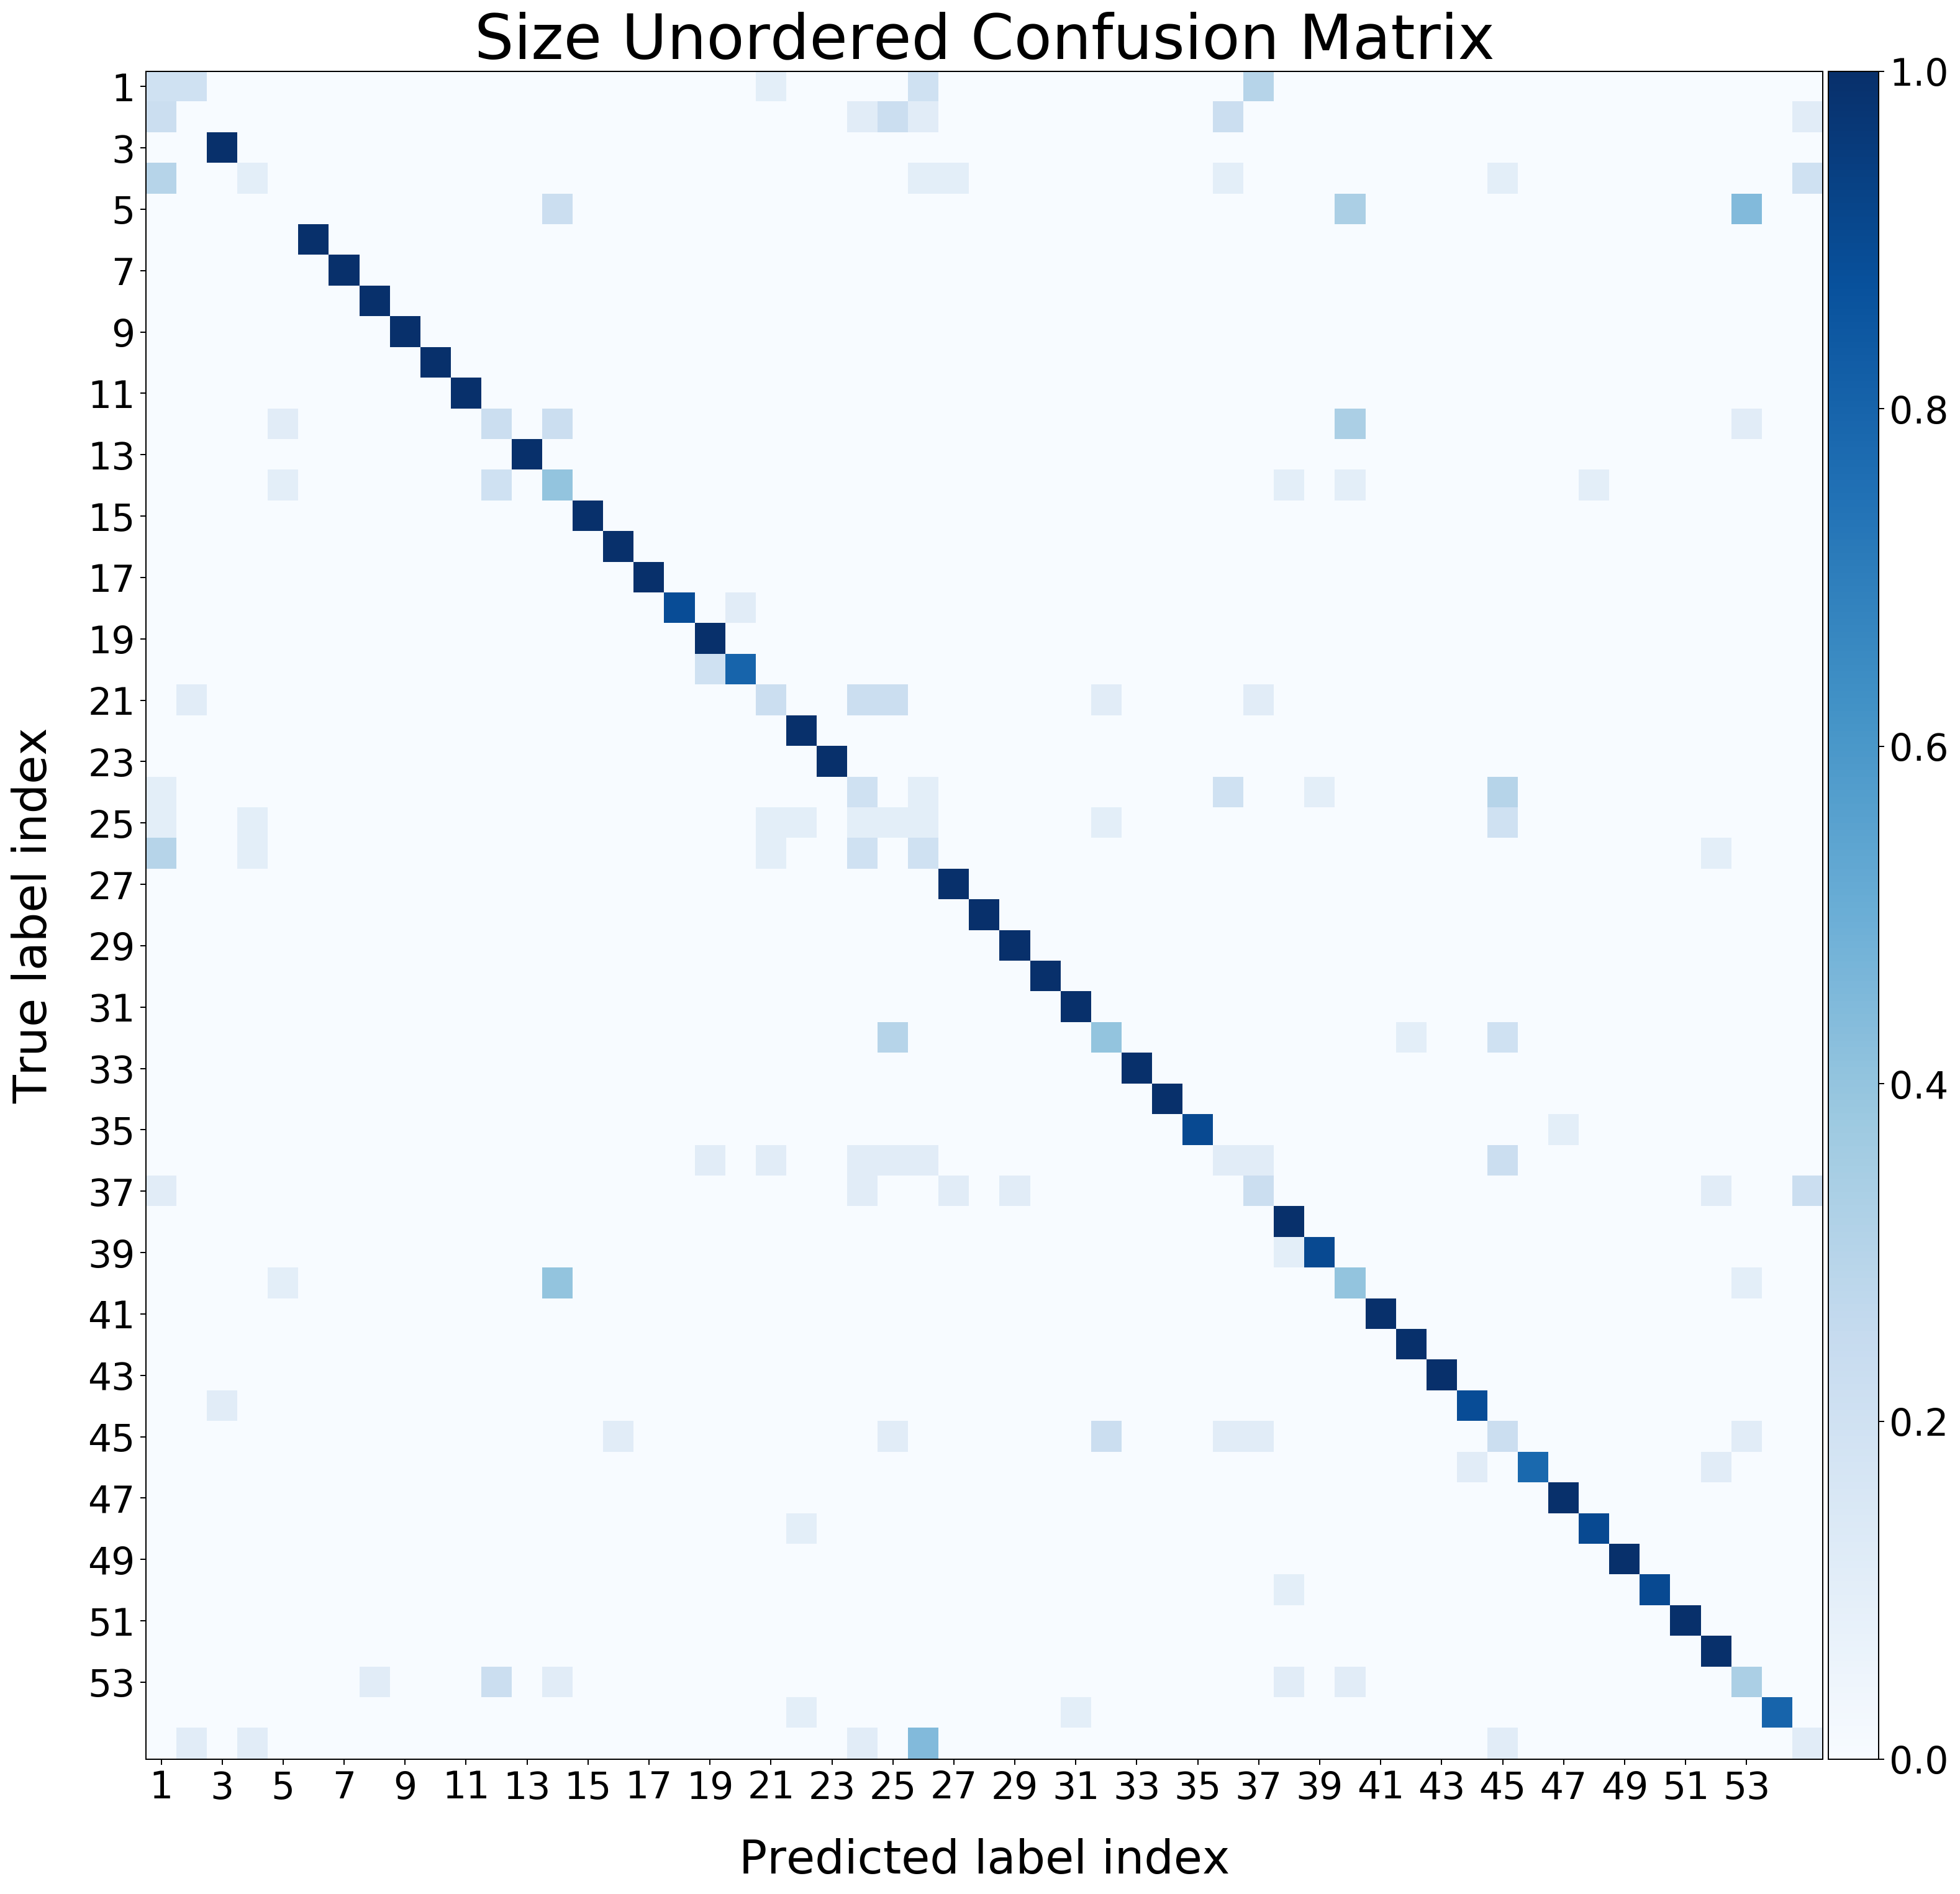

In [1350]:
DATA_PATH = "data/huawei/open-3/"
DISCARDED_ACTION = ['NoApp_NoAction']
cm_unordered = evaluate(DATA_PATH, DISCARDED_ACTION=DISCARDED_ACTION,
                        APP_TO_INDEX=APP_TO_INDEX, MINIMUM_PAYLOAD=0, 
                        RETURN_CM=True, TITLE="Size Unordered Confusion Matrix", 
                        figname="Confusion_matrix_unordered_by_amount_of_traffic")

Saved image ./plots/Confusion_matrix_ordered_by_amount_of_traffic_index.png


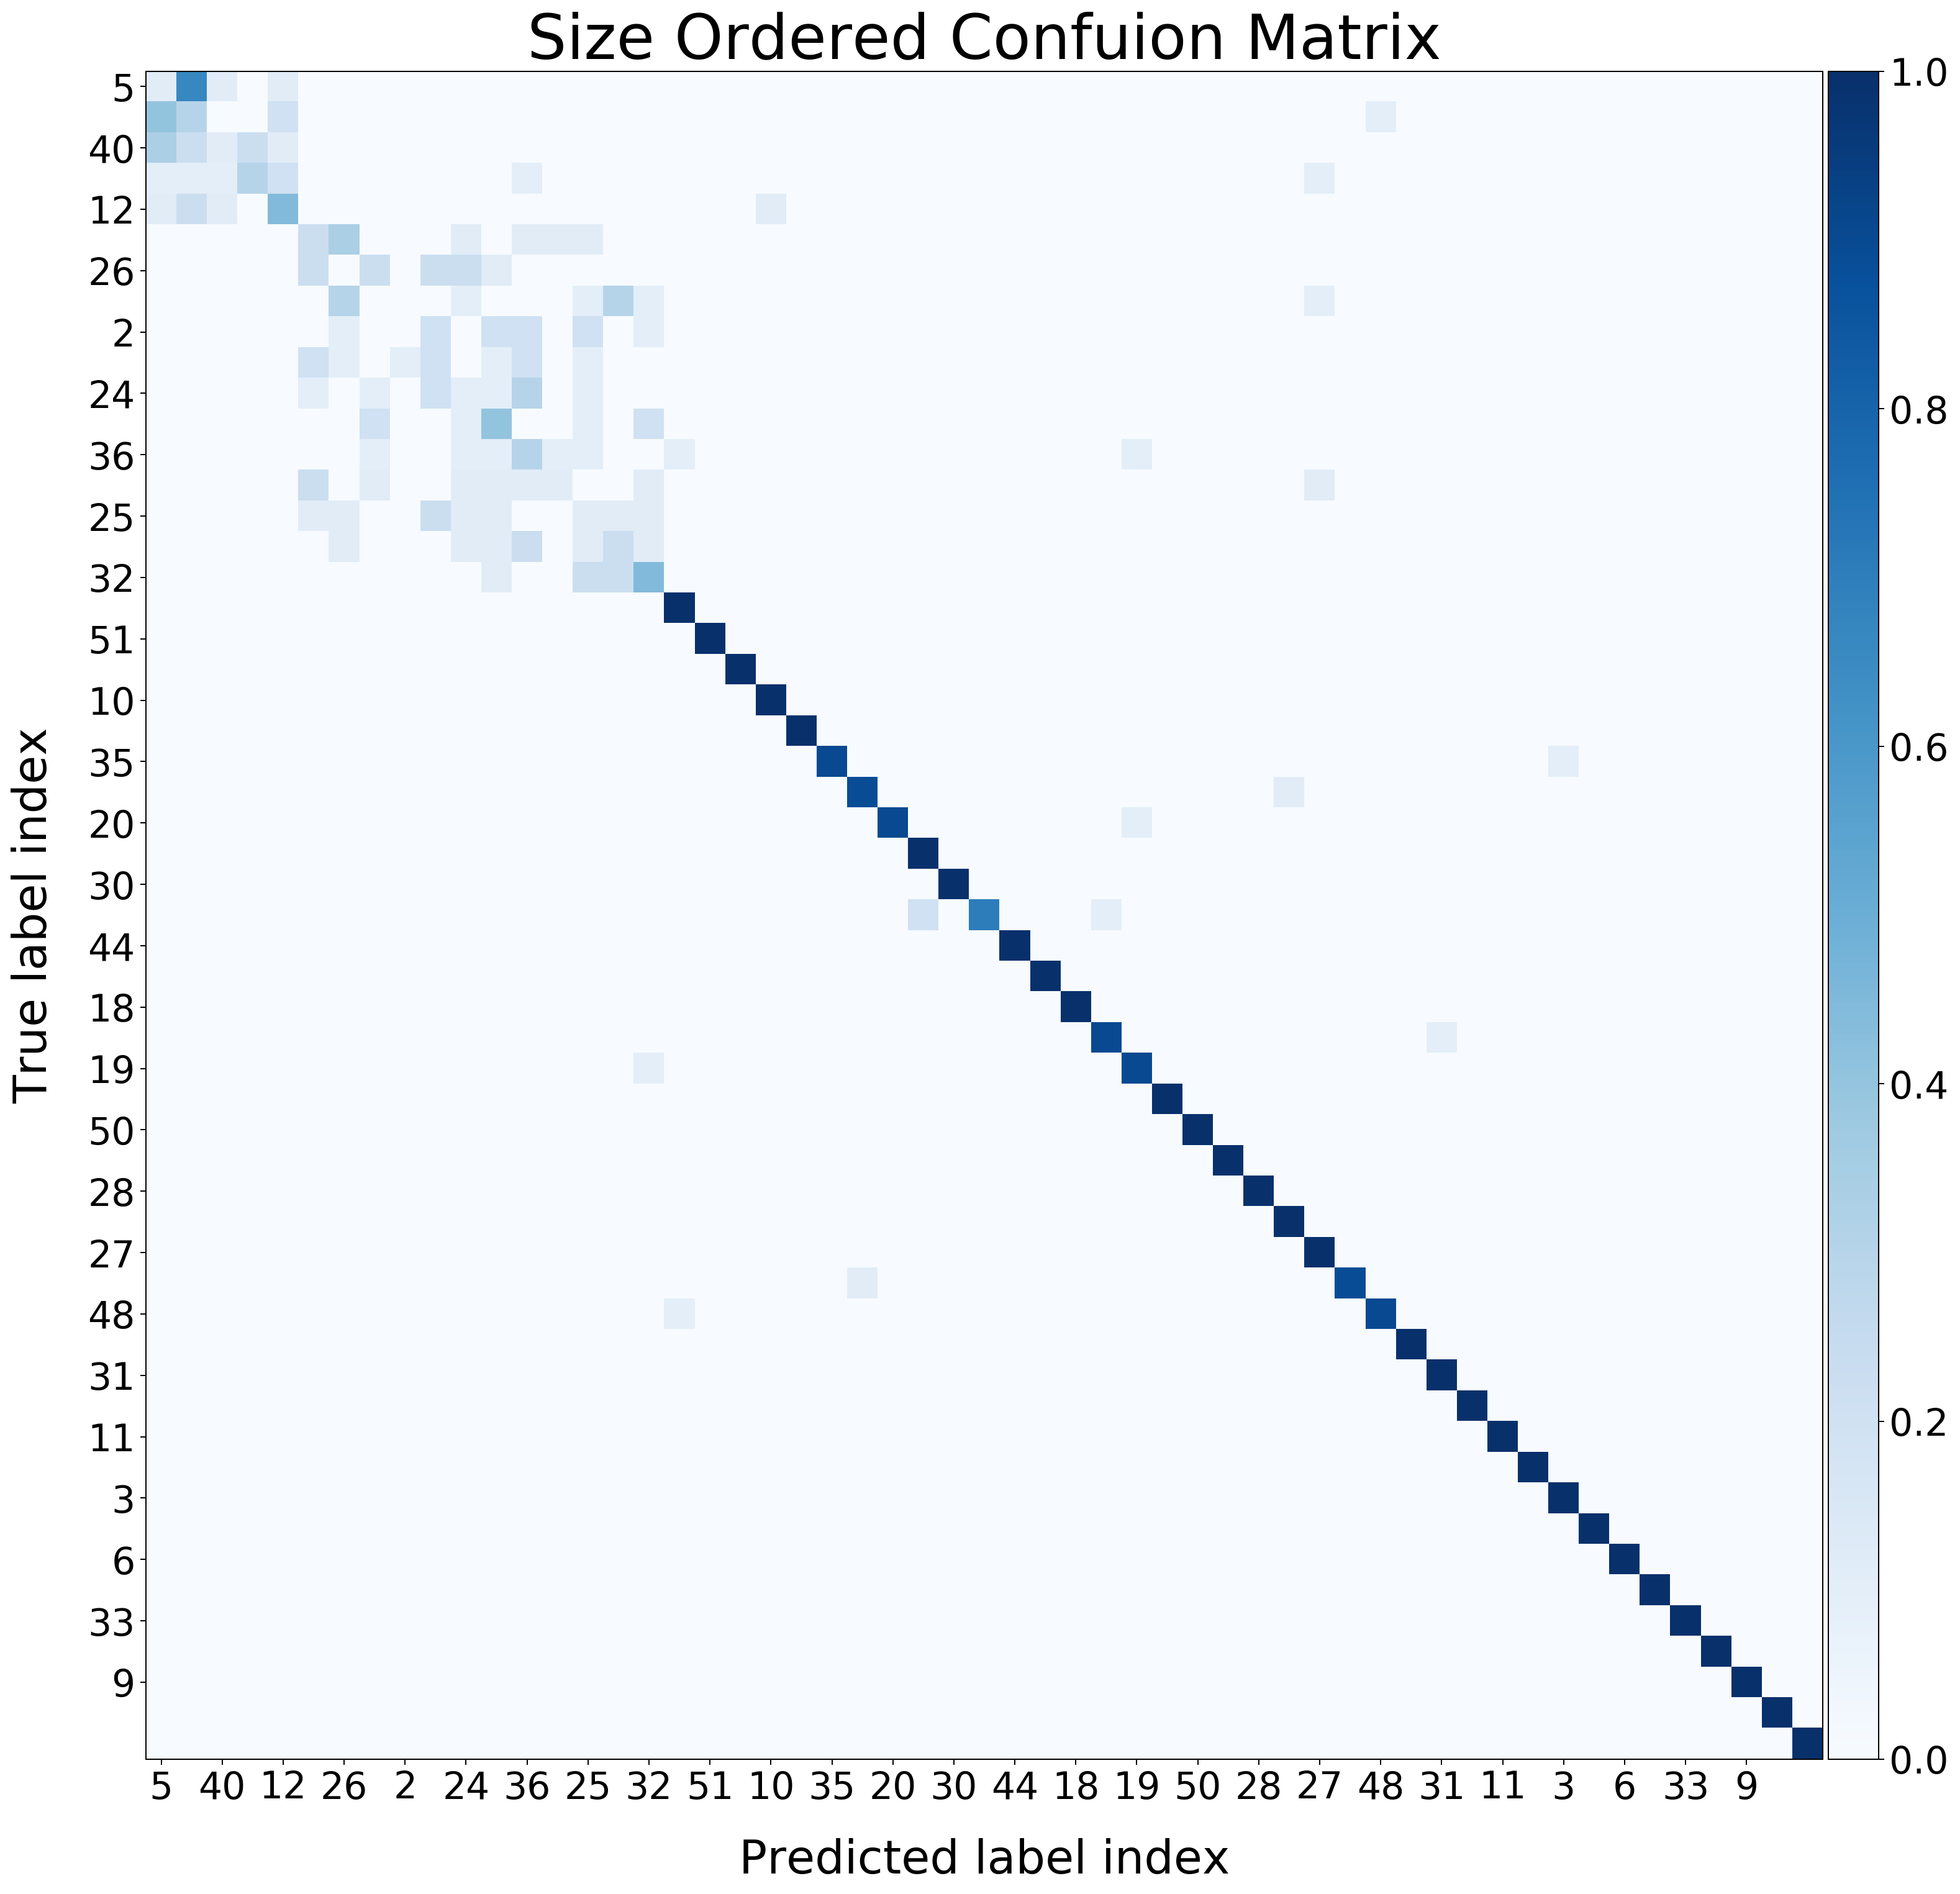

In [1351]:
DATA_PATH = "data/huawei/open-3/"
DISCARDED_ACTION = ['NoApp_NoAction']
cm_ordered, class_order, associated_size = evaluate(DATA_PATH, MINIMUM_PAYLOAD=0, DISCARDED_ACTION=DISCARDED_ACTION,
              ORDER_CM_BY_SIZE=True, APP_TO_INDEX=APP_TO_INDEX,
              TITLE="Size Ordered Confuion Matrix", figname="Confusion_matrix_ordered_by_amount_of_traffic")

Accuracy vs median total payload length

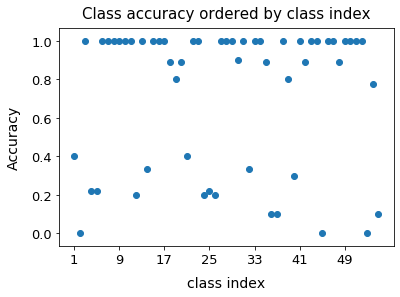

In [352]:

fig, ax = plt.subplots()
accuracies = np.diag(cm_ordered)
classes_idx = [APP_TO_INDEX[c] for c in class_order]

plt.scatter(classes_idx, y=accuracies)
plt.xticks(np.arange(1,len(classes_idx)+1,spacing))
ax.set_title("Class accuracy ordered by class index", pad=10, fontsize=15)
ax.set_ylabel("Accuracy", labelpad=10, fontsize=14)
ax.set_xlabel("class index", labelpad=10, fontsize=14)
ax.tick_params(labelsize=13)
plt.savefig("scatter_plot_accuracy_size_unordered", dpi=180, bbox_inches='tight')


In [1474]:
np.mean(associated_size[:17])

102.67647058823529

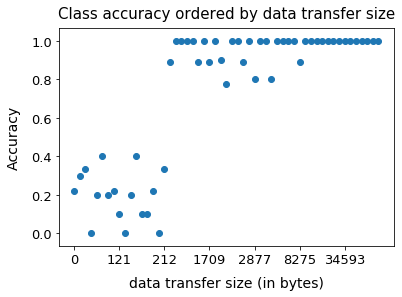

In [353]:
spacing = 8
fig, ax = plt.subplots()
accuracies = np.diag(cm_ordered)
classes_idx = [APP_TO_INDEX[c] for c in class_order]

plt.scatter(np.arange(1,56), y=accuracies)
plt.xticks(np.arange(1,len(classes_idx)+1,spacing))
labels = [item.get_text() for item in ax.get_xticklabels()]
j=0
for i, s in enumerate(associated_size):
    if i%spacing==0:
            
        labels[j] = int(s)
        j+=1
ax.set_xticklabels(labels)


ax.set_title("Class accuracy ordered by data transfer size", pad=10, fontsize=15)
ax.set_ylabel("Accuracy", labelpad=10, fontsize=14)
ax.set_xlabel("data transfer size (in bytes)", labelpad=10, fontsize=14)
ax.tick_params(labelsize=13)
plt.savefig("scatter_plot_accuracy_size_ordered", dpi=180, bbox_inches='tight')



In [310]:
separation = np.where(accuracies < 0.6)[0][-1] + 1
accuracies_bellow = accuracies[:separation]
accuracies_beyond = accuracies[separation:]

print("Mean Accuracy by taking the first n that have less than x total payload", accuracies_bellow.mean())
print("Mean Accuracy by taking the first n that have more than x total payload", accuracies_beyond.mean())


Mean Accuracy by taking the first n that have less than x total payload 0.14836601307189543
Mean Accuracy by taking the first n that have more than x total payload 0.9748538011695906


<a id="dataset_size"></a>
### Dataset size Investigation
[Table of Content](#dataset_size)

In [ ]:
DATA_PATH = "data/huawei/open-3/"


n_splits = 5
n_repeat = 15
accuracies_dataset_size = []
confs_dataset_size = []
steps = np.arange(2, 31)

for i in steps:
    print("Keep only ",i, " samples per category")
    for _ in range(n_repeat):
        acc, conf = evaluate(DATA_PATH=DATA_PATH, N_SPLITS=n_splits, RETURN_ACC_AND_CONF=True, DATA_SIZE_FILTER=i)
        print(" %0.2f (+/- %0.2f)" % (acc, conf))
        accuracies_dataset_size.append(acc)
        confs_dataset_size.append(conf)


In [848]:

accuracies_avg = np.array(accuracies_dataset_size).reshape((-1,15)).mean(axis = 1)

#np.array(accuracies_dataset_size).reshape(15, -1).mean(axis=0)

In [850]:
confs_dataset_size = np.array(confs_dataset_size).reshape((-1,15)).mean(axis = 1)

In [849]:
accuracies_avg

array([0.49192982, 0.71632184, 0.80350877, 0.86166667, 0.9097076 ,
       0.91800995, 0.93403509, 0.94046512, 0.94652632, 0.95073016,
       0.95450292, 0.9544086 , 0.95468672, 0.95748252, 0.95447368,
       0.95761317, 0.95875244, 0.96198895, 0.96063158, 0.96306667,
       0.96370016, 0.9656621 , 0.96555556, 0.96694678, 0.96912281,
       0.96705577, 0.96907268, 0.96961353, 0.96987135])

In [851]:
confs_dataset_size

array([0.20851962, 0.12544292, 0.13147172, 0.09469753, 0.06316215,
       0.05673628, 0.04834821, 0.03772693, 0.03844747, 0.0342276 ,
       0.02784823, 0.02983184, 0.02905044, 0.02910671, 0.02957679,
       0.02351076, 0.02683051, 0.02368374, 0.02144365, 0.02509572,
       0.02006417, 0.02004529, 0.01800203, 0.01805097, 0.01613624,
       0.01732449, 0.01737628, 0.01605768, 0.01842224])

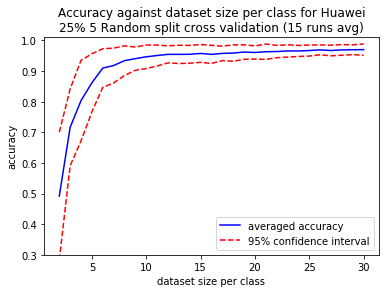

In [567]:
xlabel="dataset size per class"
ylabel="accuracy"
title="Accuracy against dataset size per class for Huawei\n25% "+str(n_splits)+" Random split cross validation ("+ str(n_repeat)+" runs avg)"
fname="./plots/Accuracy_against_dataset_size_per_class_for_Huawei_final.png"
plot_acc_and_conf(steps, accuracies_dataset_size, confs_dataset_size, n_repeat, y_lim=[0.3, 1.01], 
                  xlabel=xlabel, ylabel=ylabel, title=title, fname=fname, dpi=120)

In [ ]:
DATA_PATH = "data/fossil/open-6/"

n_splits = 3
n_repeat = 15
accuracies_dataset_size = []
confs_dataset_size = []
steps = np.arange(2, 29)

for i in steps:
    print("Keep only ",i, " samples per category")
    for _ in range(n_repeat):
        acc, conf = evaluate(DATA_PATH=DATA_PATH, N_SPLITS=2, RETURN_ACC_AND_CONF=True, DATA_SIZE_FILTER=i)
        print(" %0.2f (+/- %0.2f)" % (acc, conf))
        accuracies_dataset_size.append(acc)
        confs_dataset_size.append(conf)


In [ ]:
xlabel="dataset size per class"
ylabel="accuracy"
title="Accuracy against dataset size per class for Huawei\n25% test "+str(n_splits)+" Random split cross validation ("+ str(n_repeat)+" runs avg)"
fname="./plots/Accuracy_against_dataset_size_per_class_for_Fossil.png"

plot_acc_and_conf(steps, accuracies_dataset_size, confs_dataset_size, n_repeat, y_lim=[0.3, 1.01],
                  xlabel=xlabel, ylabel=ylabel, title=title, fname=fname, dpi=500)

<img src="./Results/Accuracy_against_dataset_size_per_class_for_Fossil.png" width='500px'>

<a id = "huawei"></a>
### Huaweiwatch 2
[Table of Content](#tc)


importing data...
filtering app that does not send traffic by their length
dataset equalization per class
samples per classes: 38
building features and labels
features count : 1002

importing data...
filtering app that does not send traffic by their length
dataset equalization per class
samples per classes: 38
building features and labels
features count : 500
building and training the model for cross validation 
Random split cross-validation: Accuracy=0.972 (+/- 0.016). 
building and training a model for confusion matrix
fitting duration = 0.796
prediction duration = 0.061
accuracy = 0.9750692520775623
Saved image ./plots/Confusion_matrix_for_huawei_open-3_acc=97_51_cross-val_radomSplit=50_accRs=97_2_+-1_6%_95%_conf_intervaltest=25%_minimum_payload=200B_nb_samples=38.png
Saved image ./plots/Confusion_matrix_for_huawei_open-3_acc=97_51_cross-val_radomSplit=50_accRs=97_2_+-1_6%_95%_conf_intervaltest=25%_minimum_payload=200B_nb_samples=38_nolabels.png
Saved image ./plots/Confusion_matrix

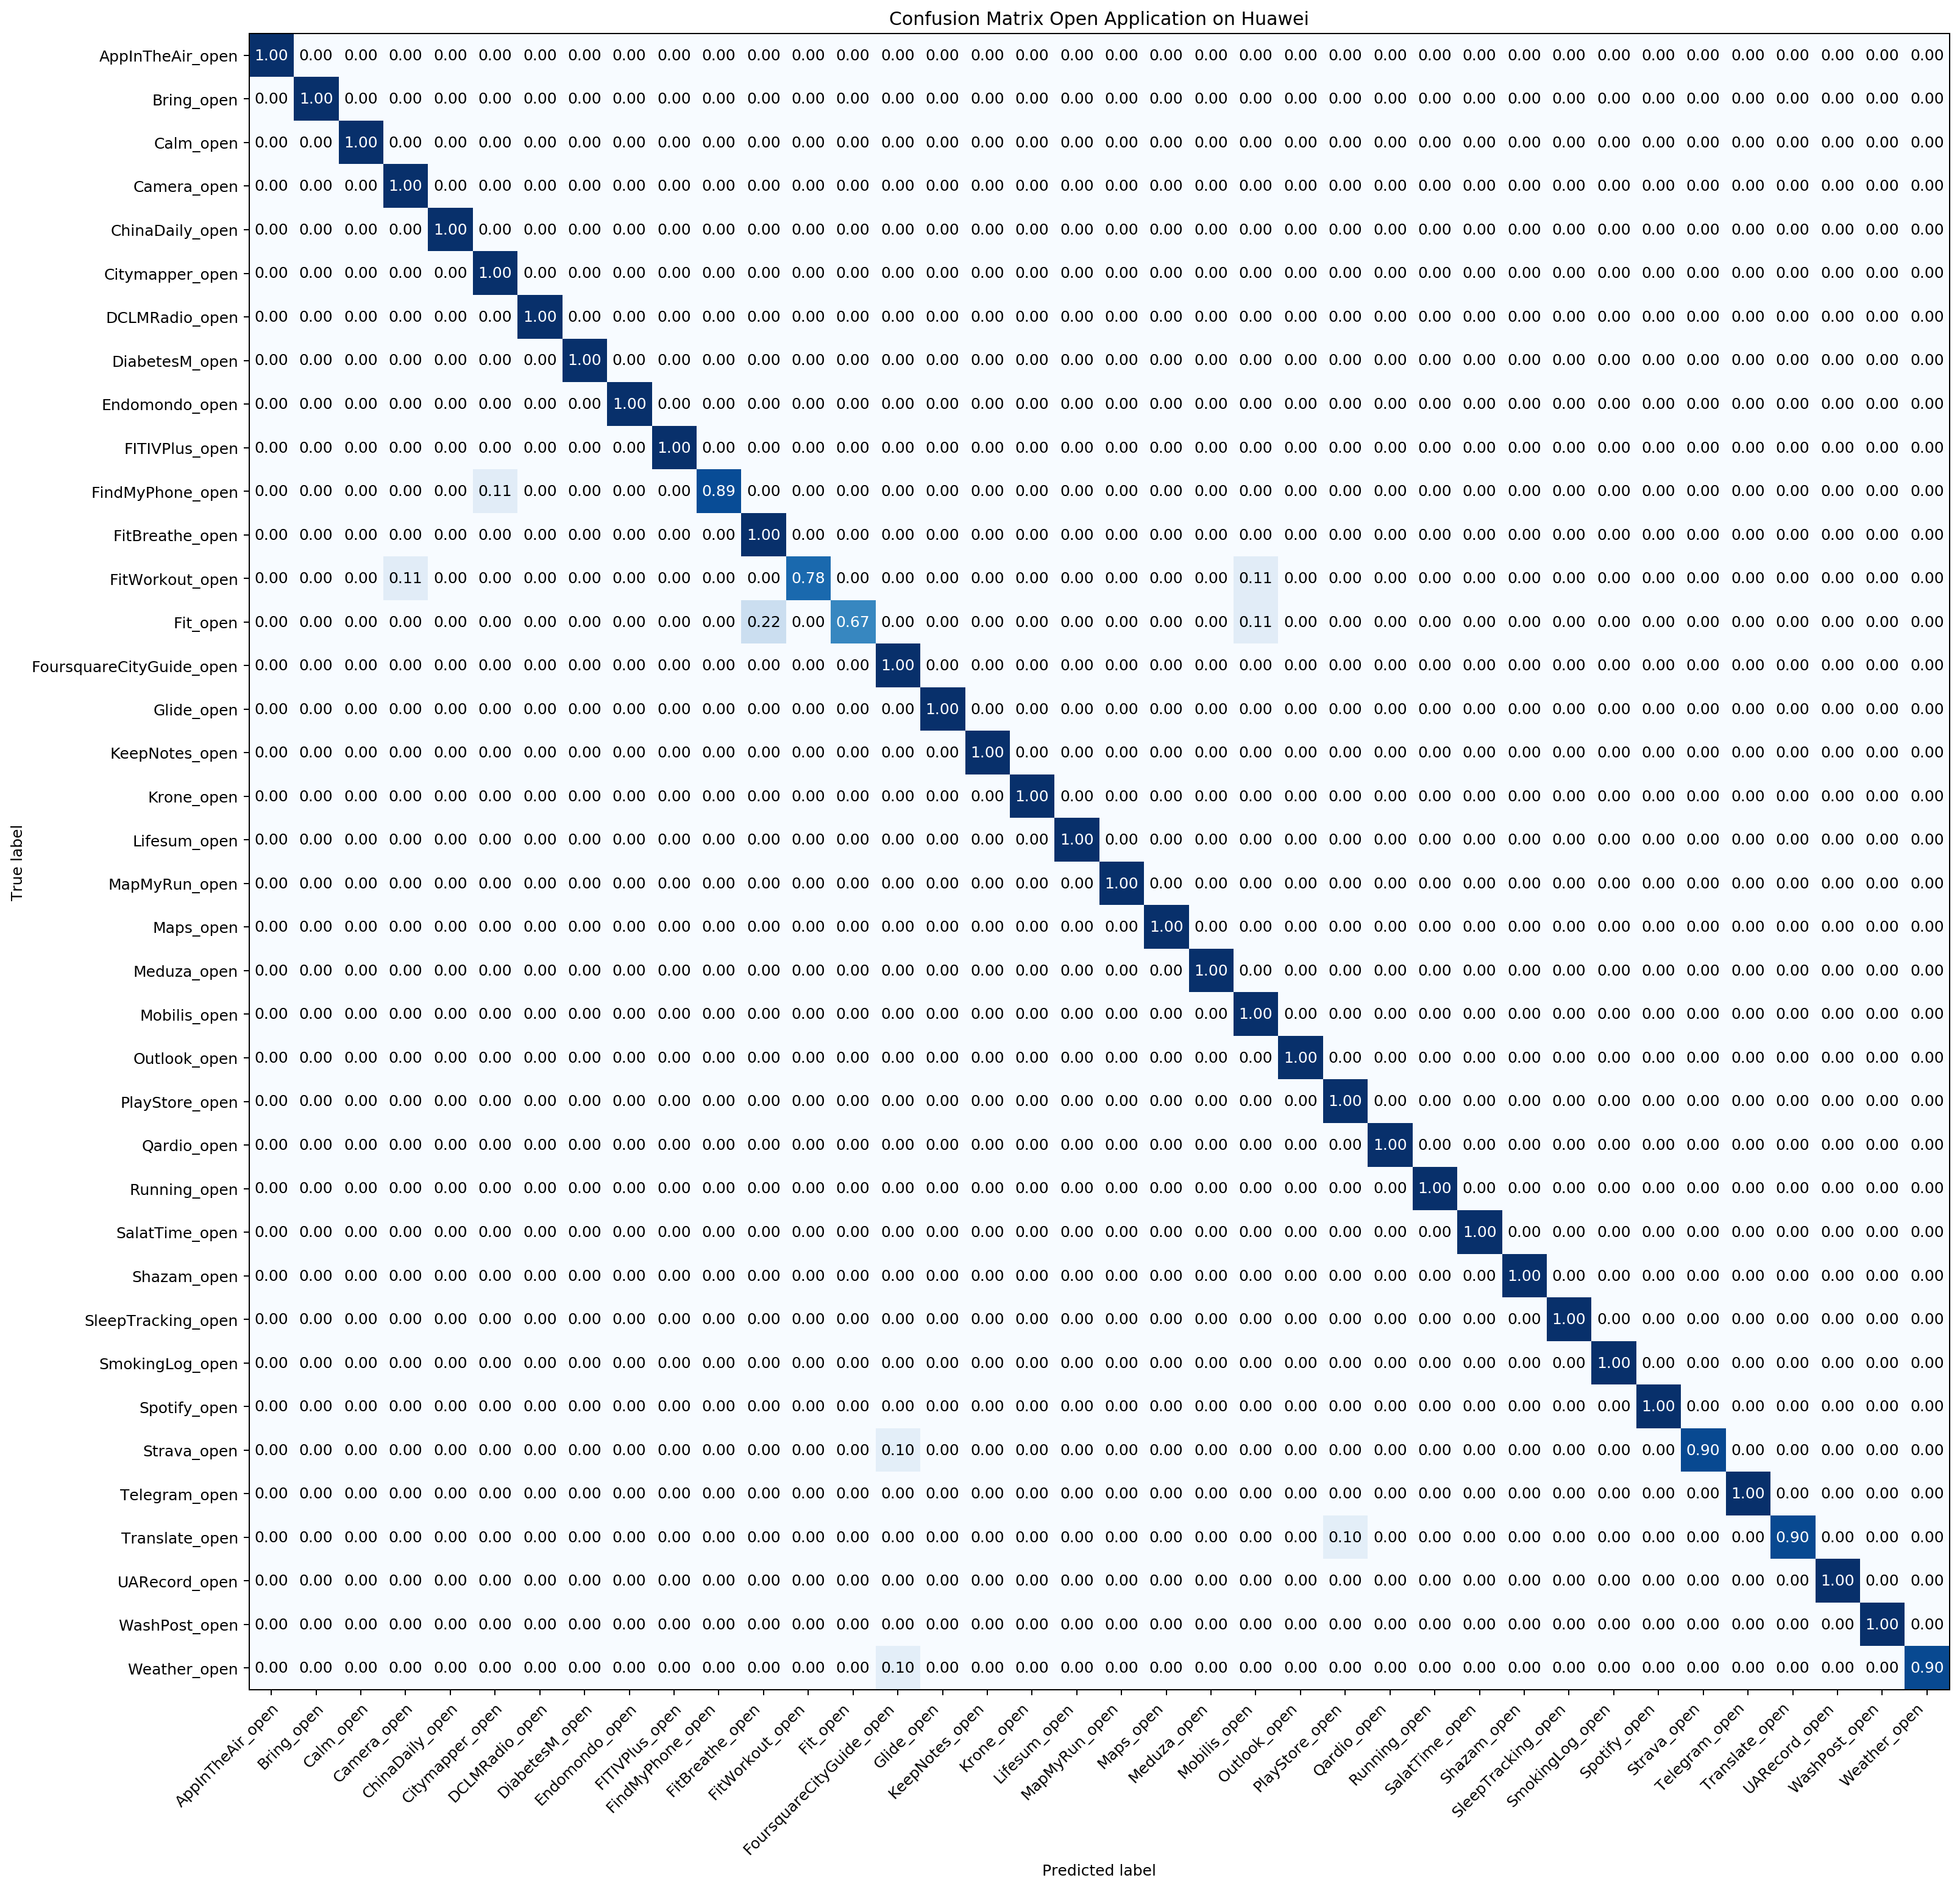

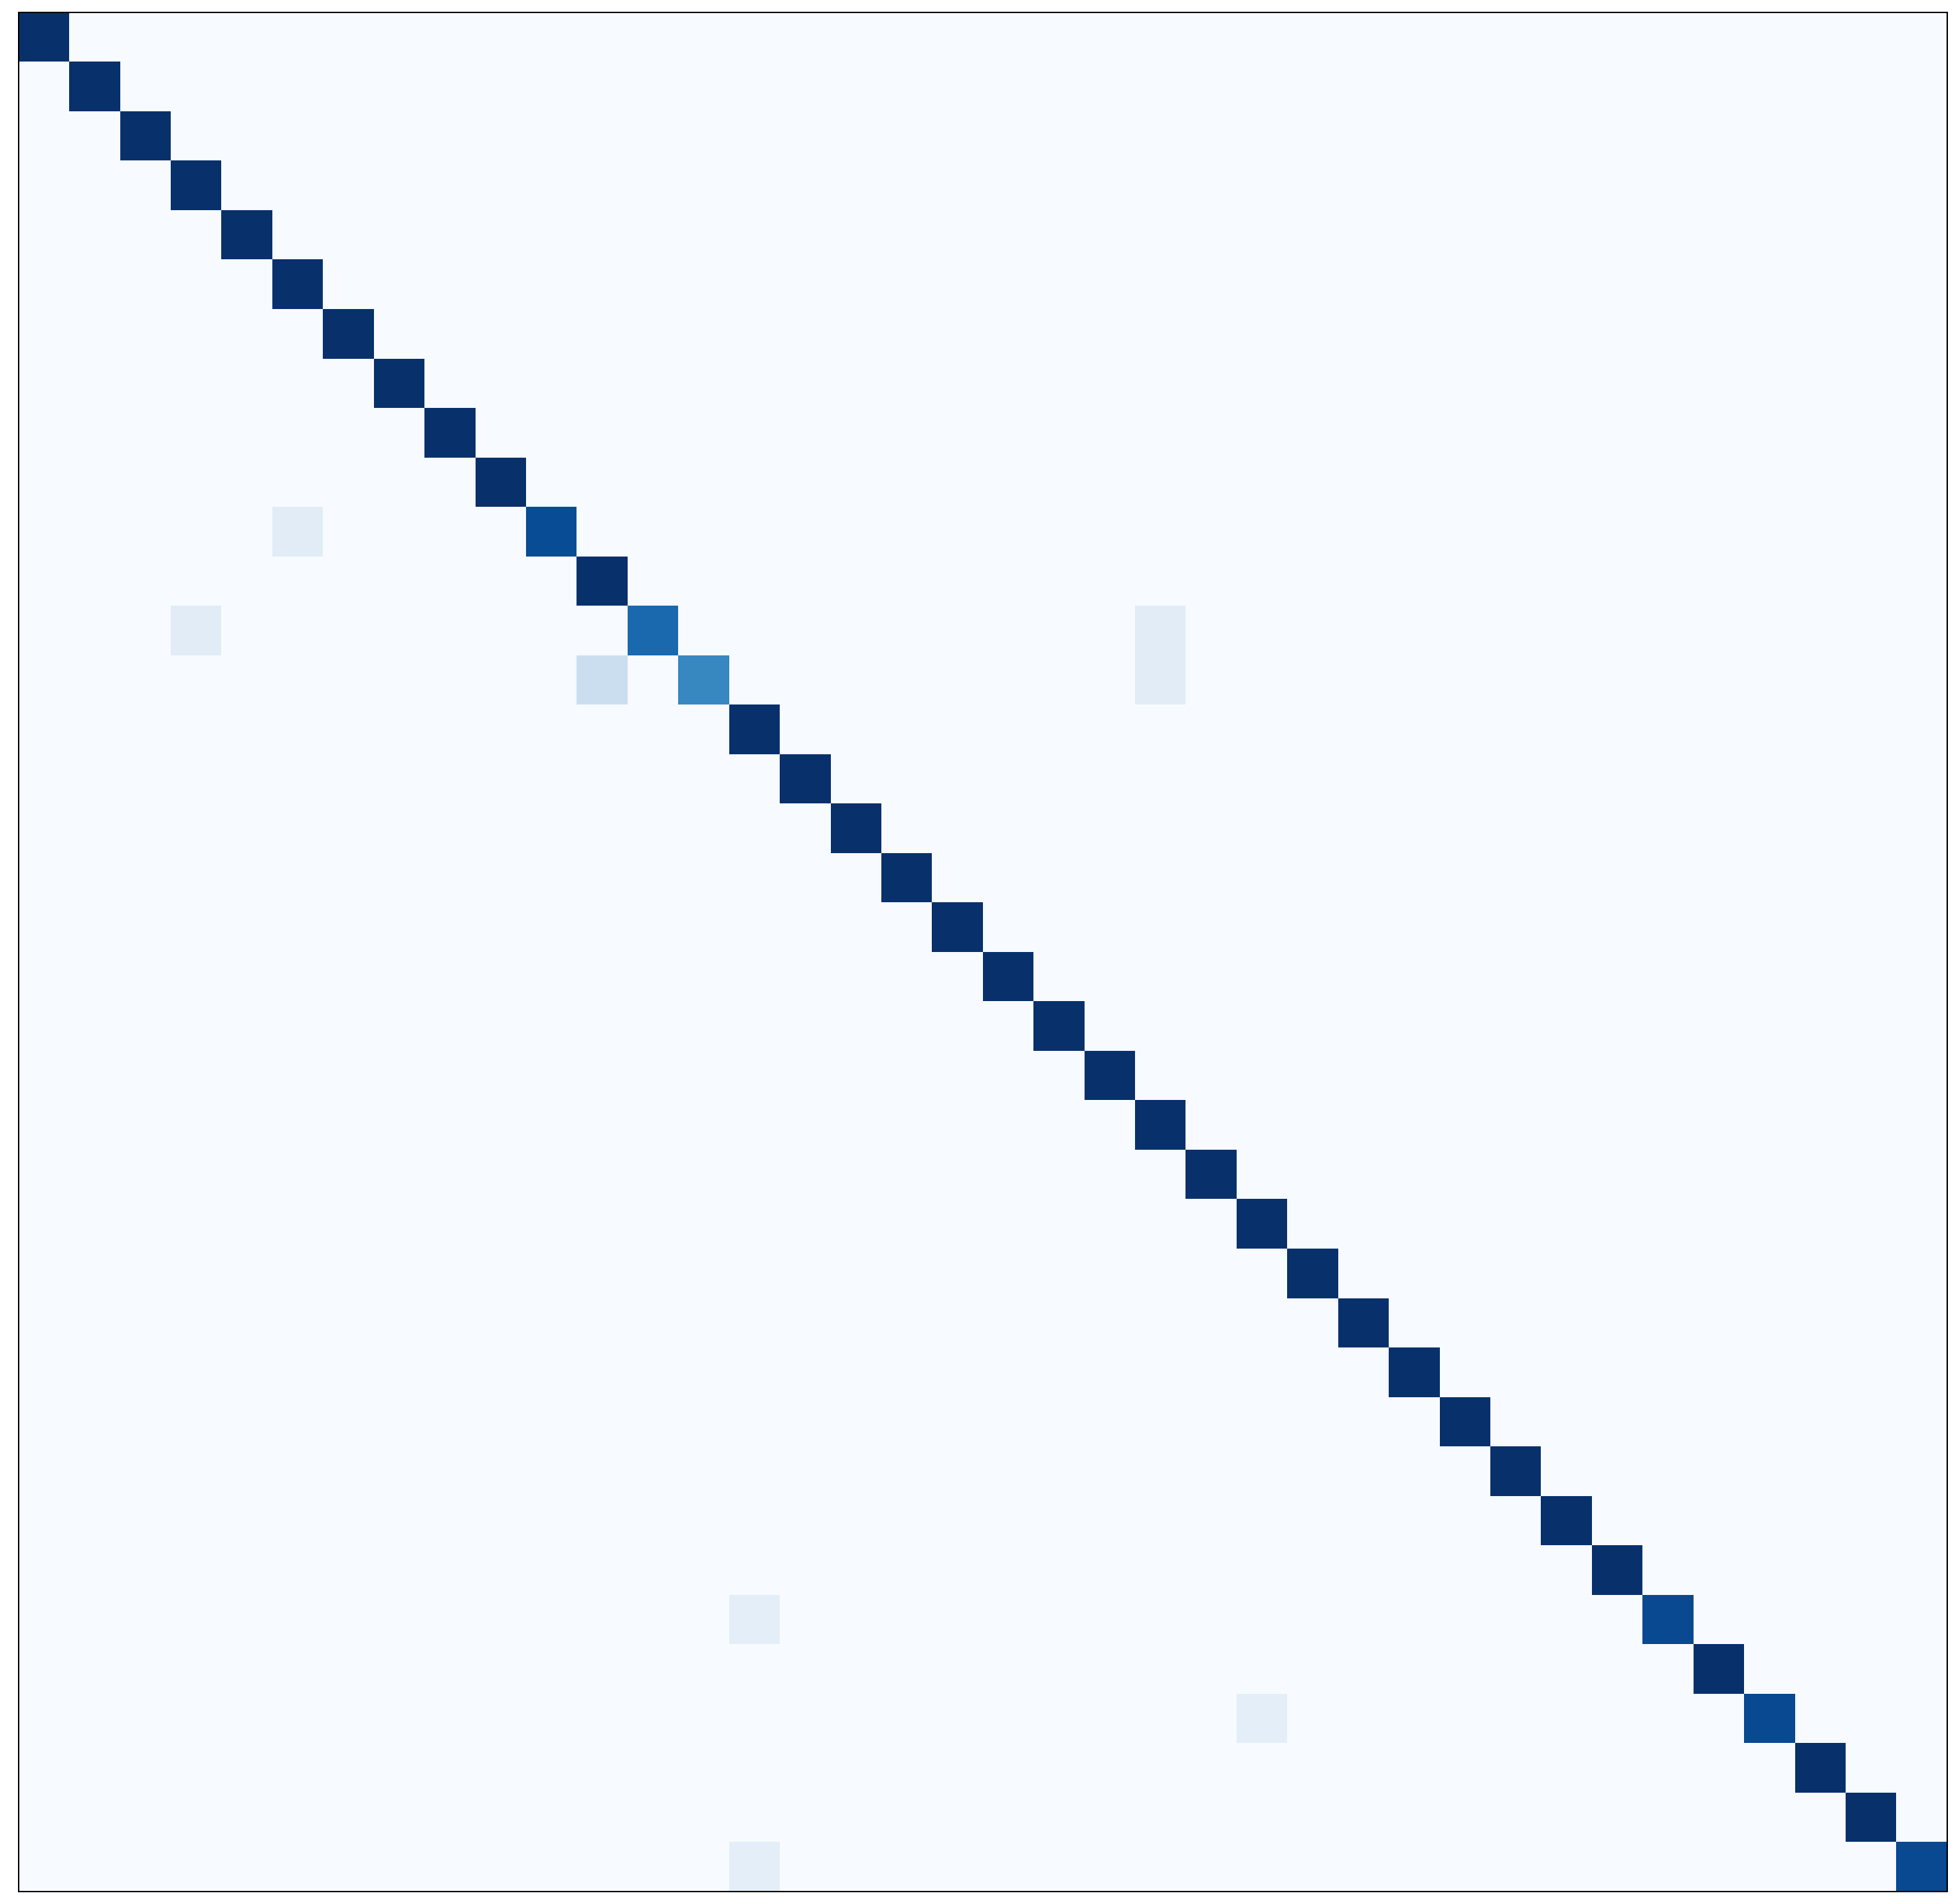

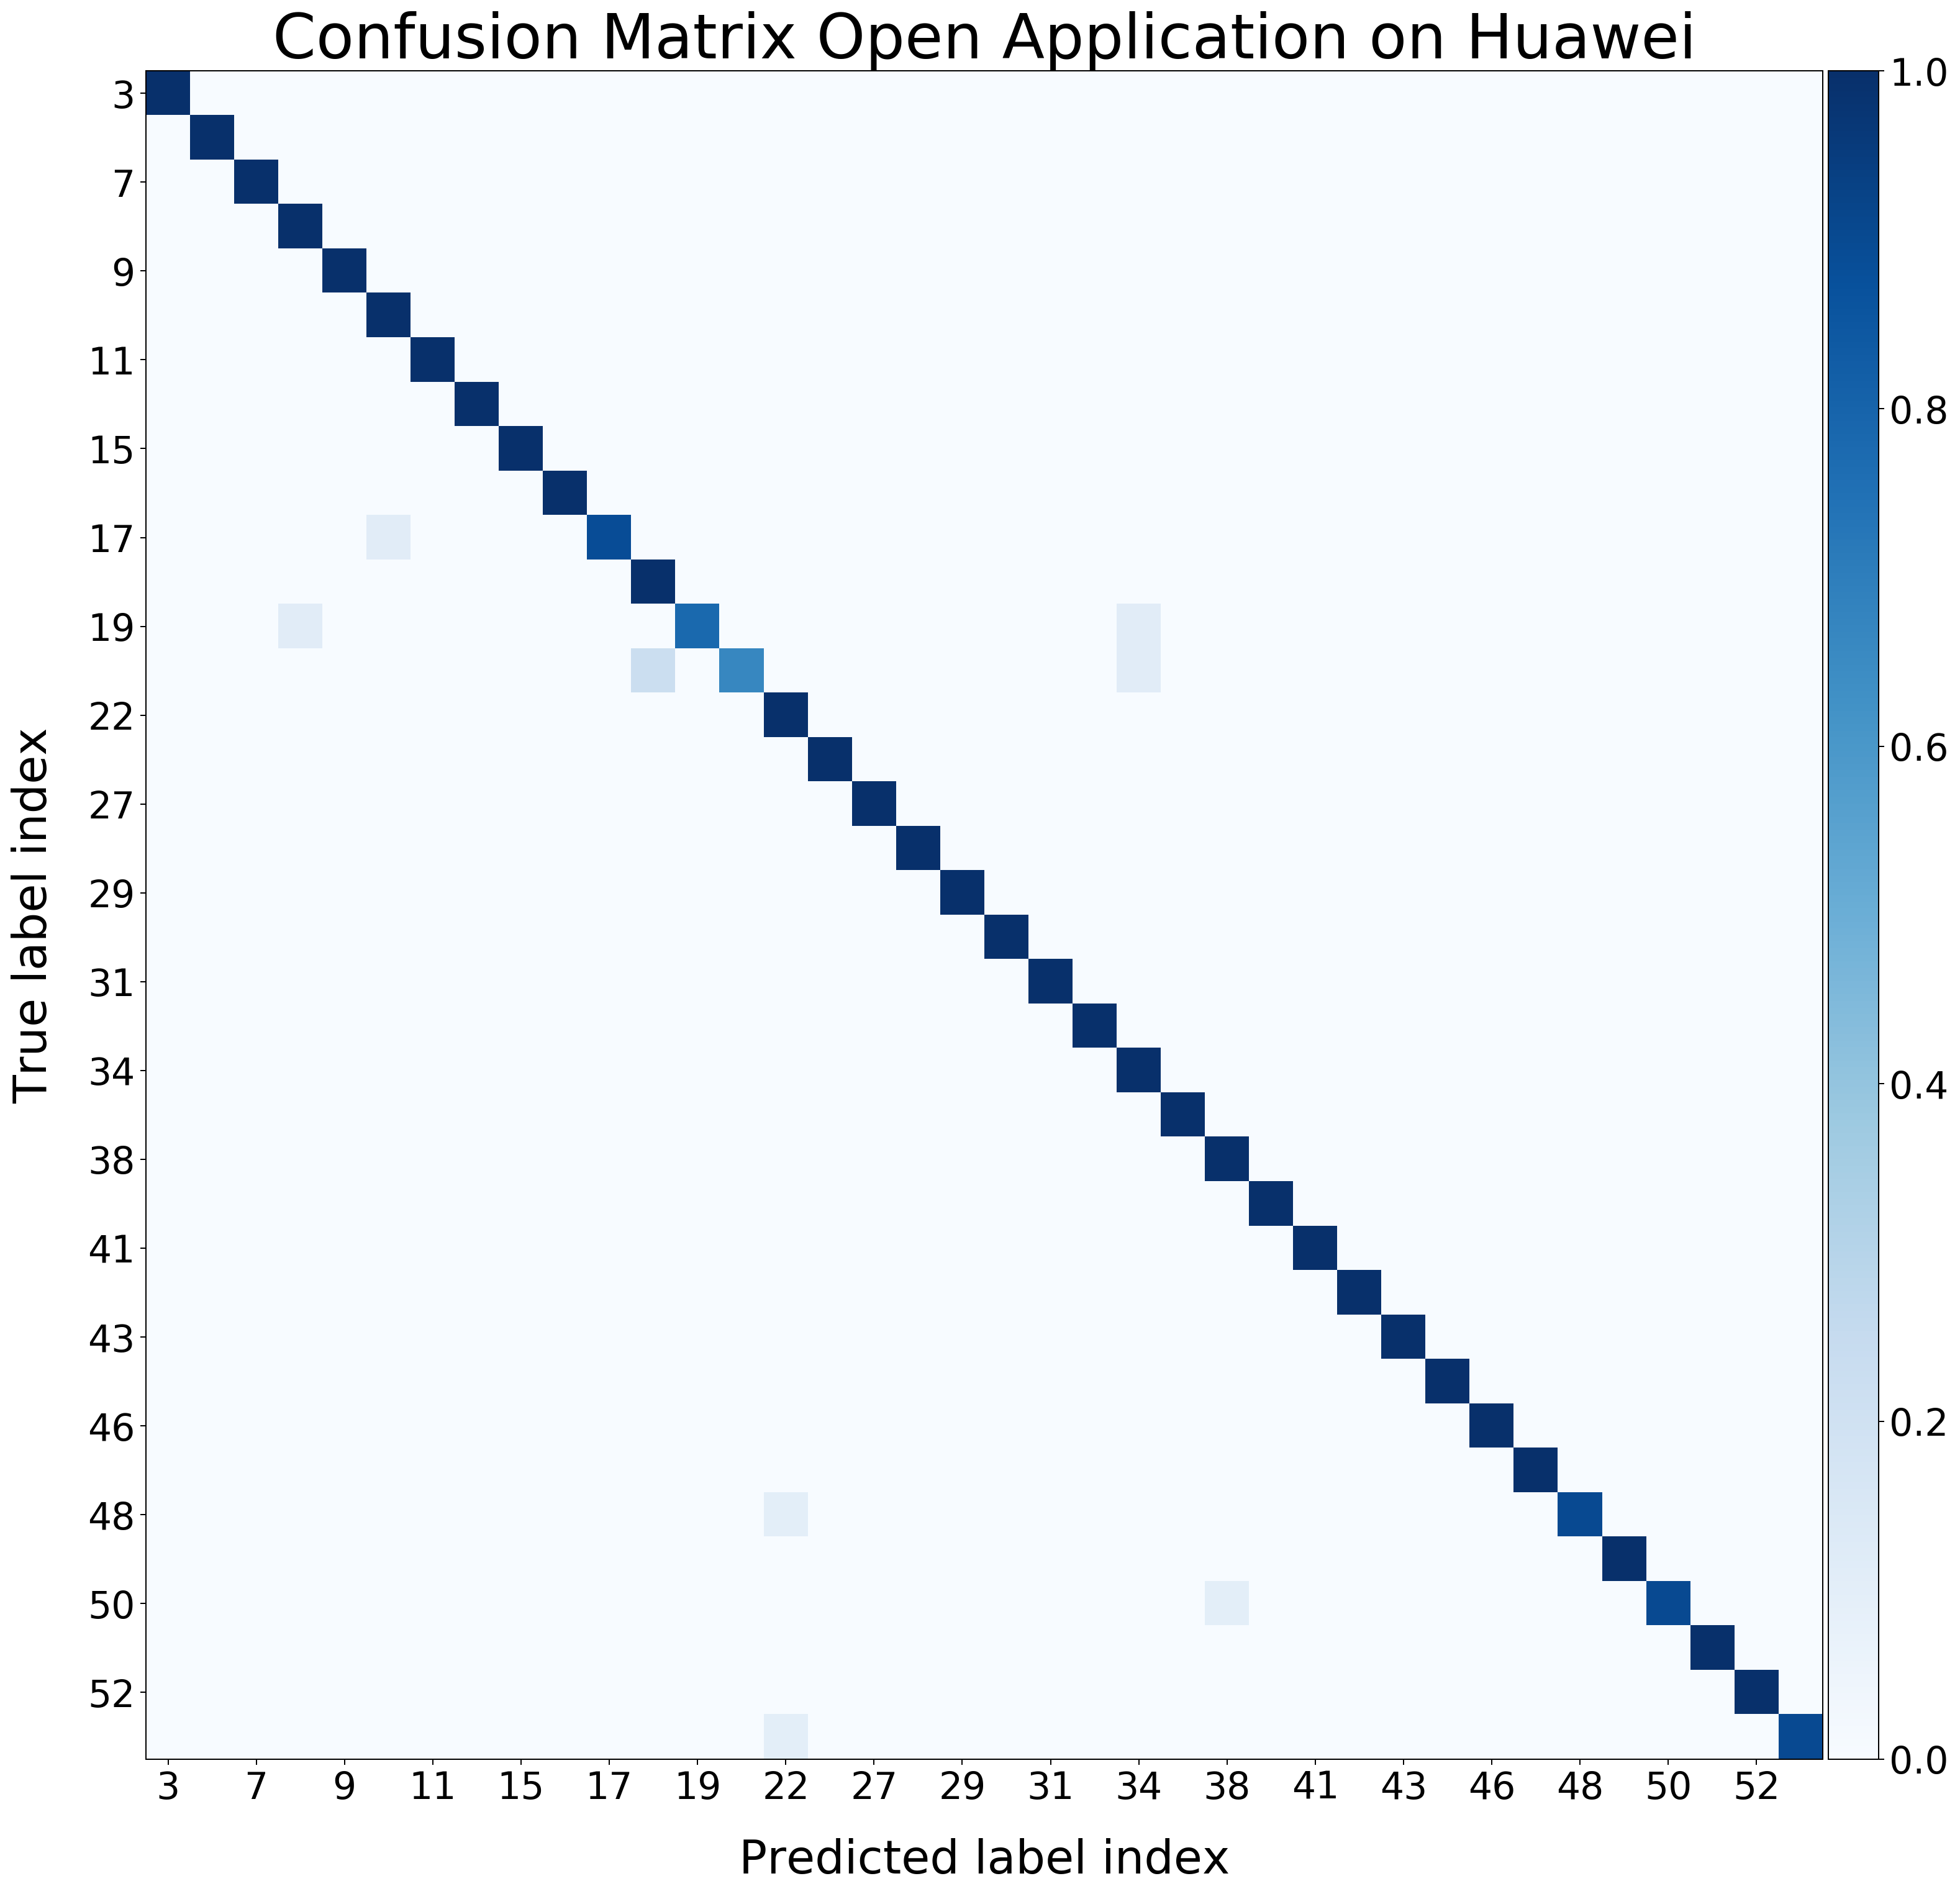

In [1475]:
DATA_PATH = ["data/huawei/open-3/"] #, "data/huawei/open-3/", "data/huawei/open-6/"] # all
to_withdraw = find_feat_to_withdraw(DATA_PATH,  MAX_ITERATION=1)
evaluate(DATA_PATH, DETAIL_PRINT=True, TO_WITHDRAW=to_withdraw,N_SPLITS=50, TITLE="Confusion Matrix Open Application on Huawei", APP_TO_INDEX=APP_TO_INDEX, CM_NO_LABELS=True, CM_ALL_LABEL=True,N_ESTIMATOR=200)

<a id=fossil_eval></a>
### Fossil Evaluation
[Table of content](#tc)

In [ ]:
DATA_PATH = "data/huawei/open-3/"
to_withdraw = find_feat_to_withdraw(DATA_PATH)

feature length :  1002
Saved image ./plots/Confusion_matrix_for_fossil_open-6_acc=92_24_cross-val_radomSplit=5_accRs=89_9_+-2_7%_95%_conf_intervaltest=25%_minimum_payload=200B_nb_samples=28_index.png


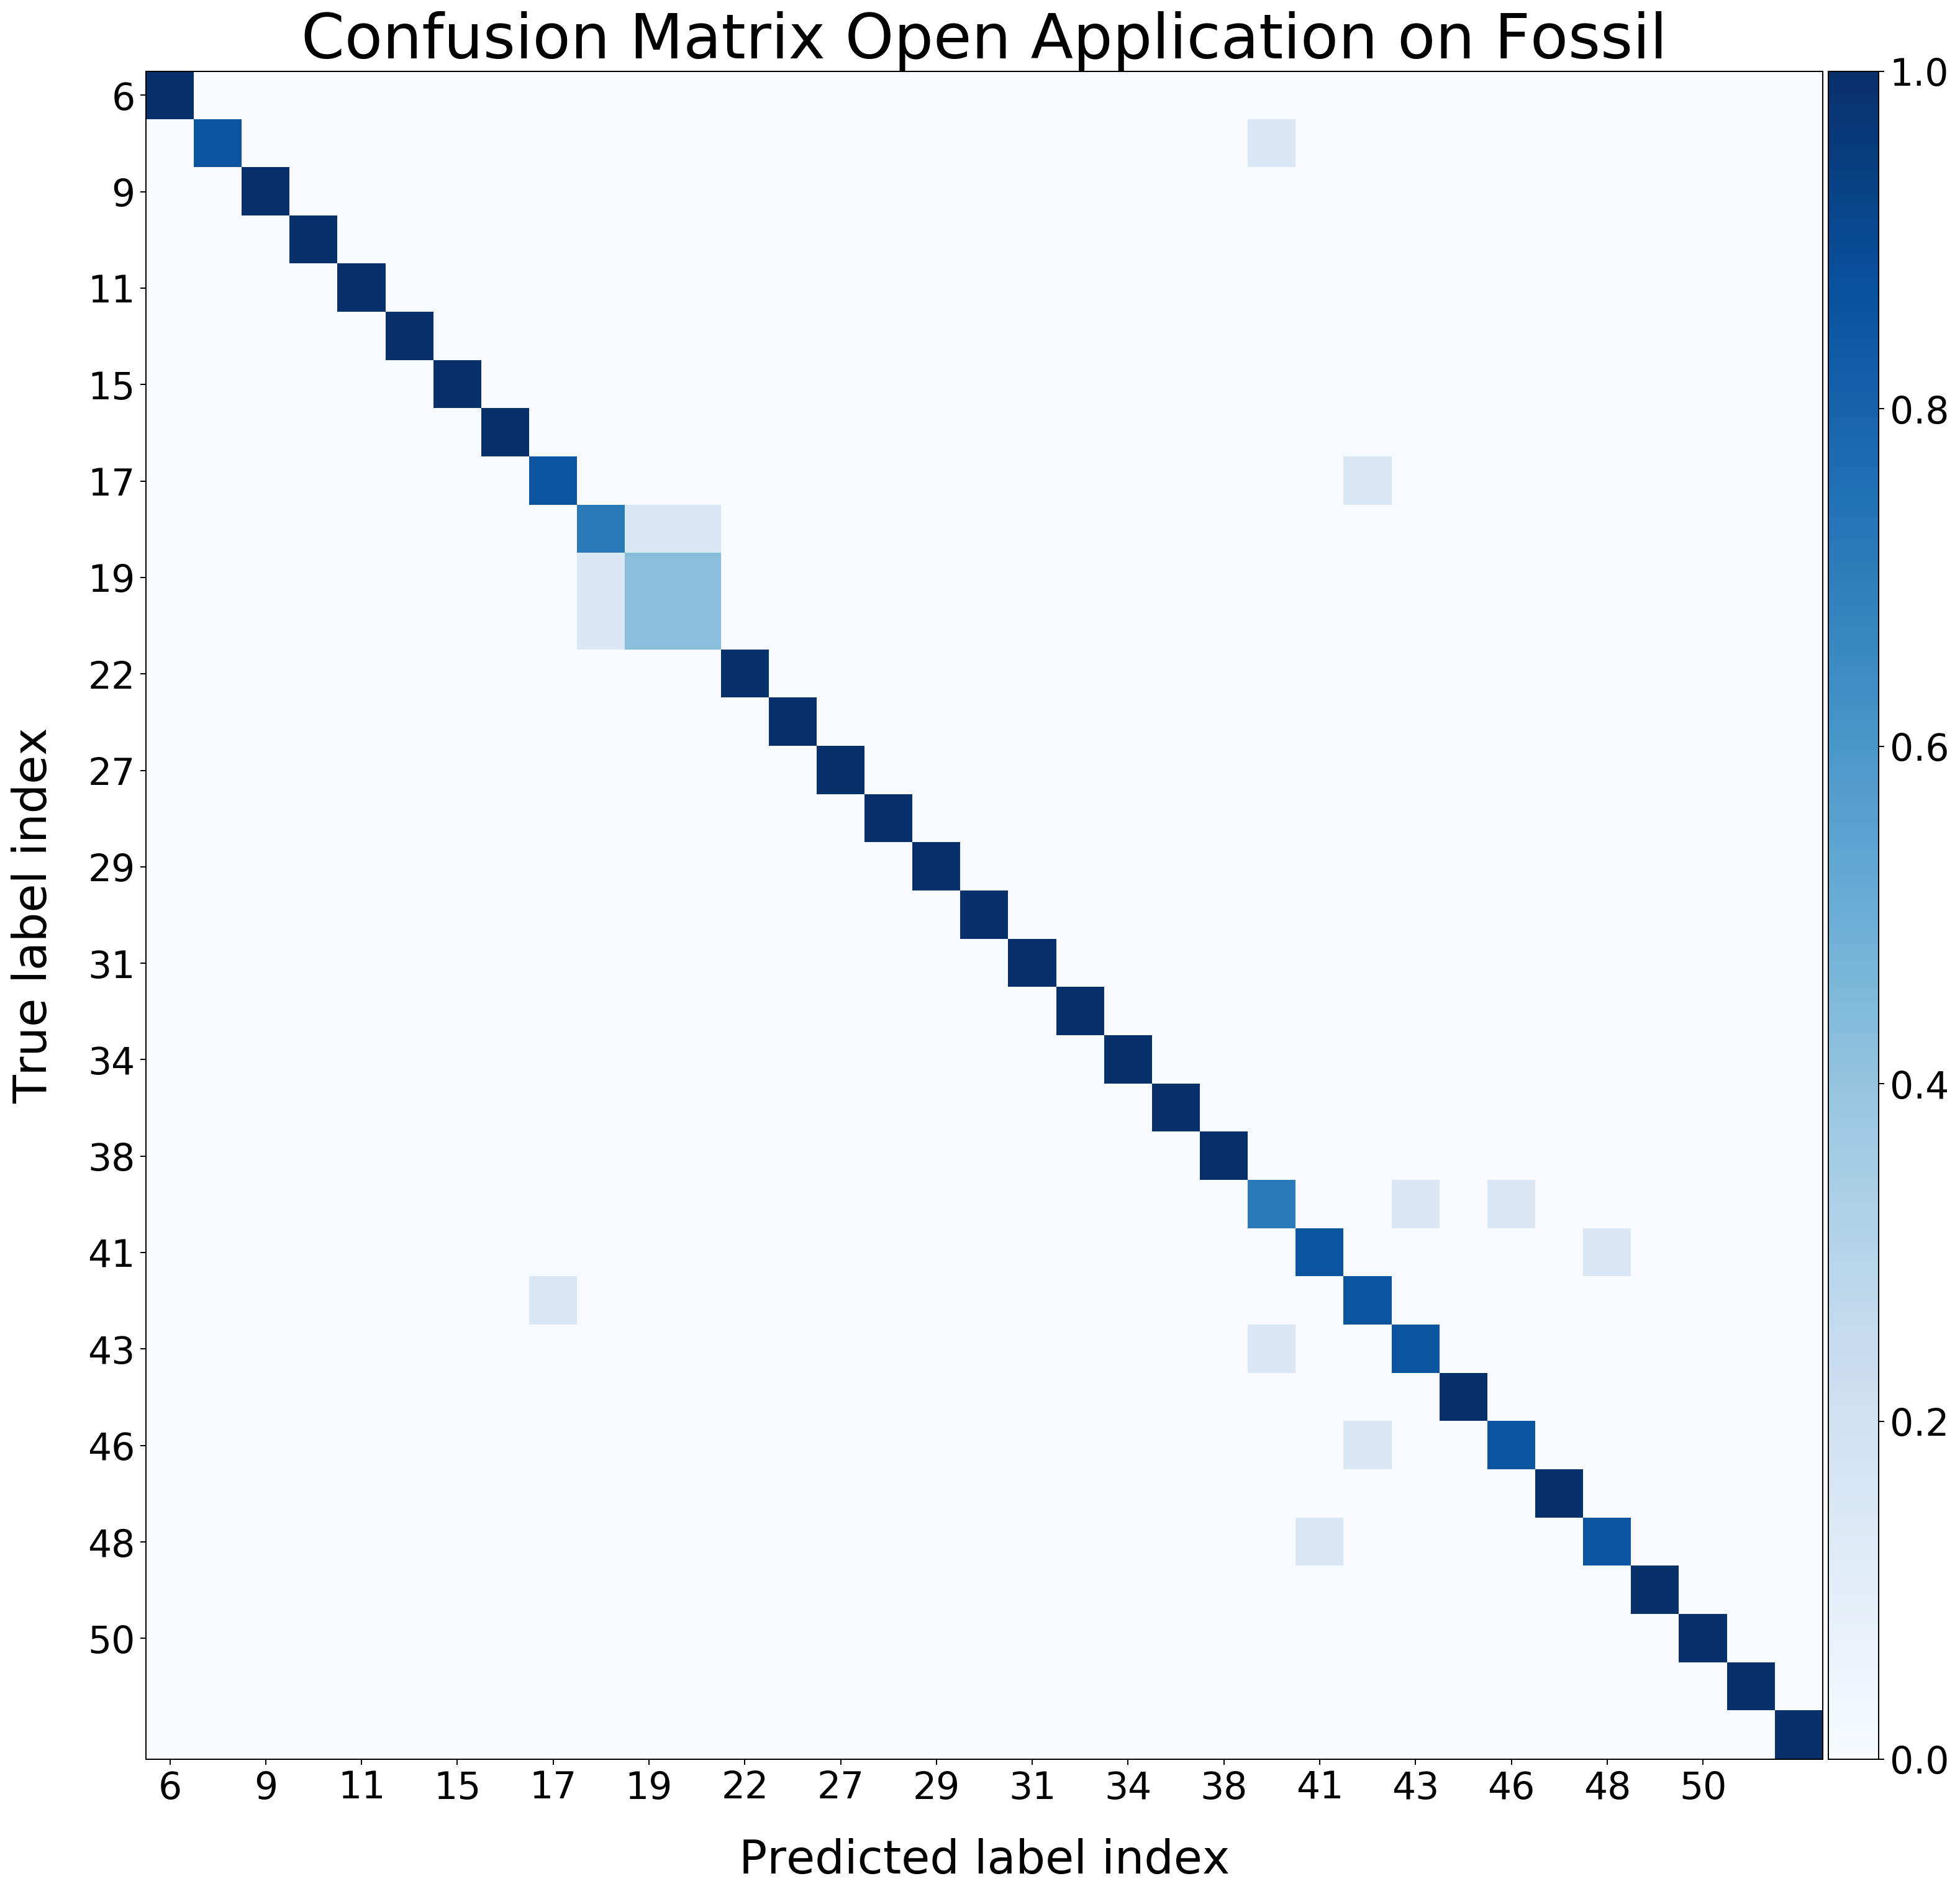

In [486]:
DATA_PATH = ["data/fossil/open-6/"] # all
M
evaluate(DATA_PATH, TITLE="Confusion Matrix Open Application on Fossil", 
         APP_TO_INDEX=APP_TO_INDEX, SPACING=2)

<a id="apple_watch"></a>
## Apple Watch

[Table of Content](#tc)

In [493]:
app_to_index_2 = build_app_to_index_dict(True)



importing data...
filtering app that does not send traffic by their length
dataset equalization per class
building features and labels
features count :  1002

importing data...
filtering app that does not send traffic by their length
dataset equalization per class
building features and labels
features count :  589
building and training the model for cross validation 
Random split cross-validation: Accuracy=0.880 (+/- 0.075). 
building and training a model for confusion matrix
fitting duration = 0.326
prediction duration = 0.025
accuracy = 0.8705882352941177
Saved image ./plots/Confusion_matrix_for_iwatch_batch-1_acc=87_06_cross-val_radomSplit=50_accRs=88_0_+-7_5%_95%_conf_intervaltest=25%_minimum_payload=200B_nb_samples=20.png
Saved image ./plots/Confusion_matrix_for_iwatch_batch-1_acc=87_06_cross-val_radomSplit=50_accRs=88_0_+-7_5%_95%_conf_intervaltest=25%_minimum_payload=200B_nb_samples=20_index.png
done


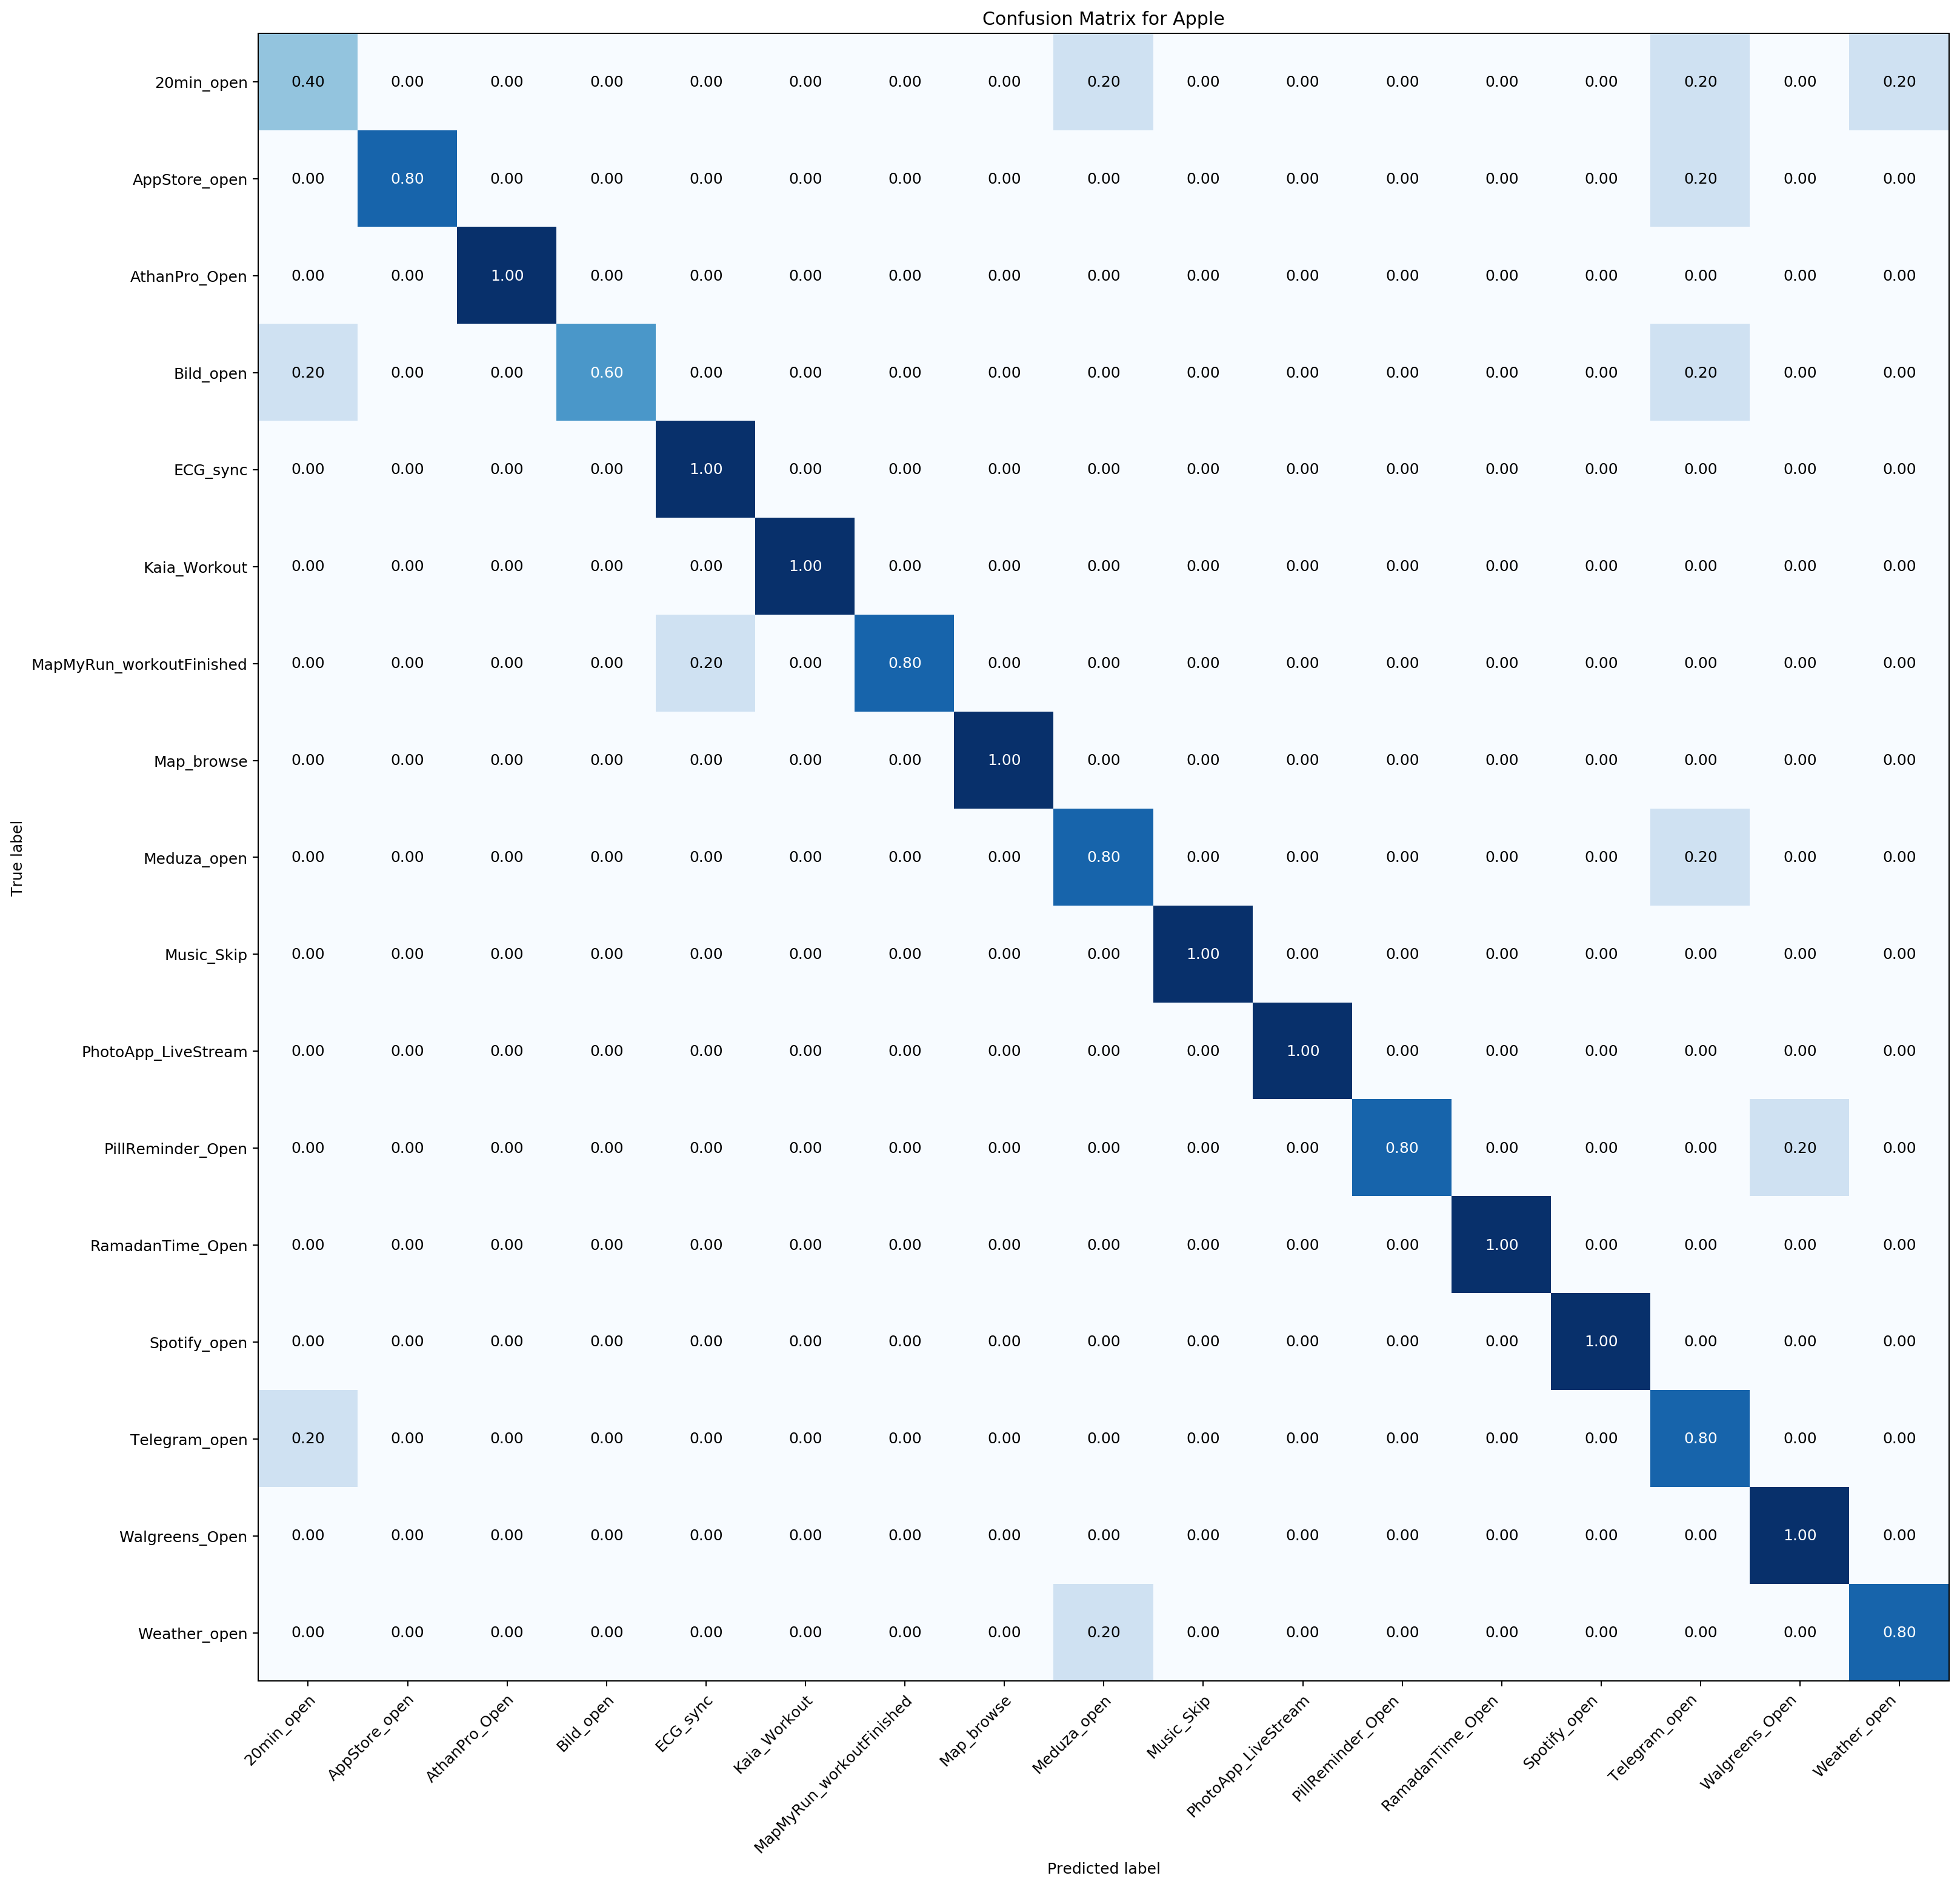

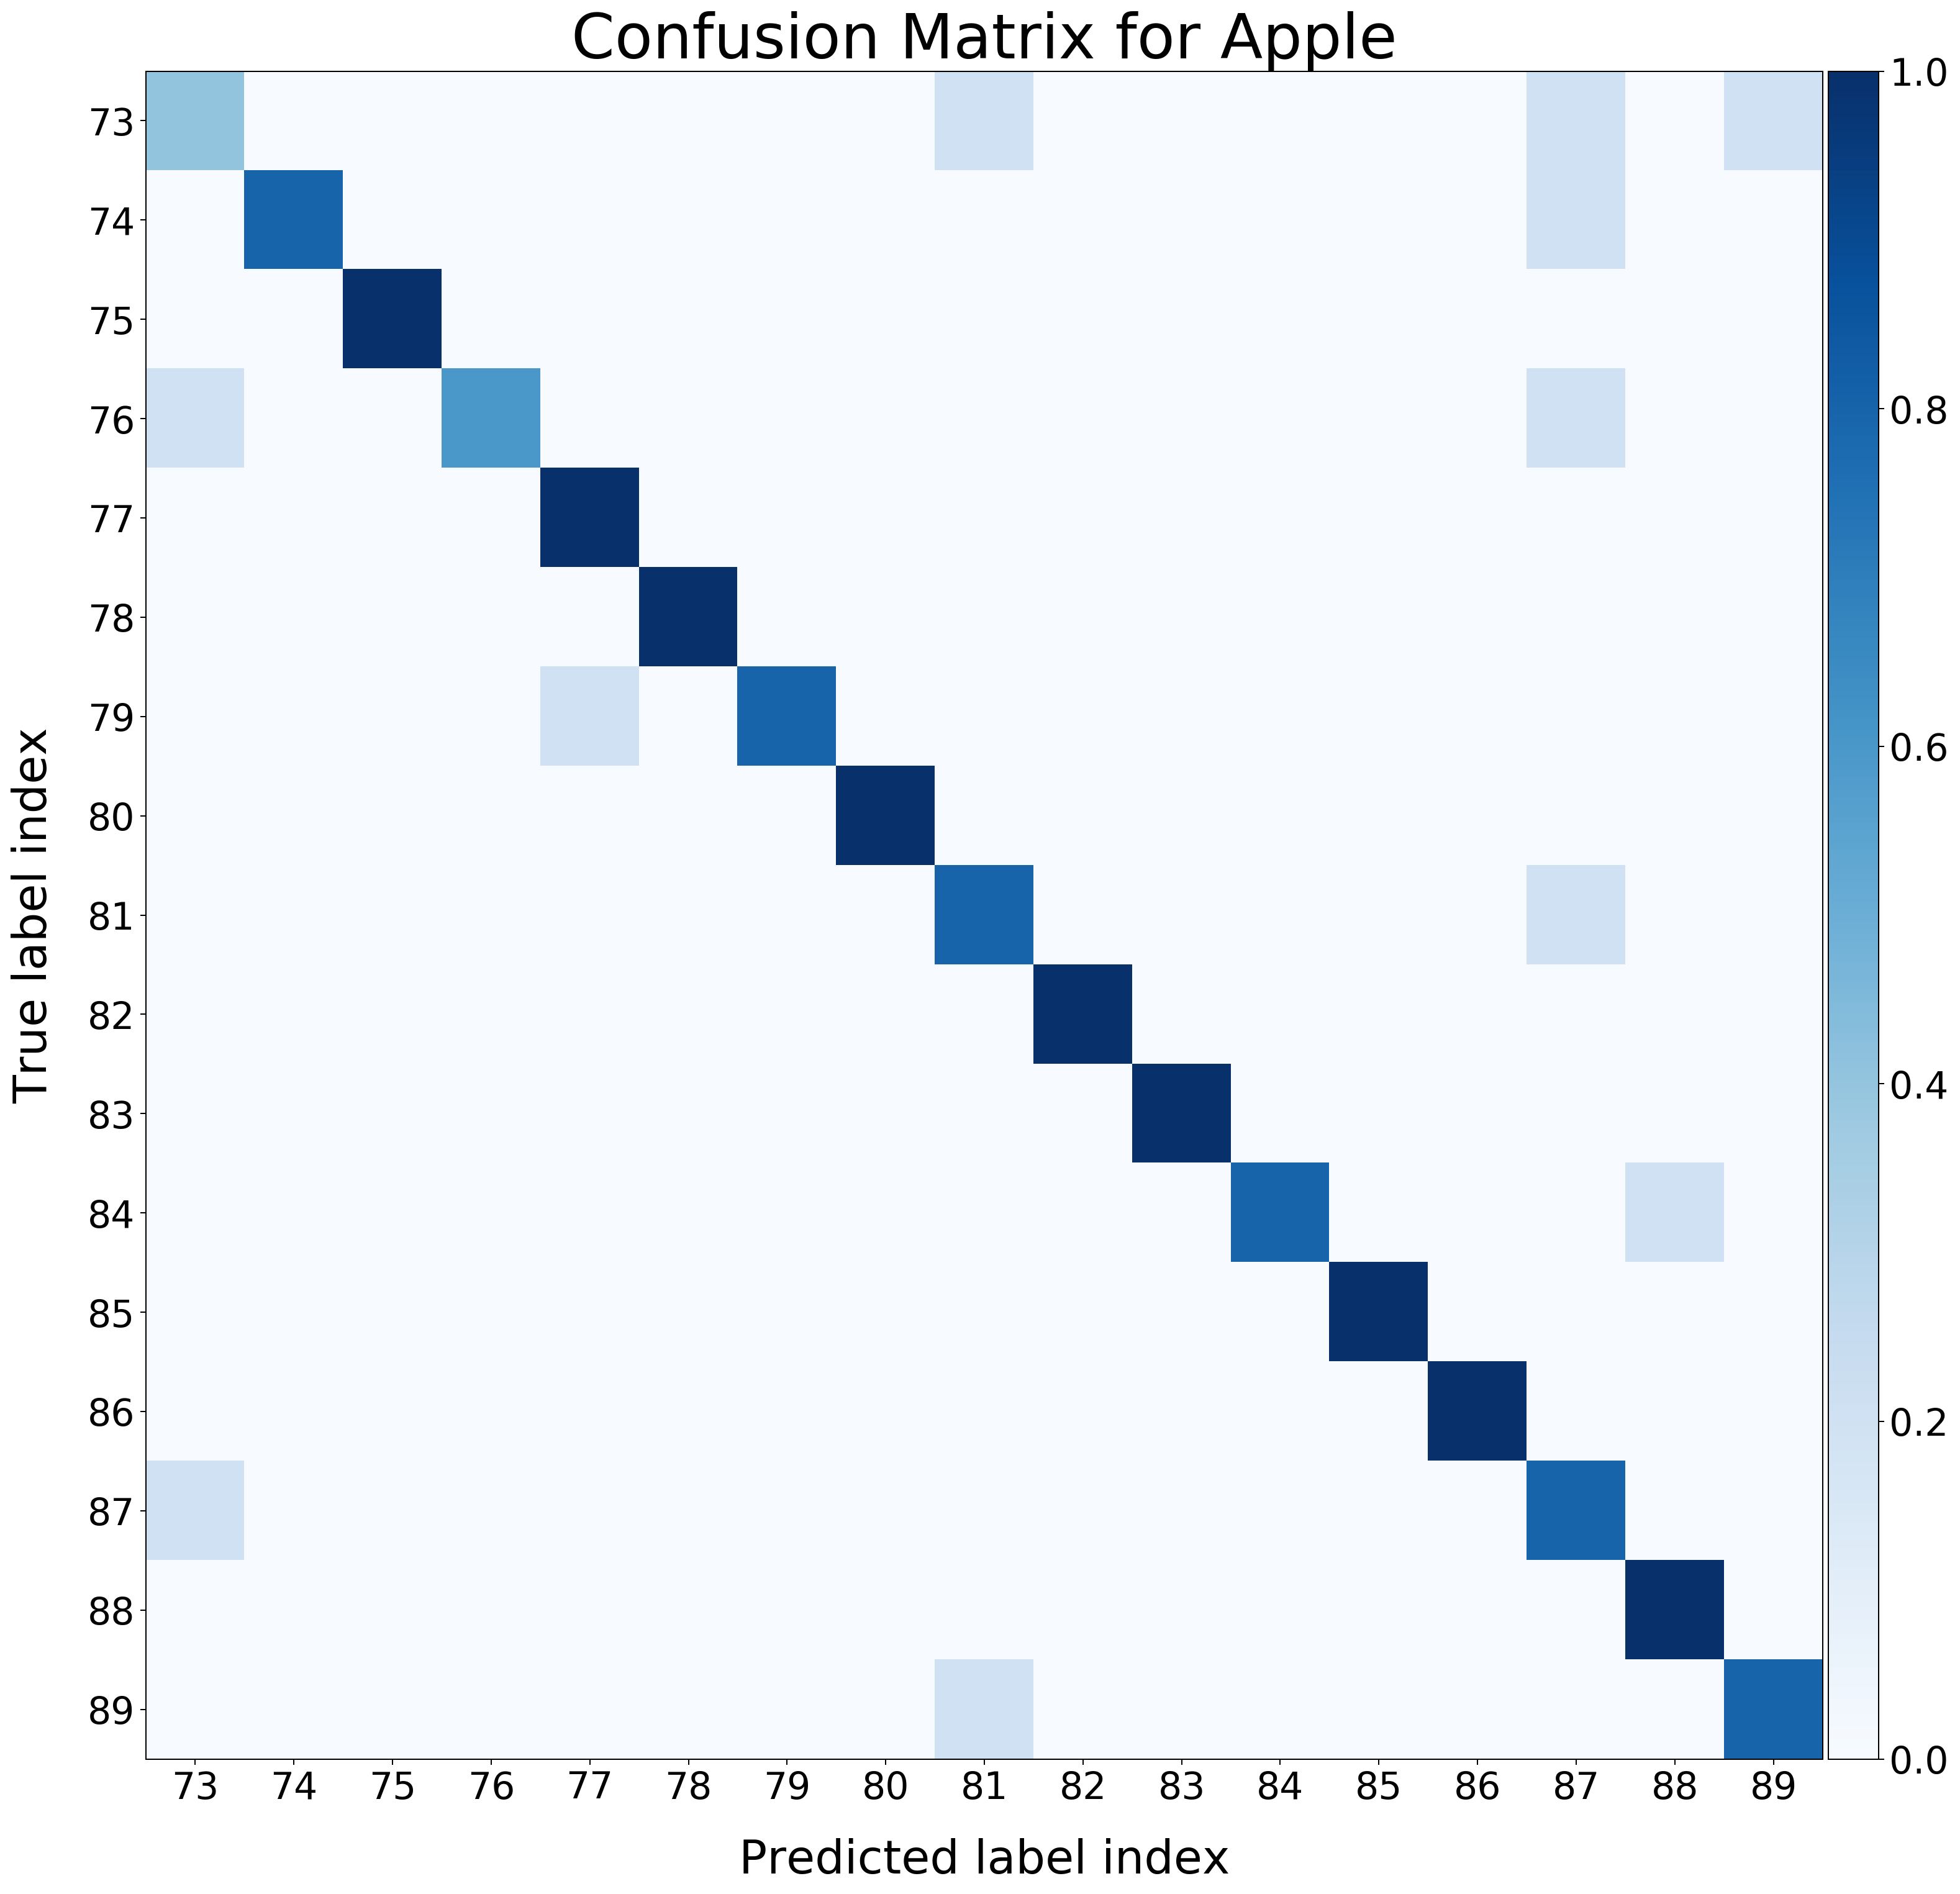

In [911]:
DATA_PATH = ["data/iwatch/batch-1/"] #, "data/huawei/open-3/", "data/huawei/open-6/"] # all
to_withdraw = find_feat_to_withdraw(DATA_PATH,  MAX_ITERATION=1)
evaluate(DATA_PATH, APP_TO_INDEX=app_to_index_2, N_SPLITS=50, TO_WITHDRAW=to_withdraw, DETAIL_PRINT=True, CM_ALL_LABEL=True, SPACING=1, TITLE="Confusion Matrix for Apple")


In [498]:
evaluate(DATA_PATH, DETAIL_PRINT=True, N_SPLITS=50, PRINT_COUNT=False)


importing data...
filtering app that does not send traffic by their length
dataset equalization per class
20 samples per category
building features and labels
feature length :  1002
building and training the model for cross validation 
Random split cross-validation: Accuracy=0.883 (+/- 0.07). 
building and training a model for confusion matrix
accuracy = 0.8588235294117647
done


### Force-stop
[Table of Content](#tc)

In [ ]:
DATA_PATH = ["data/huawei/force-stop-2/"] # all
DISCARDED_ACTION = [] 
evaluate(DATA_PATH, DISCARDED_ACTION=DISCARDED_ACTION, SHUFFLE=True, ORDER_CM_BY_SIZE=True, TITLE="")

<a id='actions'></a>
### Actions

[Table of Content](#tc)


<a id='Foursquarecityguide'></a>
#### Foursquare City Guide

In [ ]:
DATA_PATH = ["data/huawei/FoursquareCityGuide-1/"] # all
DISCARDED_ACTION = ["DiabetesM_addCarbsaddInsulin"] 
evaluate(DATA_PATH, DISCARDED_ACTION=DISCARDED_ACTION, SHUFFLE=True, N_ESTIMATOR=1000)

<a id='DiabetesM'></a>

#### DiabetesM
[Table of Content](#tc)

with both: 57_5_+-7_9%
with non_zeros only: 55_8_+-6_0%
with zeros only: 45_2_+-6_4%_95%


In [928]:
DATA_PATH = ["data/huawei/DiabetesM-1/", "data/huawei/DiabetesM-2/", "data/huawei/DiabetesM-3/", "data/huawei/DiabetesM-4/"] # all
DISCARDED_ACTION = ["DiabetesM_addCarbsaddInsulin"] 
to_withdraw = find_feat_to_withdraw(DATA_PATH)
evaluate(DATA_PATH, DETAIL_PRINT=True, TO_WITHDRAW=to_withdraw)


importing data...
filtering app that does not send traffic by their length
dataset equalization per class
building features and labels
features count :  1002

importing data...
filtering app that does not send traffic by their length
dataset equalization per class
building features and labels
features count :  72
building and training the model for cross validation 
Random split cross-validation: Accuracy=0.622 (+/- 0.093). 
building and training a model for confusion matrix
fitting duration = 0.417
prediction duration = 0.025
accuracy = 0.6176470588235294
done


Compute Precision Recall for addInsuline

In [1020]:
def precision_recall_f1_print(DATA_PATH, LABELS, TO_WITHDRAW=None, N_AVG=50, latex_table_format=False):
    precisions = []
    recalls = []
    f1s = []

    X, y, _ = evaluate(DATA_PATH, DETAIL_PRINT=False, TO_WITHDRAW=TO_WITHDRAW, RETURN_FEATURES_AND_LABELS=True)



    for _ in range(N_AVG):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
        clf = RandomForestClassifier(n_estimators=N_ESTIMATOR, random_state=RANDOM_STATE)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, labels=LABELS)
        precisions.append(p)
        recalls.append(r)
        f1s.append(f1)
    p_avg, r_avg, f1_avg =np.mean(np.column_stack(precisions), axis=1), np.mean(np.column_stack(recalls), axis=1), np.mean(np.column_stack(f1s), axis=1)
    p_std, r_std, f1_std =np.std(np.column_stack(precisions), axis=1), np.std(np.column_stack(recalls), axis=1), np.std(np.column_stack(f1s), axis=1)
    
    for i,l in enumerate(LABELS):
        print("{}: precision: {:.2f} (+/- {:.2f}), recall: {:.2f} (+/- {:.2f}), f1: {:.2f} (+/- {:.2f})".format(l,
                                                                                                                p_avg[i], p_std[i], 
                                                                                                                r_avg[i], r_std[i],
                                                                                                                f1_avg[i], f1_std[i]))
        
    return p_avg, r_avg, f1_avg
    

In [1021]:
p, r, f1 = precision_recall_f1_print(DATA_PATH, LABELS=["DiabetesM_addGlucose", "DiabetesM_addInsulin"], TO_WITHDRAW=TO_WITHDRAW)

features count :  72
DiabetesM_addGlucose: precision: 0.59 (+/- 0.08), recall: 0.54 (+/- 0.09), f1: 0.56 (+/- 0.07)
DiabetesM_addInsulin: precision: 0.77 (+/- 0.08), recall: 0.72 (+/- 0.07), f1: 0.74 (+/- 0.05)


<a id = "endomondo"></a>
#### Endomondo

In [ ]:
DATA_PATH = ["data/huawei/Endomondo-1/"] # all
evaluate(DATA_PATH, figsize=(5,5))

<a id='lifesum'></a>
#### Lifesum
[Table of Content](#tc)

In [ ]:
DATA_PATH = ["data/huawei/Lifesum-1/"] # all
evaluate(DATA_PATH, figsize=(5,5))

<a id="all_action_within_apps"></a>
#### All action within apps
[Table of Content](#tc)


importing data...
filtering app that does not send traffic by their length
dataset equalization per class
building features and labels
features count :  1002

importing data...
filtering app that does not send traffic by their length
dataset equalization per class
building features and labels
features count :  383
building and training the model for cross validation 
Random split cross-validation: Accuracy=0.723 (+/- 0.071). 
building and training a model for confusion matrix
fitting duration = 0.413
prediction duration = 0.032
accuracy = 0.7289156626506024
Saved image ./plots/all_within_app_index.png
done


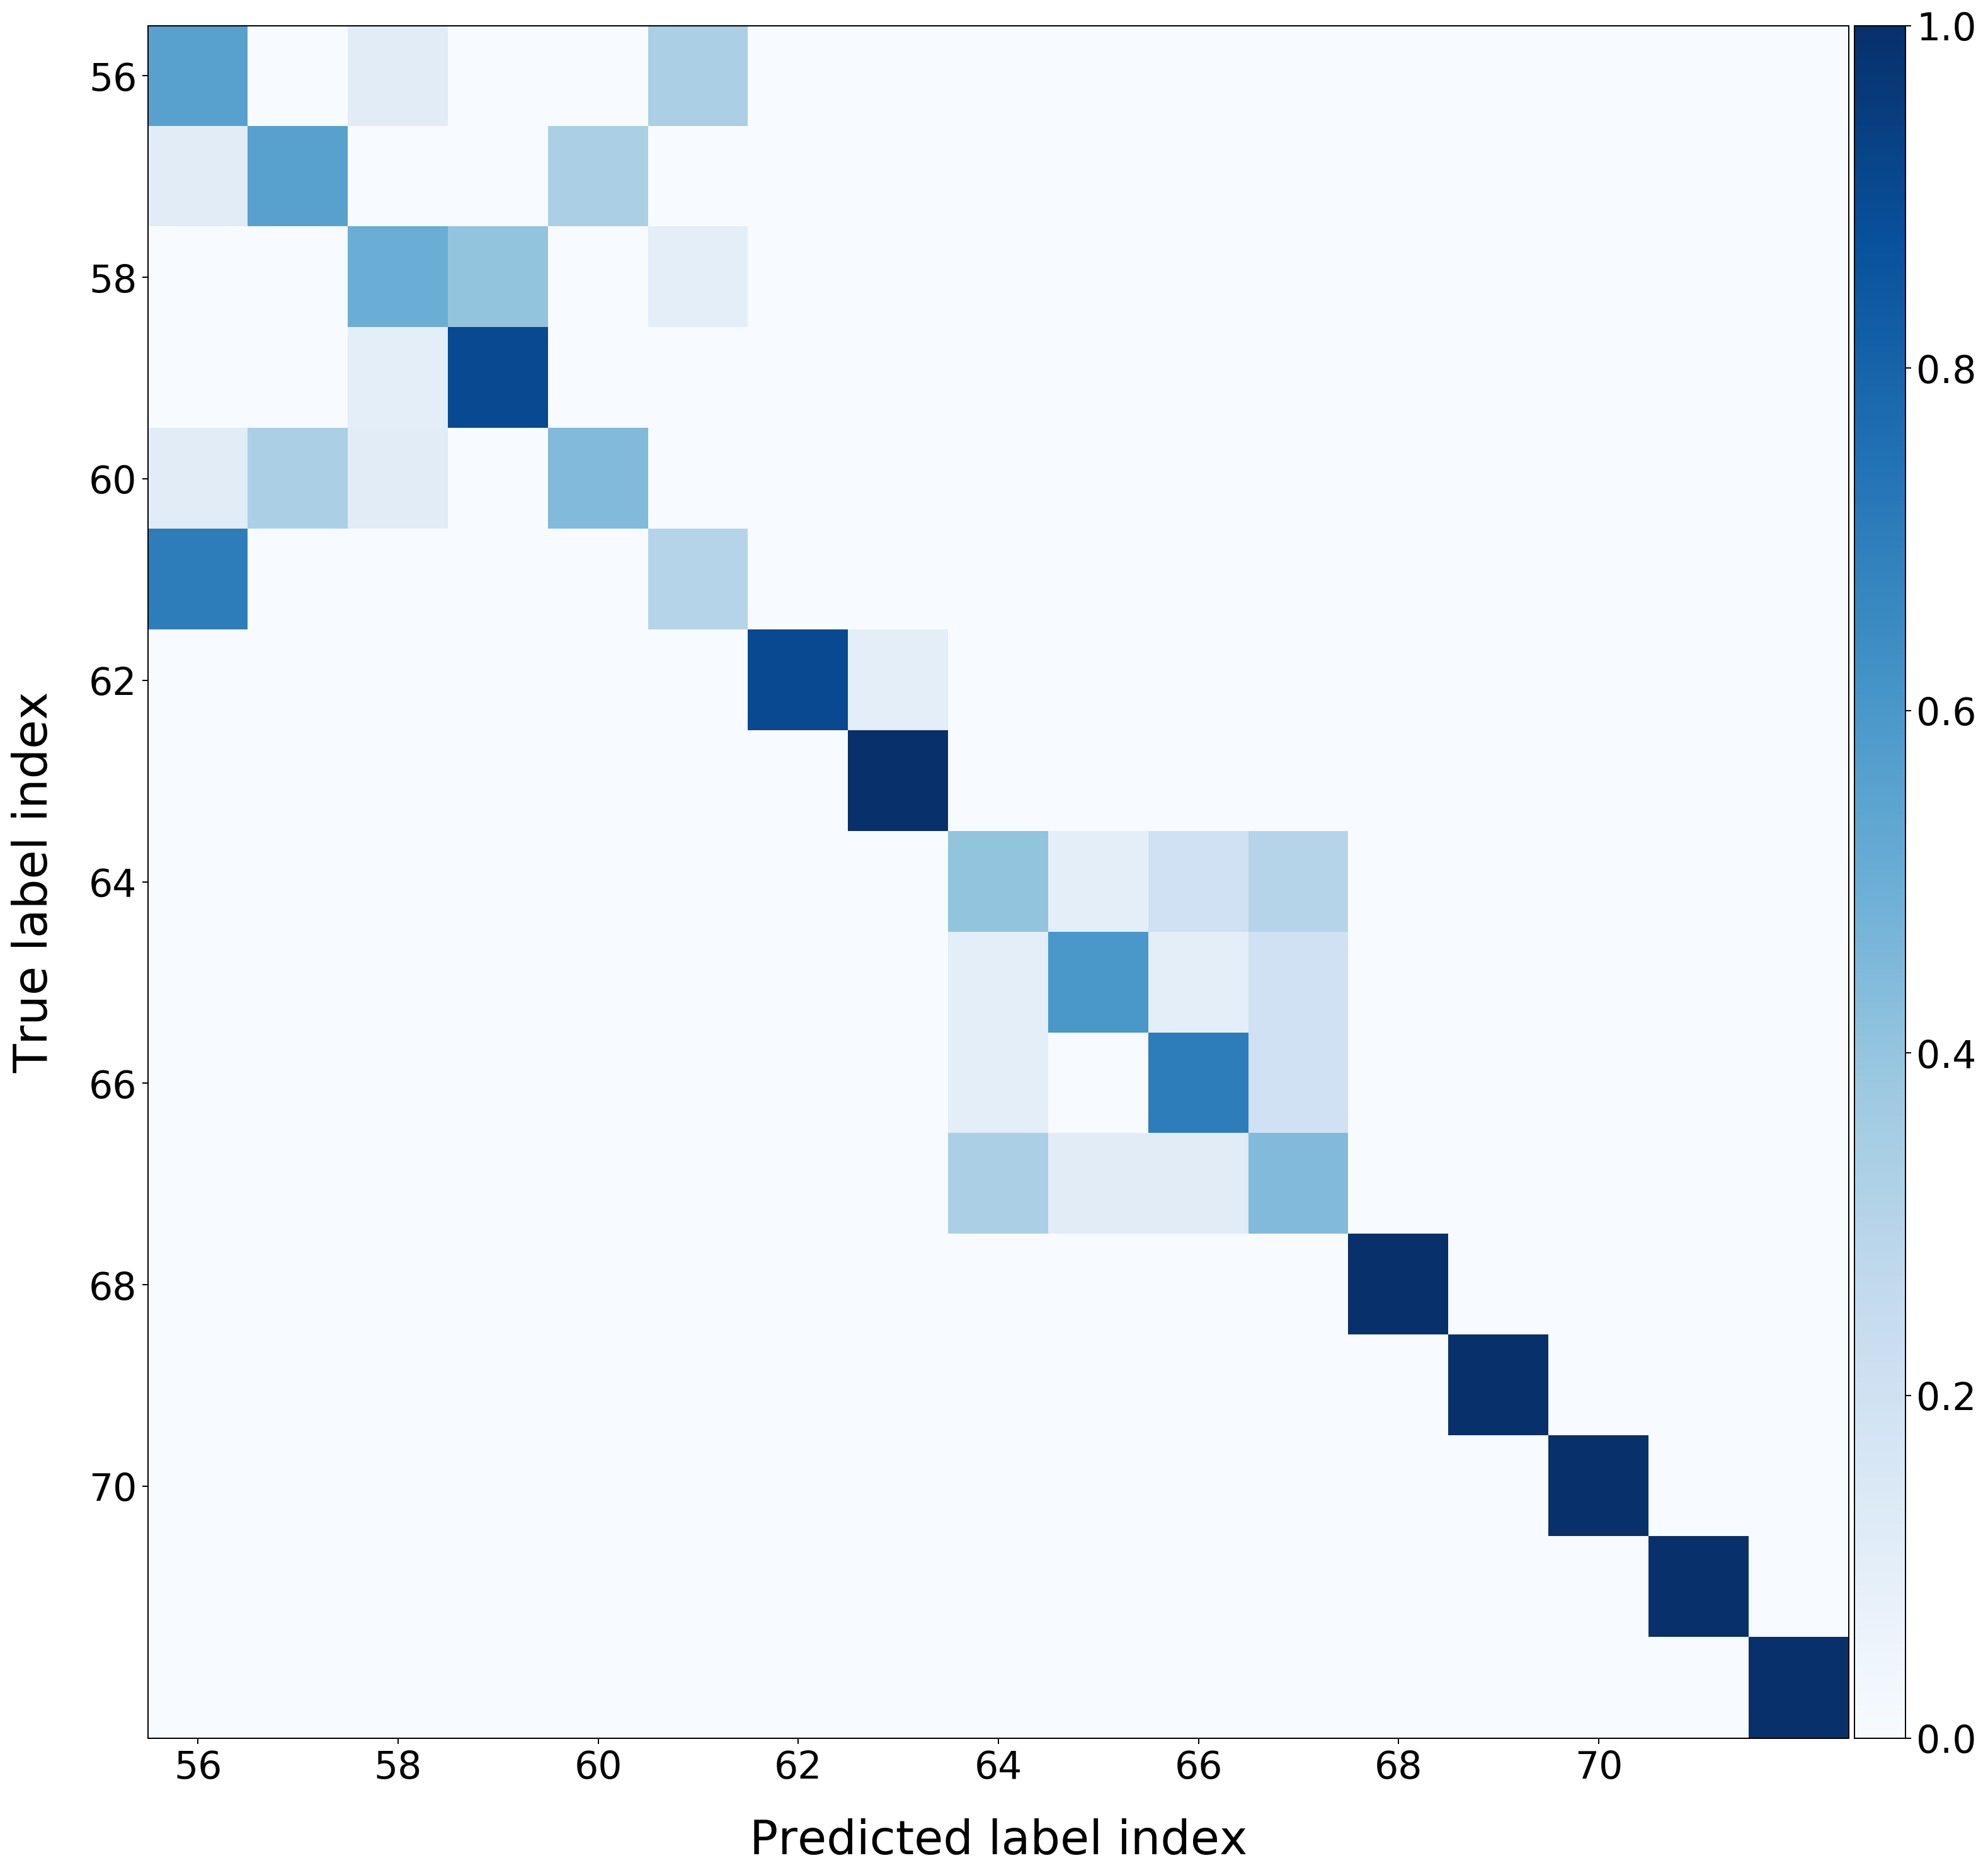

In [803]:
DATA_PATH = ["data/huawei/Endomondo-1/", "data/huawei/DiabetesM-4/",
             "data/huawei/FoursquareCityGuide-1/", "data/huawei/HealthyRecipes-1/",
             "data/huawei/Lifesum-1/", "data/huawei/Playstore-1/"]
to_withdraw = find_feat_to_withdraw(DATA_PATH,  MAX_ITERATION=1)
evaluate(DATA_PATH, figname="all_within_app", TITLE= "", TO_WITHDRAW=to_withdraw,
         DETAIL_PRINT=True, N_SPLITS=50, APP_TO_INDEX=APP_TO_INDEX, CM_ALL=True, SKIPPING = 1)

### Focus on addInsuline action

In [613]:
DATA_PATH = ["data/huawei/DiabetesM-1/", "data/huawei/DiabetesM-2/", "data/huawei/DiabetesM-3/", "data/huawei/DiabetesM-4/"] # all
TO_MERGE = [["DiabetesM_addCal", "DiabetesM_addCarbs", "DiabetesM_addFat", "DiabetesM_addProt", "DiabetesM_addProt", "DiabetesM_addGlucose"]] 
evaluate(DATA_PATH, TO_MERGE=TO_MERGE, figsize=(8,8), PRINT_COUNT=True, N_ESTIMATOR=1000)


importing data...
filtering app that does not send traffic by their length
merging events

class event count
LEO-BX9: DiabetesM_addInsulin - 138
LEO-BX9: NoApp_AddcaAddcaAddfaAddglAddpr - 95
Nb class =  2

dataset equalization per class

class event count after equalization
LEO-BX9: DiabetesM_addInsulin - 95
LEO-BX9: NoApp_AddcaAddcaAddfaAddglAddpr - 95
Nb class =  2

building features and labels
features count :  1002
building and training the model for cross validation 
Random split cross-validation: Accuracy=0.883 (+/- 0.082). 
building and training a model for confusion matrix
fitting duration = 1.289
prediction duration = 0.084
accuracy = 0.8333333333333334
done


In [ ]:
precisions = []
recalls = []

In [ ]:
# Merge further more

DATA_PATH = ["data/huawei/DiabetesM-1/", "data/huawei/DiabetesM-2/", "data/huawei/DiabetesM-3/", "data/huawei/DiabetesM-4/"] # all
TO_MERGE = [["DiabetesM_addCal", "DiabetesM_addCarbs", "DiabetesM_addFat", "DiabetesM_addProt", "DiabetesM_addGlucose"]] 

for _ in range(10):
    y_test, y_pred = evaluate(DATA_PATH, TO_MERGE=TO_MERGE, PRINT_COUNT=False, N_ESTIMATOR=100, RETURN_PRED= True)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, labels=["DiabetesM_addInsulin"])
    precisions += precision.tolist()
    recalls += recall.tolist()

In [ ]:
print("precisions_avg={} recall_avg={}".format(sum(precisions)/len(precisions),sum(recalls)/len(recalls)))
print("precision min: {} - max {}".format(min(precisions), max(precisions)))
print("recall_min: {} - max {}".format(min(precisions), max(precisions)))

Way to improve:
    - Make the dataset balanced when merging app (It could be that a class is much more present than other classes in the train and the in test it changes).
    - Use most prunning to isolate most important features and discard other features
    - Change the model to 1d convalution

<a id = 'all'></a>
### All In-App together
[Table of Content](#tc)


importing data...
filtering app that does not send traffic by their length
dataset equalization per class
samples per classes: 39
building features and labels
features count : 1002

importing data...
filtering app that does not send traffic by their length
dataset equalization per class
samples per classes: 39
building features and labels
features count : 384
building and training the model for cross validation 
Random split cross-validation: Accuracy=0.723 (+/- 0.077). 
building and training a model for confusion matrix
fitting duration = 0.432
prediction duration = 0.033
accuracy = 0.7530120481927711
Saved image ./plots/all_inApp_action_index.png
done


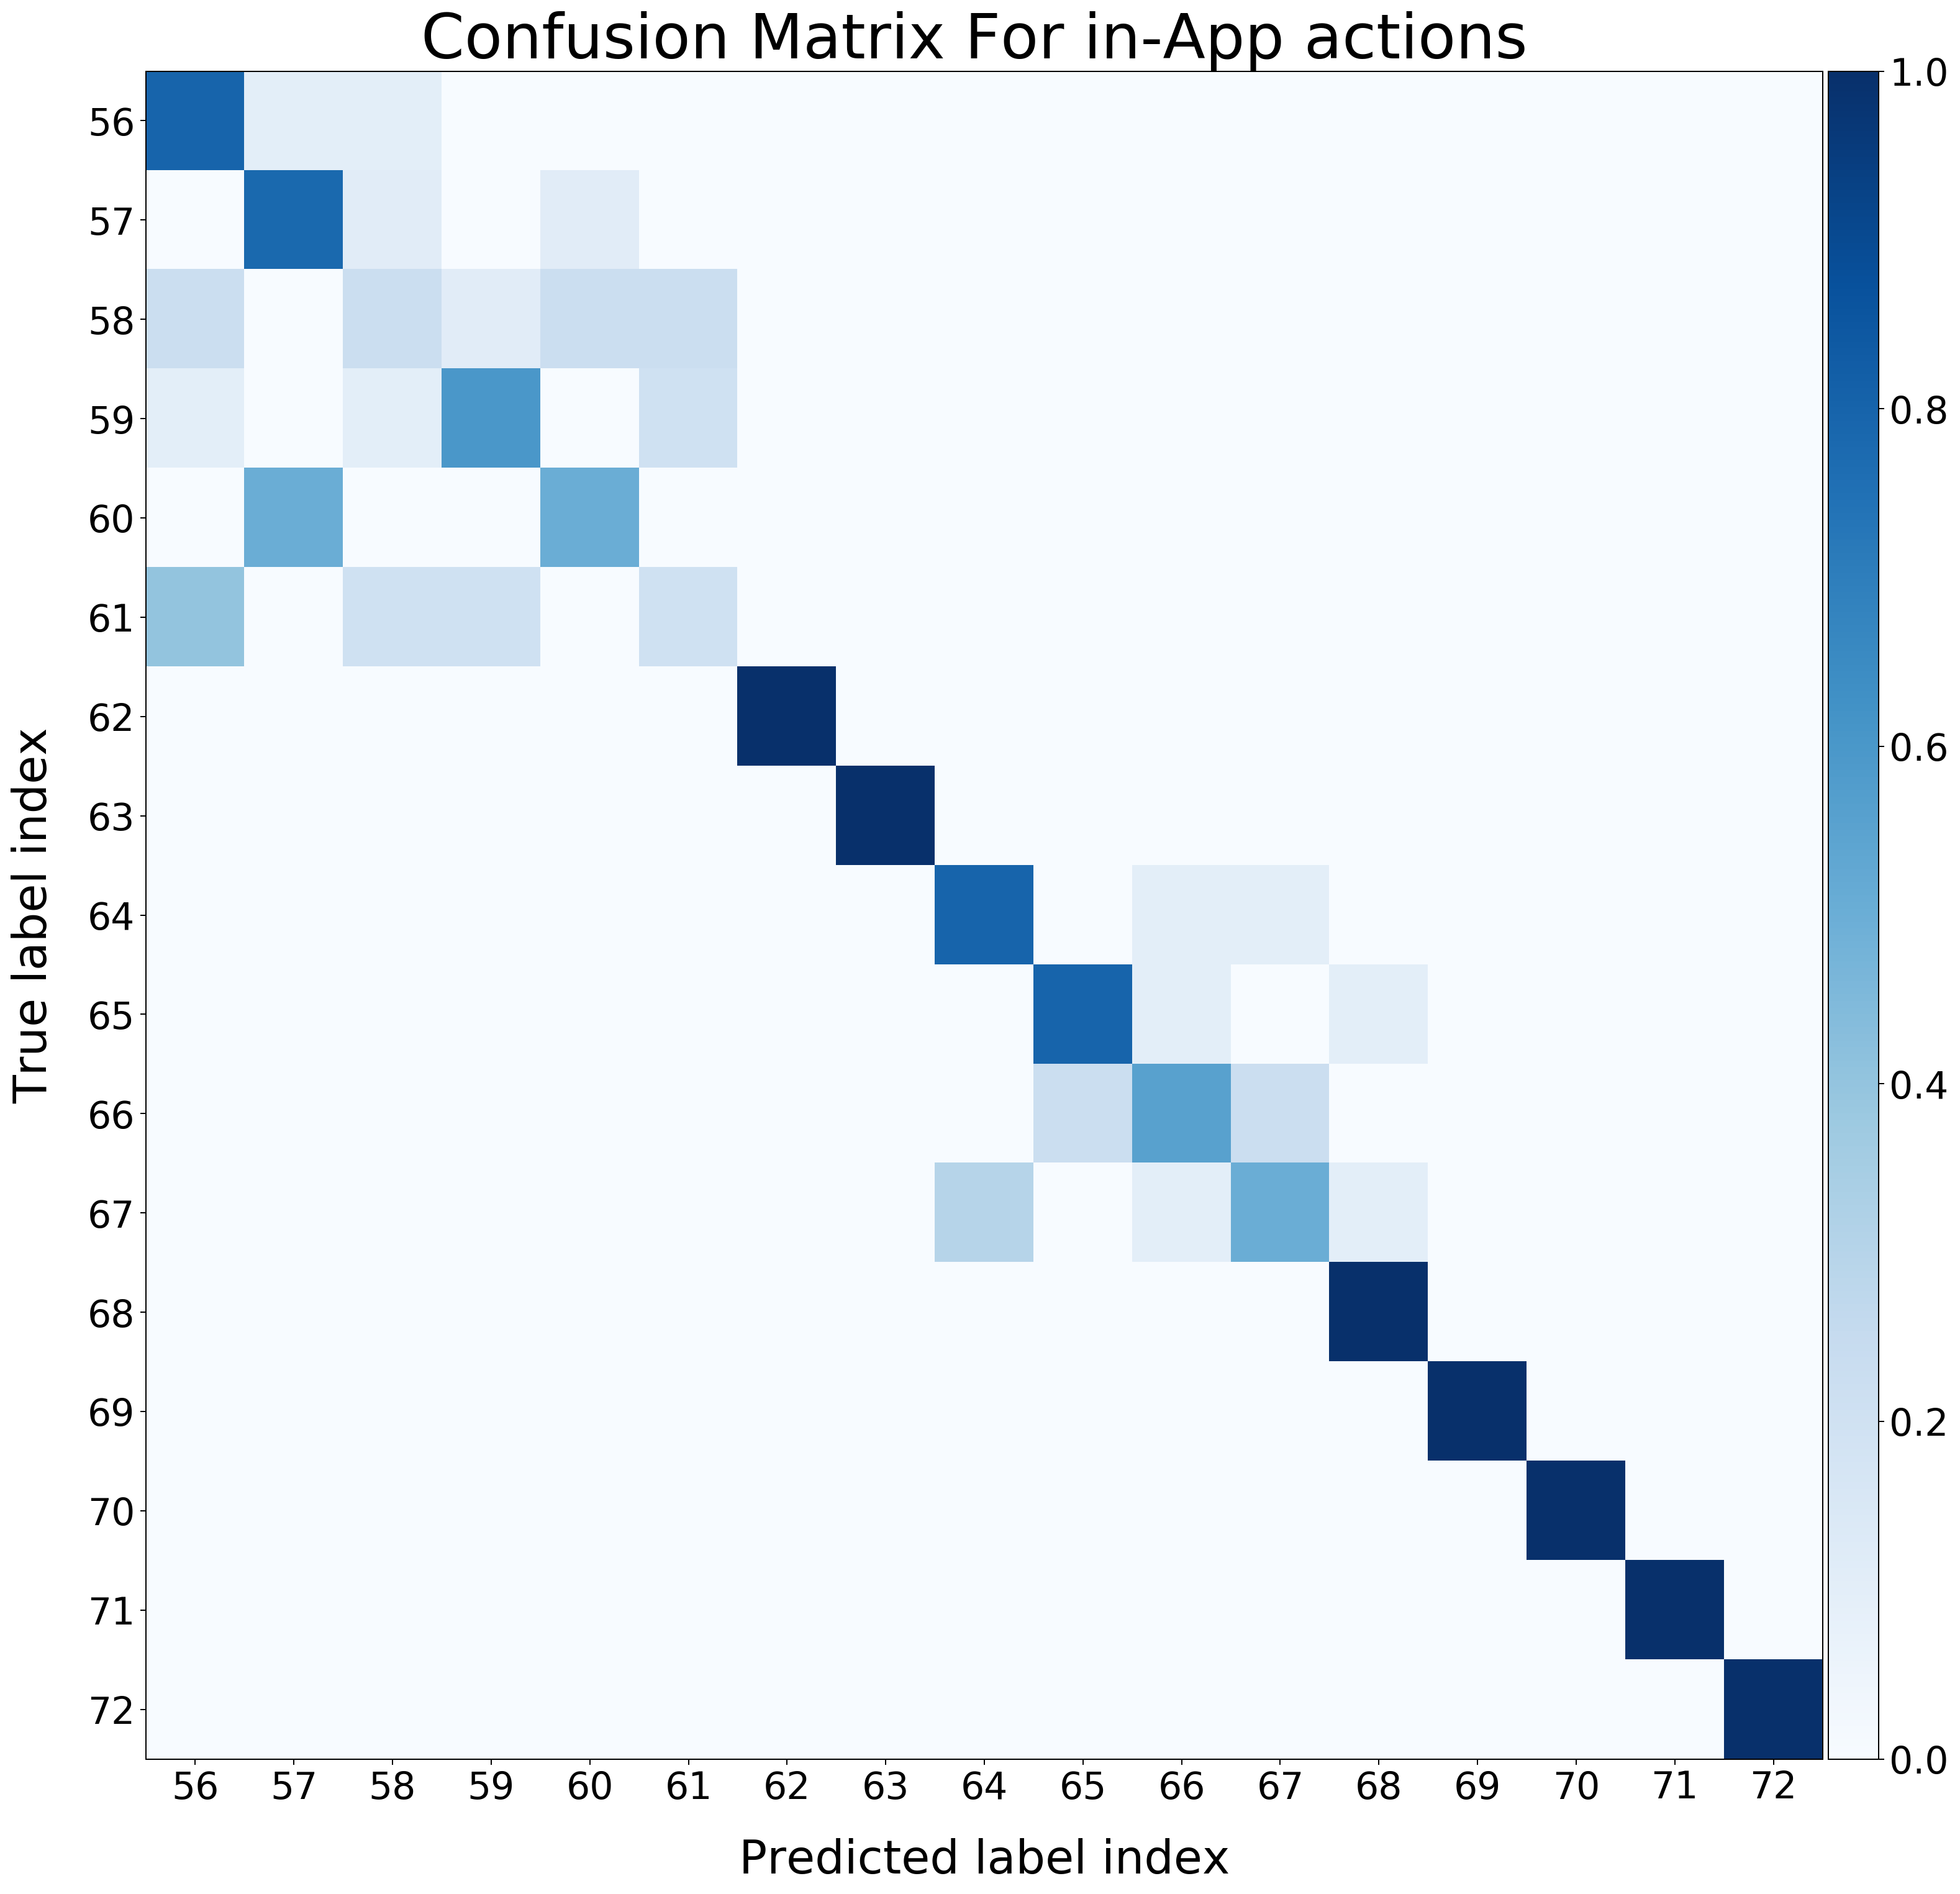

In [1080]:
DATA_PATH = ["data/huawei/Endomondo-1/", "data/huawei/DiabetesM-2/",
             "data/huawei/DiabetesM-3/", "data/huawei/DiabetesM-4/",
             "data/huawei/FoursquareCityGuide-1/", "data/huawei/HealthyRecipes-1/",
             "data/huawei/Lifesum-1/", "data/huawei/Playstore-1/"]
to_withdraw = find_feat_to_withdraw(DATA_PATH)

evaluate(DATA_PATH, figname = "all_inApp_action", TITLE="Confusion Matrix For in-App actions ", TO_WITHDRAW=to_withdraw, N_ESTIMATOR=200, DETAIL_PRINT=True, APP_TO_INDEX=APP_TO_INDEX, SPACING=1)

In [1081]:
evaluate(DATA_PATH, figname = "all_inApp_action", TITLE="Confusion Matrix For in-App actions ", N_ESTIMATOR=200, N_SPLITS=50, DETAIL_PRINT=True, APP_TO_INDEX=False, SPACING=1)


importing data...
filtering app that does not send traffic by their length
dataset equalization per class
samples per classes: 39
building features and labels
features count : 1002
building and training the model for cross validation 
Random split cross-validation: Accuracy=0.710 (+/- 0.065). 
building and training a model for confusion matrix
fitting duration = 0.488
prediction duration = 0.043
accuracy = 0.7108433734939759
done


<a id = 'all'></a>
### All acition all together
[Table of Content](#tc)

In [1476]:
DATA_PATH = ["data/huawei/Endomondo-1/", "data/huawei/DiabetesM-2/",
             "data/huawei/DiabetesM-3/", "data/huawei/DiabetesM-4/",
             "data/huawei/FoursquareCityGuide-1/", "data/huawei/HealthyRecipes-1/",
             "data/huawei/Lifesum-1/", "data/huawei/Playstore-1/", "data/huawei/open-3/"]
events = evaluate(DATA_PATH, RETURN_FILTIRED=True, CM_NO_LABELS=True)
all_actions = get_all_actions(events)

In [1477]:
print("There are {} actions in the matrix. Bellow is the list of all the actions".format(len(all_actions)))
print()
print(all_actions)

There are 55 actions in the matrix. Bellow is the list of all the actions

{'Lifesum_addWater', 'Strava_open', 'Weather_open', 'Qardio_open', 'Shazam_open', 'MapMyRun_open', 'FitWorkout_open', 'Maps_open', 'Running_open', 'FitBreathe_open', 'Lifesum_open', 'KeepNotes_open', 'FindMyPhone_open', 'FoursquareCityGuide_open', 'Spotify_open', 'DiabetesM_addFat', 'Lifesum_addFood', 'DiabetesM_addCarbs', 'FoursquareCityGuide_coffee', 'DiabetesM_addInsulin', 'Endomondo_browseMap', 'Fit_open', 'DiabetesM_open', 'Meduza_open', 'FoursquareCityGuide_fun', 'FoursquareCityGuide_food', 'AppInTheAir_open', 'Outlook_open', 'FoursquareCityGuide_nightlife', 'Calm_open', 'Glide_open', 'HealthyRecipes_researchRecipy', 'FoursquareCityGuide_shopping', 'Camera_open', 'WashPost_open', 'DiabetesM_addCal', 'Translate_open', 'Bring_open', 'SalatTime_open', 'Krone_open', 'SleepTracking_open', 'DCLMRadio_open', 'Endomondo_run', 'PlayStore_open', 'DiabetesM_addGlucose', 'SmokingLog_open', 'Endomondo_open', 'ChinaDail

In [1478]:
all_actions = list(all_actions)


importing data...
filtering app that does not send traffic by their length
dataset equalization per class
samples per classes: 38
building features and labels
features count : 1002

importing data...
filtering app that does not send traffic by their length
dataset equalization per class
samples per classes: 38
building features and labels
features count : 509
building and training the model for cross validation 
Random split cross-validation: Accuracy=0.887 (+/- 0.027). 
building and training a model for confusion matrix
fitting duration = 1.247
prediction duration = 0.086
accuracy = 0.9005736137667304
Saved image ./plots/all_action_together_nolabels.png
Saved image ./plots/all_action_together_index.png
done


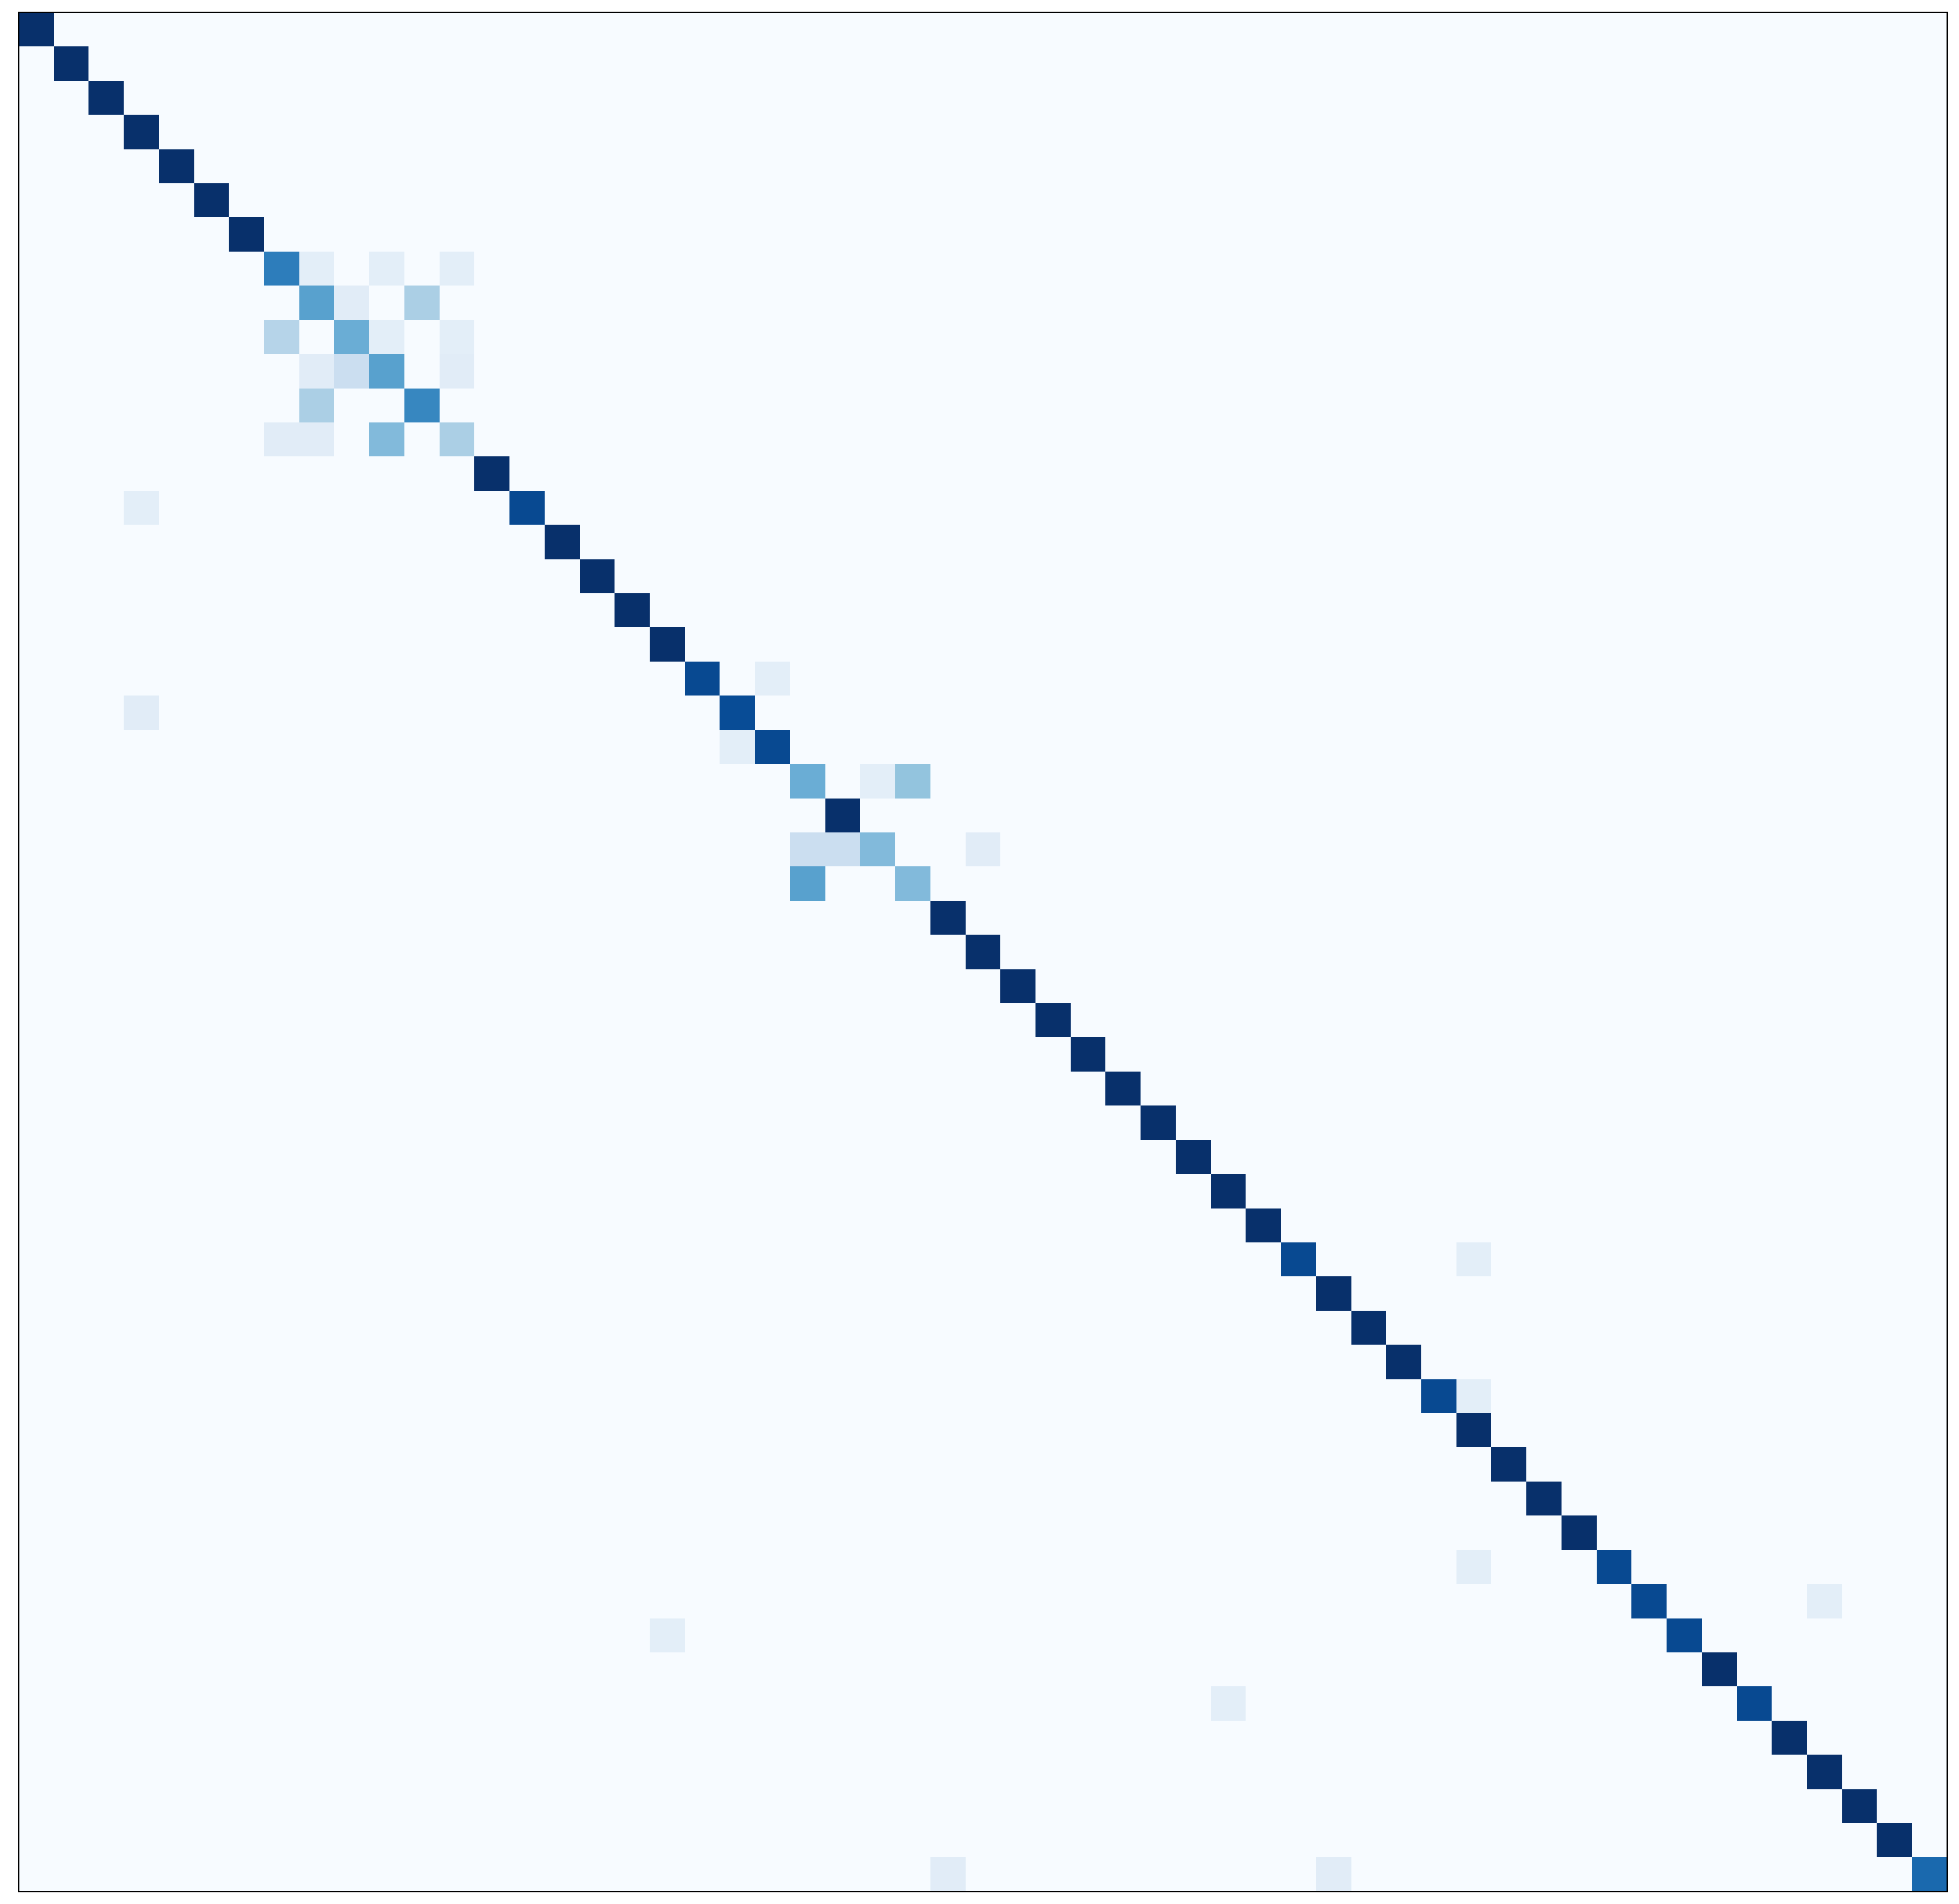

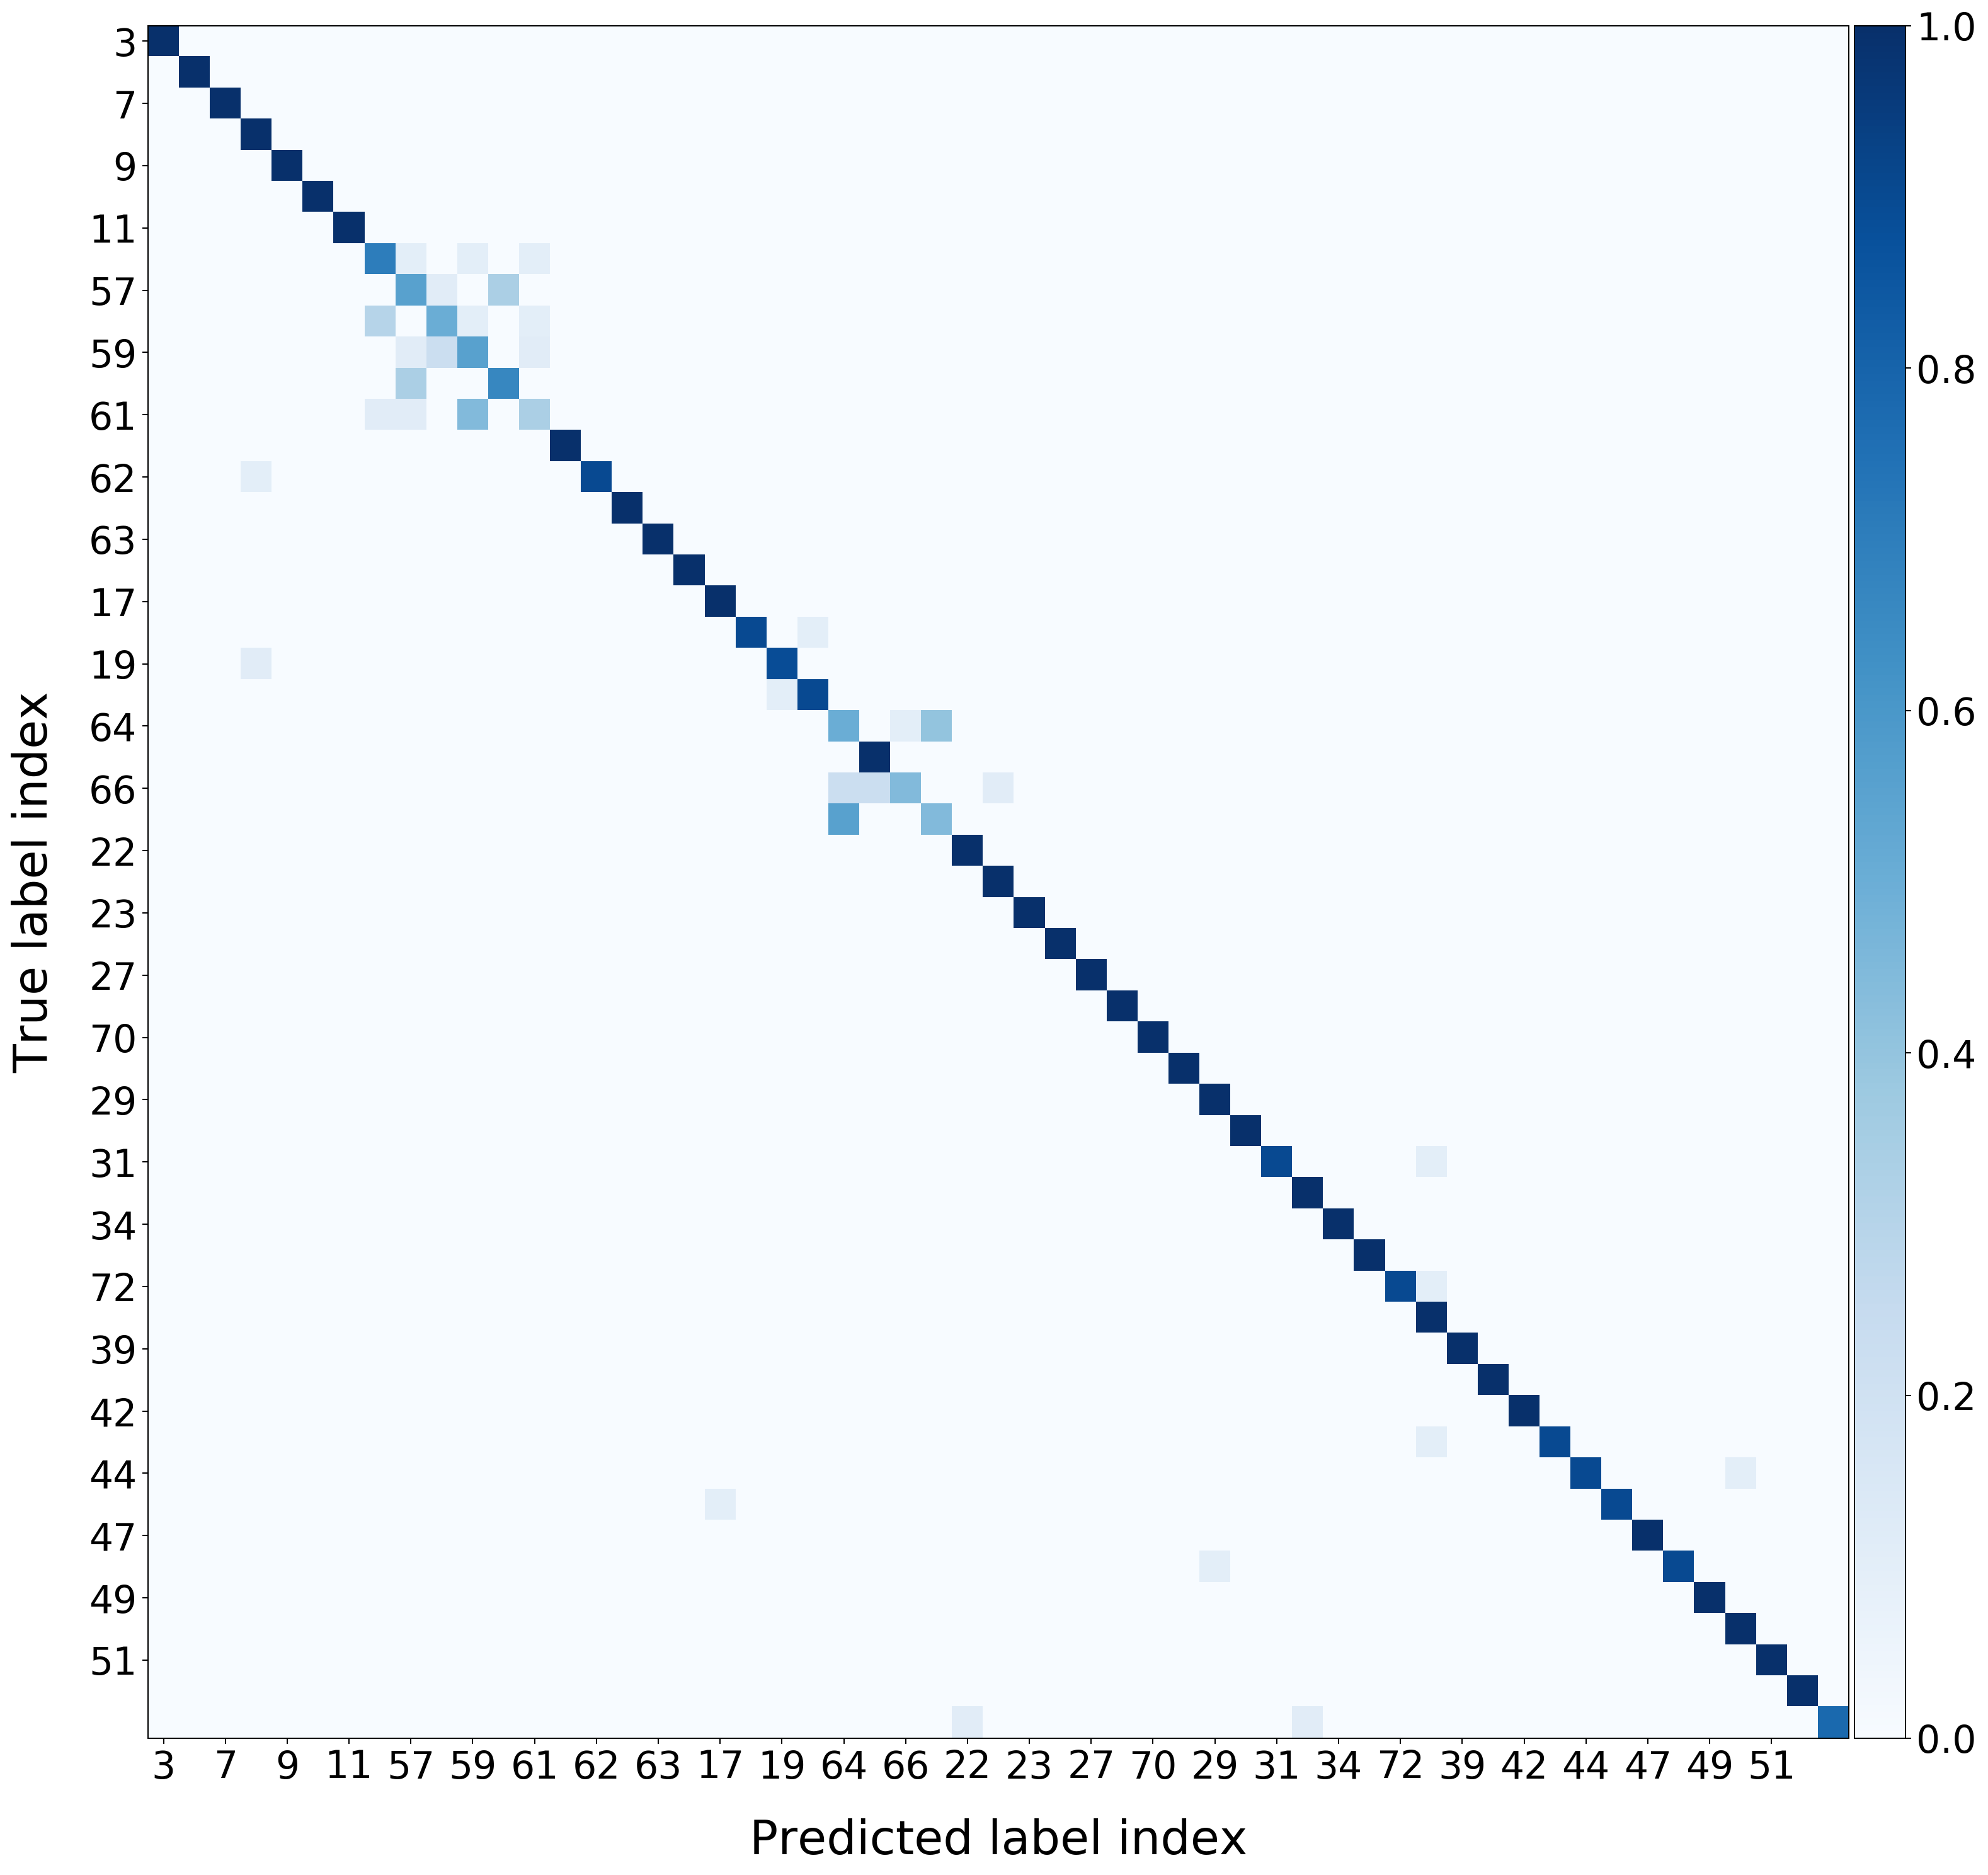

In [1479]:
to_withdraw = find_feat_to_withdraw(DATA_PATH)
evaluate(DATA_PATH, CM_NO_LABELS=True, TITLE="", TO_WITHDRAW=to_withdraw, 
         figname = "all_action_together", DETAIL_PRINT=True, N_SPLITS=200,
         APP_TO_INDEX=APP_TO_INDEX)
         

In [1047]:
" & ".join(np.sort(np.array(['c', 'a', 'd'])))

'a & c & d'

In [1062]:
"{:.2f}".format(3243.3233)

'3243.32'

In [1065]:
def precision_recall_f1_print(DATA_PATH, LABELS, TO_WITHDRAW=None, N_AVG=50, latex_table_format=False, sort_by='f1'):
    
    def format_(avg, std):
        return "{:.2f} (+/- {:.2f})".format(avg *100, std*100 * 2)
    
    precisions = []
    recalls = []
    f1s = []

    X, y, _ = evaluate(DATA_PATH, DETAIL_PRINT=False, TO_WITHDRAW=TO_WITHDRAW, RETURN_FEATURES_AND_LABELS=True)



    for _ in range(N_AVG):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
        clf = RandomForestClassifier(n_estimators=N_ESTIMATOR, random_state=RANDOM_STATE)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, labels=LABELS)
        precisions.append(p)
        recalls.append(r)
        f1s.append(f1)
    p_avg, r_avg, f1_avg =np.mean(np.column_stack(precisions), axis=1), np.mean(np.column_stack(recalls), axis=1), np.mean(np.column_stack(f1s), axis=1)
    p_std, r_std, f1_std =np.std(np.column_stack(precisions), axis=1), np.std(np.column_stack(recalls), axis=1), np.std(np.column_stack(f1s), axis=1)
    
    if sort_by == 'f1':
        sorted_idx = np.argsort(f1_avg)
    if sort_by == 'alphabetic':
        sorted_idx = np.argsort(LABELS)
        
    p_avg, r_avg, f1_avg = p_avg[sorted_idx], r_avg[sorted_idx], f1_avg[sorted_idx]
    p_std, r_std, f1_std = p_std[sorted_idx], r_std[sorted_idx], f1_std[sorted_idx] 
    LABELS = np.array(LABELS)[sorted_idx]
    
    for i,l in enumerate(LABELS):
        print("{}: precision: {:.3f} (+/- {:.3f}), recall: {:.3f} (+/- {:.3f}), f1: {:.3f} (+/- {:.3f})".format(l,
                                                                                                                p_avg[i], p_std[i], 
                                                                                                                r_avg[i], r_std[i],
                                                                                                                f1_avg[i], f1_std[i]))
    if latex_table_format:
        str_ = ""
        for i,l in enumerate(LABELS):
            app, act = l.split("_")[0], l.split("_")[1] 
            str_ += " & ".join([app, act, 
                     format_(f1_avg[i], f1_std[i]),
                     format_(p_avg[i], p_std[i]),
                     format_(r_avg[i], r_std[i]),
                     
                    ]) + "\\\\\n"         
        print("\n" + str_)
        
    return p_avg, r_avg, f1_avg
    

In [1066]:
precision_recall_f1_print(DATA_PATH, TO_WITHDRAW=TO_WITHDRAW, LABELS=all_actions, latex_table_format=True, N_AVG=200)

FoursquareCityGuide_coffee: precision: 0.330 (+/- 0.143), recall: 0.306 (+/- 0.141), f1: 0.308 (+/- 0.125)
FoursquareCityGuide_nightlife: precision: 0.335 (+/- 0.142), recall: 0.301 (+/- 0.144), f1: 0.309 (+/- 0.130)
FoursquareCityGuide_fun: precision: 0.345 (+/- 0.133), recall: 0.351 (+/- 0.145), f1: 0.340 (+/- 0.124)
DiabetesM_addProt: precision: 0.395 (+/- 0.155), recall: 0.321 (+/- 0.142), f1: 0.343 (+/- 0.135)
DiabetesM_addFat: precision: 0.373 (+/- 0.143), recall: 0.344 (+/- 0.136), f1: 0.350 (+/- 0.123)
DiabetesM_addGlucose: precision: 0.422 (+/- 0.149), recall: 0.370 (+/- 0.145), f1: 0.381 (+/- 0.121)
FoursquareCityGuide_food: precision: 0.410 (+/- 0.127), recall: 0.440 (+/- 0.148), f1: 0.415 (+/- 0.117)
DiabetesM_addCal: precision: 0.457 (+/- 0.097), recall: 0.512 (+/- 0.152), f1: 0.472 (+/- 0.104)
DiabetesM_addInsulin: precision: 0.738 (+/- 0.117), recall: 0.764 (+/- 0.133), f1: 0.742 (+/- 0.094)
DiabetesM_addCarbs: precision: 0.751 (+/- 0.113), recall: 0.783 (+/- 0.140), f1:

(array([0.3295686 , 0.33470064, 0.34488393, 0.39528585, 0.37321281,
        0.42220973, 0.40986903, 0.45678469, 0.73849079, 0.75097094,
        0.88492352, 0.81226837, 0.86752267, 0.93591739, 0.86066318,
        0.83942352, 0.8616915 , 0.99680934, 0.96563492, 0.86983329,
        0.97447854, 0.93473737, 0.98088258, 0.99245581, 0.97177435,
        0.99167424, 0.99172348, 0.93517842, 0.99300505, 0.96639323,
        0.97095455, 0.93025058, 0.95076641, 0.99202525, 0.9279016 ,
        0.95646212, 0.93171737, 0.98192317, 0.95724495, 0.96779293,
        1.        , 0.96887374, 0.9995    , 0.99063131, 0.95059848,
        0.95019697, 0.96387179, 0.99859091, 0.99813636, 0.99577273,
        0.98391667, 0.9995    , 0.99045455, 0.99131818, 1.        ]),
 array([0.30572222, 0.30133333, 0.35127778, 0.32055556, 0.34422222,
        0.37016667, 0.43966667, 0.51188889, 0.76383333, 0.78283333,
        0.77272222, 0.939     , 0.91083333, 0.85366667, 0.93672222,
        0.98244444, 0.96494444, 0.84016667, 0.

<a id='transferability'></a>
## PART IV - Transferability
[Table of content](#tc)

<a id='huawei_fossil_train_test'></a>
### Huawei and Fossil both in train and test

Methodology: remove actions that are not common in both watches, balance data across watch and actions to be sure the 50% of the data on the train are coming from huaweiwatch and the other 50% from Fossil per class. Same for the test data. Mix all of it and separate train and test when the data is mixed. 

In [ ]:
metrics.accuracy_score(

In [ ]:
N_ESTIMATOR = 100
REPEAT = 50
RANDOM_STATE = 42

DATA_PATH = ["data/huawei/open-6/", "data/fossil/open-6/"] # all
equilibrate_events = evaluate(DATA_PATH, RETURN_EQUILIBRATE_EVENTS=True)

equilibrate_events_huawei = dict()
equilibrate_events_fossil = dict()

equilibrate_events_huawei["LEO-BX9"] = equilibrate_events["LEO-BX9"]
equilibrate_events_fossil["Q-Explorist-HR"] = equilibrate_events["Q-Explorist-HR"]

print("building features and labels")
X_huawei, y_huawei, features_name = build_features_labels_dataset(equilibrate_events_huawei)
X_fossil, y_fossil, features_name  = build_features_labels_dataset(equilibrate_events_fossil)



X_train_huawei, X_test_huawei, y_train_huawei, y_test_huawei = train_test_split(X_huawei, y_huawei,
                                                                                stratify=y_huawei, 
                                                                                test_size=0.25,
                                                                                random_state=RANDOM_STATE)

X_train_fossil, X_test_fossil, y_train_fossil, y_test_fossil = train_test_split(X_fossil, y_fossil,
                                                                                stratify=y_fossil,
                                                                                test_size=0.25,
                                                                                random_state=RANDOM_STATE)

X_train = X_train_huawei + X_train_fossil
y_train = y_train_huawei + y_train_fossil

X_test = X_test_huawei + X_test_fossil
y_test = y_test_huawei + y_test_fossil


clf_2watch =RandomForestClassifier(n_estimators=N_ESTIMATOR, random_state=RANDOM_STATE)
clf_2watch.fit(X_train, y_train)
y_pred = clf_2watch.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("accuracy = ", accuracy)

title = "Train and test with huawei and fossil dataset mixed"
cm, _, _ = plot_confusion_matrix(y_test, y_pred, title= title, figname = title.replace(" ", "_"), PLOT_DIR="./plots/")
# accuracies = []
# for _ in re



<a id='huawei_fossil_train_test_class_separation'></a>
### Train and test including both watches but with class separation
[Table of Content](#tc)

In [ ]:
DATA_PATH = ["data/huawei/open-6/", "data/fossil/open-6/"] # all
DISCARDED_ACTION = ["WashPost_openConnectionError", "AppInTheAir_openNotLogin"] 
evaluate(DATA_PATH, DISCARDED_ACTION=DISCARDED_ACTION, figsize=(25,25), SEPARATE_WATCH=True)

<a id='train_test_different_watch'></a>
### Training and testing with different watch respectively
[table of content](#tc)

Methodology: Delete app that does not occur in either the huawei and fossil dataset. Use all the huawei dataset to train, use all the Fossil dataset to test and vice versa

<a id='setup_transfer'></a>
#### Setup

In [547]:
def merge_predicted_fit_label(y_true, y_pred):
    y_true = [y if not "Fit" in y else "Fit_open" for y in y_true]
    y_pred = [y if not "Fit" in y else "Fit_open" for y in y_pred]
    return y_true, y_pred

y_t, y_p = merge_predicted_fit_label(y_huawei, y_huawei_pred)

In [747]:
DATA_PATH_FOSSIL = ["data/fossil/open-6/"]
DATA_PATH_HUAWEI = ["data/huawei/open-6/"]


DATA_PATH = DATA_PATH_FOSSIL + DATA_PATH_HUAWEI # ["data/fossil/open-6/","data/huawei/open-6/"]#, "data/huawei/elapsed-time/open-7/","data/huawei/elapsed-time/open-8/", "data/huawei/elapsed-time/open-9/", "data/huawei/elapsed-time/open-10/","data/huawei/elapsed-time/open-11/",  "data/huawei/elapsed-time/open-12/", "data/huawei/elapsed-time/open-13/"]
DISCARD = [] # ["FindMyPhone_open", "Running_open", "Strava_open"]
TO_MERGED = [] # [["FitWorkout_open", "Fit_open", "FitBreathe_open"]]
Names =  []# ["FitPackages_open"]
UNIQUE_DELTAS = [1005, 46, 0] #, 195, 106, 279, 194, 254, 861]
#equilibrate_events = evaluate(DATA_PATH, DISCARDED_ACTION=DISCARD, TO_MERGE=TO_MERGED, MERGED_NAMES=Names, EQUALIZATION=True, RETURN_EQUILIBRATE_EVENTS=True, PRINT_COUNT=False)


equilibrate_events_huawei = dict()
equilibrate_events_fossil = dict()

# Separation of the two datasets
equilibrate_events_huawei["LEO-BX9"] = equilibrate_events["LEO-BX9"]
equilibrate_events_fossil["Q-Explorist-HR"] = equilibrate_events["Q-Explorist-HR"]

print("building features and labels")
X_huawei, y_huawei, f_name = build_features_labels_dataset(equilibrate_events_huawei, unique_deltas=UNIQUE_DELTAS)
X_fossil, y_fossil, _ = build_features_labels_dataset(equilibrate_events_fossil, unique_deltas=UNIQUE_DELTAS)

print("useless features extraction")
to_withdraw_h = find_feat_to_withdraw(DATA_PATH_HUAWEI, N_ATTEMPS_AFTER_EXIT=1, N_ESTIMATOR=1000, MAX_ITERATION=1, DPRINT=True)                                                
to_withdraw_f = find_feat_to_withdraw(DATA_PATH_FOSSIL, N_ATTEMPS_AFTER_EXIT=1, N_ESTIMATOR=1000, MAX_ITERATION=1, DPRINT=True)

#to_withdraw_h = []
#to_withdraw_f = []

print("building filtered features label")
# For train with Huawei
X_huawei_h_filtered, _, _ = build_features_labels_dataset(equilibrate_events_huawei, 
                                                    unique_deltas=UNIQUE_DELTAS,
                                                    to_withdraw=to_withdraw_h
                                                   )

X_fossil_h_filtered, _, _ = build_features_labels_dataset(equilibrate_events_fossil, 
                                                    unique_deltas=UNIQUE_DELTAS,
                                                    to_withdraw=to_withdraw_h
                                                   )


# For train with Fossil
X_huawei_f_filtered, _, _ = build_features_labels_dataset(equilibrate_events_huawei, 
                                                    unique_deltas=UNIQUE_DELTAS,
                                                    to_withdraw=to_withdraw_f
                                                   )

X_fossil_f_filtered, _ , _ = build_features_labels_dataset(equilibrate_events_fossil, 
                                                    unique_deltas=UNIQUE_DELTAS,
                                                    to_withdraw=to_withdraw_f
                                                   )

building features and labels
useless features extraction

importing data...
filtering app that does not send traffic by their length
dataset equalization per class
building features and labels
features count :  1002
to_withdraw_tmp:  511 nb features 491

importing data...
filtering app that does not send traffic by their length
dataset equalization per class
building features and labels
features count :  1002
to_withdraw_tmp:  567 nb features 435
building filtered features label


In [742]:
len(X_huawei[0])

1002

In [743]:
len(X_huawei_h_filtered[0])

449

<a id='thtf'></a>
#### Train with Huawei, test with Fossil
[Table of Content](#tc)

With Original Features

In [744]:


repeat = 10
PRINT_CM = False

accs = []
accs_no_fit = []
accs_filtered = []

for _ in range(repeat):


    # building and training the model for cross validation
    clf_huawei=RandomForestClassifier(n_estimators=1000, random_state=None)
    clf_huawei.fit(X_huawei, y_huawei)
    y_fossil_pred = clf_huawei.predict(X_fossil)
    accuracy = metrics.accuracy_score(y_fossil, y_fossil_pred)
    
    print("accuracy = ", accuracy)
    accs.append(accuracy)
    
    

    
    clf_huawei=RandomForestClassifier(n_estimators=1000, random_state=None)
    clf_huawei.fit(X_huawei_h_filtered, y_huawei)
    y_fossil_pred = clf_huawei.predict(X_fossil_h_filtered)
    
    accuracy = metrics.accuracy_score(y_fossil, y_fossil_pred)
    
    accs_filtered.append(accuracy)
    print("accuracy filtered = ", accuracy)
    

    
    
    

    y_t, y_p = merge_predicted_fit_label(y_fossil, y_fossil_pred)
    accuracy = metrics.accuracy_score(y_t, y_p)
    accs_no_fit.append(accuracy)
    print("accuracy no fit = ", accuracy, "\n")

accs = np.array(accs)    
accs_no_fit = np.array(accs_no_fit)
accs_filtered = np.array(accs_filtered)

print("accuracy:\n mean: {:.3f}\n conf: {:.3f}".format(np.mean(accs), 2 * np.std(accs)))
                                                                                                     
print("accuracy no filtered:\n mean: {:.3f}\n conf: {:.3f}\n".format(np.mean(accs_filtered),2 * np.std(accs_filtered)))
    
print("accuracy no fit:\n mean: {:.3f}\n conf: {:.3f}\n".format(np.mean(accs_no_fit),2 * np.std(accs_no_fit)))


if PRINT_CM:
    title = "Confusion_Matrix_train_with_Fossil_test_with_Huawei"
    saved_title = title.replace(".", "_").replace(" ", "_")
    _ = plot_confusion_matrix(y_huawei, y_huawei_pred, title= "Train on Fossil, Test on Huawei",
                              figname = saved_title, APP_TO_INDEX=APP_TO_INDEX, CM_ALL_LABEL=True, CM_NO_LABELS=True)

accuracy =  0.8130252100840336
accuracy filtered =  0.7972689075630253
accuracy no fit =  0.8560924369747899 

accuracy =  0.8172268907563025
accuracy filtered =  0.8088235294117647
accuracy no fit =  0.8676470588235294 

accuracy =  0.8161764705882353
accuracy filtered =  0.8004201680672269
accuracy no fit =  0.8581932773109243 

accuracy =  0.805672268907563
accuracy filtered =  0.8046218487394958
accuracy no fit =  0.8634453781512605 

accuracy =  0.8140756302521008
accuracy filtered =  0.8014705882352942
accuracy no fit =  0.8592436974789915 

accuracy =  0.8130252100840336
accuracy filtered =  0.8046218487394958
accuracy no fit =  0.8623949579831933 

accuracy =  0.8130252100840336
accuracy filtered =  0.8067226890756303
accuracy no fit =  0.865546218487395 

accuracy =  0.8130252100840336
accuracy filtered =  0.7983193277310925
accuracy no fit =  0.8560924369747899 

accuracy =  0.8109243697478992
accuracy filtered =  0.8014705882352942
accuracy no fit =  0.8602941176470589 

acc

In [745]:


repeat = 10
PRINT_CM = False

accs = []
accs_no_fit = []
accs_filtered = []

for _ in range(repeat):


    # building and training the model for cross validation
    clf_fossil=RandomForestClassifier(n_estimators=1000, random_state=None)
    clf_fossil.fit(X_fossil, y_fossil)
    y_huawei_pred = clf_fossil.predict(X_huawei)
    accuracy = metrics.accuracy_score(y_huawei, y_huawei_pred)
    
    print("accuracy = ", accuracy)
    accs.append(accuracy)
    
    

    
    clf_fossil=RandomForestClassifier(n_estimators=1000, random_state=None)
    clf_fossil.fit(X_fossil_f_filtered, y_fossil)
    y_huawei_pred = clf_fossil.predict(X_huawei_f_filtered)
    
    accuracy = metrics.accuracy_score(y_huawei, y_huawei_pred)
    
    accs_filtered.append(accuracy)
    print("accuracy filtered = ", accuracy)
    

    
    
    

    y_t, y_p = merge_predicted_fit_label(y_huawei, y_huawei_pred)
    accuracy = metrics.accuracy_score(y_t, y_p)
    accs_no_fit.append(accuracy)
    print("accuracy no fit = ", accuracy, "\n")

accs = np.array(accs)    
accs_no_fit = np.array(accs_no_fit)
accs_filtered = np.array(accs_filtered)

print("accuracy:\n mean: {:.3f}\n conf: {:.3f}".format(np.mean(accs), 2 * np.std(accs)))
                                                                                                     
print("accuracy filtered:\n mean: {:.3f}\n conf: {:.3f}\n".format(np.mean(accs_filtered),2 * np.std(accs_filtered)))
    
print("accuracy no fit:\n mean: {:.3f}\n conf: {:.3f}\n".format(np.mean(accs_no_fit),2 * np.std(accs_no_fit)))



accuracy =  0.8613445378151261
accuracy filtered =  0.851890756302521
accuracy no fit =  0.8991596638655462 

accuracy =  0.8529411764705882
accuracy filtered =  0.8529411764705882
accuracy no fit =  0.8991596638655462 

accuracy =  0.8613445378151261
accuracy filtered =  0.8592436974789915
accuracy no fit =  0.9065126050420168 

accuracy =  0.8560924369747899
accuracy filtered =  0.8539915966386554
accuracy no fit =  0.9002100840336135 

accuracy =  0.8602941176470589
accuracy filtered =  0.8539915966386554
accuracy no fit =  0.9012605042016807 

accuracy =  0.8560924369747899
accuracy filtered =  0.8487394957983193
accuracy no fit =  0.8939075630252101 

accuracy =  0.8634453781512605
accuracy filtered =  0.8602941176470589
accuracy no fit =  0.907563025210084 

accuracy =  0.8550420168067226
accuracy filtered =  0.8445378151260504
accuracy no fit =  0.8918067226890757 

accuracy =  0.8571428571428571
accuracy filtered =  0.8623949579831933
accuracy no fit =  0.9054621848739496 

acc

### Filtering!

In [746]:
print("building and training the model for cross validation ")
clf=RandomForestClassifier(n_estimators=1000, random_state=None)


print("building and training a model for confusion matrix")

clf.fit(X_huawei, y_huawei)


feat_importance_filter = 0.0000

features_importance = clf.feature_importances_
to_withdraw = np.where(features_importance<=feat_importance_filter)[0]
to_withdraw_extra = np.where(f_name == "min_x_deltas")[0]
#indices_uniques = np.array([i for i, n in enumerate(f_name_filtered) if not n.startswith("unique_lengths")])
to_withdraw = np.append(to_withdraw, to_withdraw_extra)

X_huawei_filtered, f_name_filtered = feat_filter(X_huawei, f_name, to_withdraw)
X_fossil_filtered, f_name_filtered = feat_filter(X_fossil, f_name, to_withdraw)

print(len(f_name) - len(f_name_filtered), " features removed")

clf=RandomForestClassifier(n_estimators=1000)
clf.fit(X_huawei_filtered, y_huawei)

f_name_filtered = np.array(f_name_filtered)
feature_importances = clf.feature_importances_
indices_uniques = np.array([i for i, n in enumerate(f_name_filtered) if n.startswith("unique_lengths")])
indices_deltas = np.array([i for i, n in enumerate(f_name_filtered) if "deltas" in n])
indices_mean = np.array([i for i, n in enumerate(f_name_filtered) if "mean" in n])
indices_kurtosis = np.array([i for i, n in enumerate(f_name_filtered) if "kurtosis" in n])
indices_count = np.array([i for i, n in enumerate(f_name_filtered) if "count" in n])
indices_min = np.array([i for i, n in enumerate(f_name_filtered) if "min" in n])
indices_max = np.array([i for i, n in enumerate(f_name_filtered) if "max" in n])
indices_std = np.array([i for i, n in enumerate(f_name_filtered) if "std" in n])
indices_incoming = np.array([i for i, n in enumerate(f_name_filtered) if "incoming" in n])
indices_outgoing = np.array([i for i, n in enumerate(f_name_filtered) if "outgoing" in n])

print(np.sum(feature_importances[indices_uniques]), " unique importances")
print(np.sum(feature_importances[indices_deltas]), " deltas importances" ) 
print(np.sum(feature_importances[indices_mean]), " mean")
print(np.sum(feature_importances[indices_kurtosis]), " kutosis")
print(np.sum(feature_importances[indices_count]), " count")
print(np.sum(feature_importances[indices_min]), " min")
print(np.sum(feature_importances[indices_max]), " max")
print(np.sum(feature_importances[indices_std]), " std")
print(np.sum(feature_importances[indices_incoming]), " incoming")
print(np.sum(feature_importances[indices_outgoing]), " outgoing")

indices_uniques_all = np.array([i for i, n in enumerate(f_name) if n.startswith("unique_lengths")])
print("number of unique lengths cut off: ", len(indices_uniques_all) - len(indices_uniques))

indices_sorted = np.argsort(feature_importances[indices_uniques])
ranked_feat = f_name_filtered[indices_uniques][indices_sorted][::-1]
print(ranked_feat)
TOP_10 = [int(''.join(filter(str.isdigit, feature))) for feature in ranked_feat]
TOP_10[:10]

building and training the model for cross validation 
building and training a model for confusion matrix


NameError: name 'X_fossil_filtered' is not defined

Removing not usefull features while training with both

In [ ]:
print("building and training the model for cross validation ")
clf=RandomForestClassifier(n_estimators=1000, random_state=RANDOM_STATE)

# Test accuracy when removing all worse params
features_importance = clf_2watch.feature_importances_
zeros_importance = np.argwhere(features_importance == 0).flatten().tolist()

features_importance

sys.exit(1)
not_unique_length = [i for i, n in enumerate(f_name) if not "unique" in n]
to_remove = zeros_importance + not_unique_length

X_huawei, feature_names = feat_filter(X_huawei, feature_names, FILTER_FEATURE)


print("building and training a model for confusion matrix")



clf.fit(X_huawei, y_huawei)
y_fossil_pred = clf.predict(X_fossil)

accuracy = metrics.accuracy_score(y_fossil, y_fossil_pred)
print("accuracy = ", accuracy)


# Removing all features that has no importance
evaluate(DATA_PATH, FILTER_FEATURE=to_remove)

<a id='tfth'></a>
#### Train with Fossil, test with Huawei
[Table of Content](#tc)

In [ ]:
APP_TO_INDEX

<a id="capa_tr"></a>
### Capacity for Transferability
[Table of Content](#tc)

<a id="setup_captr"></a>
#### Setup

In [ ]:
# Assumption: We do not need to rebuild the dataset

DATA_PATH = ["data/fossil/open-6/", "data/huawei/open-6/"] #, "data/fossil/open-2/", "data/fossil/open-3/", "data/fossil/open-4/"] # all
DISCARD = [] # ["FindMyPhone_open", "Running_open", "Strava_open"]
equilibrate_events = evaluate(DATA_PATH, DISCARDED_ACTION=DISCARD, PRINT_COUNT=False, RETURN_EQUILIBRATE_EVENTS=True)


equilibrate_events_huawei = dict()
equilibrate_events_fossil = dict()

# Separation of the two datasets
equilibrate_events_huawei["LEO-BX9"] = equilibrate_events["LEO-BX9"]
equilibrate_events_fossil["Q-Explorist-HR"] = equilibrate_events["Q-Explorist-HR"]



In [ ]:
# Assumption: We do not need to rebuild the dataset

DATA_PATH = ["data/fossil/open-6/", "data/huawei/open-6/"] #, "data/fossil/open-2/", "data/fossil/open-3/", "data/fossil/open-4/"] # all
DISCARD = [] # ["FindMyPhone_open", "Running_open", "Strava_open"]
equilibrate_events = evaluate(DATA_PATH, DISCARDED_ACTION=DISCARD, PRINT_COUNT=False, RETURN_EQUILIBRATE_EVENTS=True)


equilibrate_events_huawei = dict()
equilibrate_events_fossil = dict()

# Separation of the two datasets
equilibrate_events_huawei["LEO-BX9"] = equilibrate_events["LEO-BX9"]
equilibrate_events_fossil["Q-Explorist-HR"] = equilibrate_events["Q-Explorist-HR"]

print("building features")
X_huawei, y_huawei, _ = build_features_labels_dataset(equilibrate_events_huawei)
X_fossil, y_fossil, _ = build_features_labels_dataset(equilibrate_events_fossil)



<a id="decrease_nb_features"></a>
#### Decrease number of features
[Table of Content](#tc)

Using shap value with the dataset containing both watches

Using bins for unique length 

In [ ]:
tfossil_repeat = 25
n_samples_tfossil_feat = n_samples = []
accuracies_tfossil_feat = n_samples = []


for i in range(109, 1, -3):
    print("launching i=", i, " experiment")
    for _ in range(tfossil_repeat):
        
        X_huawei, y_huawei, _ = build_features_labels_dataset(equilibrate_events_huawei, unique_from=i)
        X_fossil, y_fossil, _ = build_features_labels_dataset(equilibrate_events_fossil, unique_from=i)
        
        clf=RandomForestClassifier(n_estimators=200, random_state=None)
        clf.fit(X_fossil, y_fossil)
        y_pred = clf.predict(X_huawei)
        accuracy = metrics.accuracy_score(y_huawei, y_pred)
        print(accuracy)
        n_samples_tfossil_feat.append(i)
        accuracies_tfossil_feat.append(accuracy)



In [ ]:
thuawei_repeat = 5
n_samples_thuawei_feat = n_samples = []
accuracies_thuawei_feat = n_samples = []


for i in range(109, 1, -3):
    print("launching i=", i, " experiment")
    for _ in range(thuawei_repeat):
        
        X_huawei, y_huawei, _ = build_features_labels_dataset(equilibrate_events_huawei, unique_from=i)
        X_fossil, y_fossil, _ = build_features_labels_dataset(equilibrate_events_fossil, unique_from=i)
        
        clf=RandomForestClassifier(n_estimators=200, random_state=None)
        clf.fit(X_huawei, y_huawei)
        y_pred = clf.predict(X_fossil)
        accuracy = metrics.accuracy_score(y_fossil, y_pred)
        print(accuracy)
        n_samples_thuawei_feat.append(i)
        accuracies_thuawei_feat.append(accuracy)

#### Plot
[Table of content](#tc)

In [ ]:

n_samples_tfossil_repr, acc_tfossil_avg = plot_acc_and_conf(n_samples_tfossil_feat, accuracies_tfossil_feat, RETURN_ACC=True)
n_samples_thuawei_repr, acc_thuawei_avg = plot_acc_and_conf(n_samples_tfossil_feat, accuracies_thuawei_feat, RETURN_ACC=True)

n_samples_tfossil_repr = n_samples_tfossil_repr[2:]
acc_thuawei_avg = acc_thuawei_avg[2:]

acc_tfossil_avg = acc_tfossil_avg[2:]
n_samples_thuawei_repr = n_samples_thuawei_repr[2:]

fig, ax1 = plt.subplots(figsize=(6.3,5))
plt.title("Accuracy against first n 'unique-length' features removed\n25 run averaged")
color = 'tab:red'
ax1.set_xlabel("first n 'unique-length' features removed")
ax1.set_ylabel('accuracy: Fossil train Huawei test', color=color)
p1 =ax1.plot(n_samples_tfossil_repr, acc_tfossil_avg, color=color, label='Fossil train Huawei test')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('accuracy: Huawei train Fossil test', color=color)  # we already handled the x-label with ax1
p2 = ax2.plot(n_samples_thuawei_repr, acc_thuawei_avg, color=color, label='Huawei train Fossil test')
ax2.tick_params(axis='y', labelcolor=color)

leg = p1 + p2
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc="best")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("./plots/accuracy_first_n_unique-length2.png", dpi=500)
plt.show()

In [ ]:
max_huawei = n_samples_thuawei_repr[np.argmax(acc_thuawei_avg)]
max_fossil = n_samples_tfossil_repr[np.argmax(acc_tfossil_avg)]
print("We have to remove the first {} 'unique-length' features (pick on the Fig. above).".format(max_huawei))
print("Since max for Fossil as train is {} and max for Huawei as train is {}".format(max_fossil, max_huawei))

#### For unique granularity

In [ ]:
tfossil_repeat = 10
n_samples_tfossil_feat = n_samples = []
accuracies_tfossil_feat = n_samples = []


for i in [1,2,3,4,5,8,10,15,20,30,50]:
    print("launching i=", i, " experiment")
    for _ in range(tfossil_repeat):
        
        X_huawei, y_huawei, _ = build_features_labels_dataset(equilibrate_events_huawei, unique_granularity=i)
        X_fossil, y_fossil, _ = build_features_labels_dataset(equilibrate_events_fossil, unique_granularity=i)
        
        clf=RandomForestClassifier(n_estimators=200, random_state=None)
        clf.fit(X_fossil, y_fossil)
        y_pred = clf.predict(X_huawei)
        accuracy = metrics.accuracy_score(y_huawei, y_pred)
        print(accuracy)
        n_samples_tfossil_feat.append(i)
        accuracies_tfossil_feat.append(accuracy)



In [ ]:
thuawei_repeat = 25
n_samples_thuawei_feat = n_samples = []
accuracies_thuawei_feat = n_samples = []


for i in [1,2,3,4,5,8,10,15,20,30,50]:
    print("launching i=", i, " experiment")
    for _ in range(thuawei_repeat):
        
        X_huawei, y_huawei, _ = build_features_labels_dataset(equilibrate_events_huawei, unique_granularity=i)
        X_fossil, y_fossil, _ = build_features_labels_dataset(equilibrate_events_fossil, unique_granularity=i)
        
        clf=RandomForestClassifier(n_estimators=200, random_state=None)
        clf.fit(X_huawei, y_huawei)
        y_pred = clf.predict(X_fossil)
        accuracy = metrics.accuracy_score(y_fossil, y_pred)
        print(accuracy)
        n_samples_thuawei_feat.append(i)
        accuracies_thuawei_feat.append(accuracy)

In [ ]:
X_huawei_ori, y_huawei, fname = build_features_labels_dataset(equilibrate_events_huawei, unique_granularity=1)

<img src="./Results/accuracy_first_n_unique-length2.png" alt="Drawing" style="width: 500px;"/>

In [ ]:
n_samples_tfossil_repr, acc_tfossil_avg = plot_acc_and_conf(n_samples_tfossil_feat, accuracies_tfossil_feat, repeat= 15, RETURN_ACC=True)
n_samples_thuawei_repr, acc_thuawei_avg = plot_acc_and_conf(n_samples_thuawei_feat, accuracies_thuawei_feat, 25, RETURN_ACC=True)


n_samples_tfossil_repr = n_samples_tfossil_repr[2:]
acc_thuawei_avg = acc_thuawei_avg[2:]

acc_tfossil_avg = acc_tfossil_avg[2:]
n_samples_thuawei_repr = n_samples_thuawei_repr[2:]

fig, ax1 = plt.subplots(figsize=(6.3,5))
plt.title("Accuracy against first n 'unique-length' features removed\n25 run averaged")
color = 'tab:red'
ax1.set_xlabel("first n 'unique-length' features removed")
ax1.set_ylabel('accuracy: Fossil train Huawei test', color=color)
p1 =ax1.plot(n_samples_tfossil_repr, acc_tfossil_avg, color=color, label='Fossil train Huawei test')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('accuracy: Huawei train Fossil test', color=color)  # we already handled the x-label with ax1
p2 = ax2.plot(n_samples_thuawei_repr, acc_thuawei_avg, color=color, label='Huawei train Fossil test')
ax2.tick_params(axis='y', labelcolor=color)

leg = p1 + p2
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc="best")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("./plots/accuracy_first_n_unique-length2.png", dpi=500)
plt.show()

In [ ]:
help(plot_acc_and_conf)

<a id='increase_complexity'></a>
#### Increase model capacity in terms of complexity
[Table of Content](#tc)

Please run the [setup](#setup_captr) before running the cell bellow. It takes a while to finish running

In [ ]:
# Train Fossil Test Huawei
n_samples_fossil = []
accuracies_fossil = []
repeat = 25
for i in range(40, 710,10):
    print("n_estimator=",i)
    for _ in range(repeat):
        
        clf=RandomForestClassifier(n_estimators=i, random_state=None)
        clf.fit(X_fossil, y_fossil)
        y_huawei_pred = clf.predict(X_huawei)
        accuracy = metrics.accuracy_score(y_huawei, y_huawei_pred)
        n_samples_fossil.append(i)
        accuracies_fossil.append(accuracy)

In [ ]:
# Train Huawei Test Fossil
n_samples_huawei = []
accuracies_huawei = []
repeat = 25
for i in range(40, 710,10):
    print("n_estimator=",i)
    for _ in range(repeat):
        
        clf=RandomForestClassifier(n_estimators=i, random_state=None)
        clf.fit(X_huawei, y_huawei)
        y_pred = clf.predict(X_fossil)
        accuracy = metrics.accuracy_score(y_huawei, y_pred)
        n_samples_huawei.append(i)
        accuracies_huawei.append(accuracy)

In [ ]:
# Huawei only
repeat=25
n_samples_huawei_alone_light = []
accuracies_huawei_alone_light = []
for i in range(1, 50, 1):
    print("n_estimator=",i)
    for _ in range(repeat):
        X_train, X_test, y_train, y_test = train_test_split(X_huawei, y_huawei, test_size=0.25, random_state=None)
        clf=RandomForestClassifier(n_estimators=i, random_state=None)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, y_pred)
        n_samples_huawei_alone_light.append(i)
        accuracies_huawei_alone_light.append(accuracy)

In [ ]:
# Fossil only
repeat=25
n_samples_fossil_alone_light = []
accuracies_fossil_alone_light = []
for i in range(1, 50, 1):
    print("n_estimator=",i)
    for _ in range(repeat):
        X_train, X_test, y_train, y_test = train_test_split(X_fossil, y_fossil, test_size=0.25, random_state=None)
        clf=RandomForestClassifier(n_estimators=i, random_state=None)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, y_pred)
        n_samples_fossil_alone_light.append(i)
        accuracies_fossil_alone_light.append(accuracy)

### Plots

In [ ]:
plot_acc_and_conf(n_samples_fossil, accuracies_fossil, repeat=25, xlabel="number of estimator in the random forest", ylabel="accuracy", title="Transfer accuracy against model complexity\nFossil train Huawei test ({} run averaged)".format(repeat), fname="./Results/transfer_accuracy_to_complexity_Fossil_train.png")
plot_acc_and_conf(n_samples_huawei, accuracies_huawei, repeat=25, xlabel="number of estimator in the random forest", ylabel="accuracy", title="Transfer accuracy against model complexity\nHuawei train Fossil test ({} run averaged)".format(repeat), fname="./Results/transfer_accuracy_to_complexity_Huawei_train.png")
plot_acc_and_conf(n_samples_huawei_alone, accuracies_huawei_alone, repeat=25, xlabel="number of estimator in the random forest", ylabel="accuracy", title="Accuracy against model complexity for Huawei\n25% test ({} run averaged)".format(repeat), fname="./Results/accuracy_to_complexity_Huawei_alone_40_to_700_estimator.png")
plot_acc_and_conf(n_samples_fossil_alone, accuracies_fossil_alone, repeat=25, xlabel="number of estimator in the random forest", ylabel="accuracy", title="Accuracy against model complexity for Fossil\n25% test ({} run averaged)".format(repeat), fname="./Results/accuracy_to_complexity_Fossil_alone_40_to_700_estimator.png")

plot_acc_and_conf(n_samples_huawei_alone_light, accuracies_huawei_alone_light, y_lim=[0.55, 1.01], repeat=25, xlabel="number of estimator in the random forest", ylabel="accuracy", title="Accuracy against model complexity for Huawei\n25% test ({} run averaged)".format(repeat), fname="./Results/accuracy_to_complexity_Huawei_alone_1_to_49_estimator.png")
plot_acc_and_conf(n_samples_fossil_alone_light, accuracies_fossil_alone_light, y_lim=[0.55, 1.01], repeat=25, xlabel="number of estimator in the random forest", ylabel="accuracy", title="Accuracy against model complexity for Fossil\n25% test ({} run averaged)".format(repeat), fname="./Results/accuracy_to_complexity_Fossil_alone_1_to_49_estimator.png")


In [ ]:
# Assumption: We do not need to rebuild the dataset

DATA_PATH = ["data/fossil/open-6/"] #, "data/fossil/open-2/", "data/fossil/open-3/", "data/fossil/open-4/"] # all
DISCARD = [] # ["FindMyPhone_open", "Running_open", "Strava_open"]
equilibrate_events = evaluate(DATA_PATH, DISCARDED_ACTION=DISCARD, PRINT_COUNT=False, RETURN_EQUILIBRATE_EVENTS=True)


equilibrate_events_huawei = dict()
equilibrate_events_fossil = dict()

# Separation of the two datasets
equilibrate_events_huawei["LEO-BX9"] = equilibrate_events["LEO-BX9"]
equilibrate_events_fossil["Q-Explorist-HR"] = equilibrate_events["Q-Explorist-HR"]

# This might take some time to run. (1h30min)
repeat=25
n_samples_huawei = []
accuracies_huawei = []
for i in range(40, 710,10):
    print("n_estimator=",i)
    for _ in range(repeat):
        
        clf=RandomForestClassifier(n_estimators=i, random_state=None)
        clf.fit(X_huawei, y_huawei)
        y_fossil_pred = clf.predict(X_fossil)
        accuracy = metrics.accuracy_score(y_fossil, y_fossil_pred)
        n_samples_huawei.append(i)
        accuracies_huawei.append(accuracy)

<a id="acc_time"></a>
### Accuracy vs Temporal and Environmental changes
[Table of Content](#tc)


#### WARNINGS: Calm was not part of it, Shazam was listen music for open-10

In this subsection, we test our model overtime. 




To that end, after 

In [1374]:
ls application_version/

LEO-BX9_2020_04_19_00h.tsv  LEO-BX9_2020_04_27_13h.tsv
LEO-BX9_2020_04_19_20h.tsv  LEO-BX9_2020_04_28_11h.tsv
LEO-BX9_2020_04_20_11h.tsv  LEO-BX9_2020_04_28_13h.tsv
LEO-BX9_2020_04_20_19h.tsv  LEO-BX9_2020_04_28_15h.tsv
LEO-BX9_2020_04_20_20h.tsv  LEO-BX9_2020_04_28_16h.tsv
LEO-BX9_2020_04_20_21h.tsv  LEO-BX9_2020_04_28_18h.tsv
LEO-BX9_2020_04_20_23h.tsv  LEO-BX9_2020_04_28_22h.tsv
LEO-BX9_2020_04_22_02h.tsv  LEO-BX9_2020_04_29_12h.tsv
LEO-BX9_2020_04_22_11h.tsv  LEO-BX9_2020_04_29_16h.tsv
LEO-BX9_2020_04_22_17h.tsv  LEO-BX9_2020_04_29_18h.tsv
LEO-BX9_2020_04_22_21h.tsv  LEO-BX9_2020_04_30_02h.tsv
LEO-BX9_2020_04_26_11h.tsv  LEO-BX9_2020_04_30_08h.tsv
LEO-BX9_2020_04_26_18h.tsv  LEO-BX9_2020_04_30_09h.tsv
LEO-BX9_2020_04_26_19h.tsv



importing data...
filtering app that does not send traffic by their length

class event count
LEO-BX9: AppInTheAir_open - 10
LEO-BX9: Bring_open - 10
LEO-BX9: Calm_open - 10
LEO-BX9: ChinaDaily_open - 10
LEO-BX9: Citymapper_open - 10
LEO-BX9: DCLMRadio_open - 11
LEO-BX9: DiabetesM_open - 10
LEO-BX9: Endomondo_open - 10
LEO-BX9: FITIVPlus_open - 10
LEO-BX9: FindMyPhone_open - 10
LEO-BX9: FoursquareCityGuide_open - 10
LEO-BX9: Glide_open - 10
LEO-BX9: KeepNotes_open - 10
LEO-BX9: Krone_open - 10
LEO-BX9: Lifesum_open - 10
LEO-BX9: MapMyRun_open - 11
LEO-BX9: Maps_open - 10
LEO-BX9: Meduza_open - 11
LEO-BX9: Mobilis_open - 10
LEO-BX9: Outlook_open - 10
LEO-BX9: PlayStore_open - 10
LEO-BX9: Qardio_open - 10
LEO-BX9: Running_open - 10
LEO-BX9: SalatTime_open - 10
LEO-BX9: Shazam_open - 10
LEO-BX9: SleepTracking_open - 10
LEO-BX9: SmokingLog_open - 10
LEO-BX9: Spotify_open - 9
LEO-BX9: Strava_open - 10
LEO-BX9: Telegram_open - 10
LEO-BX9: Translate_open - 10
LEO-BX9: WashPost_open - 10
LEO-

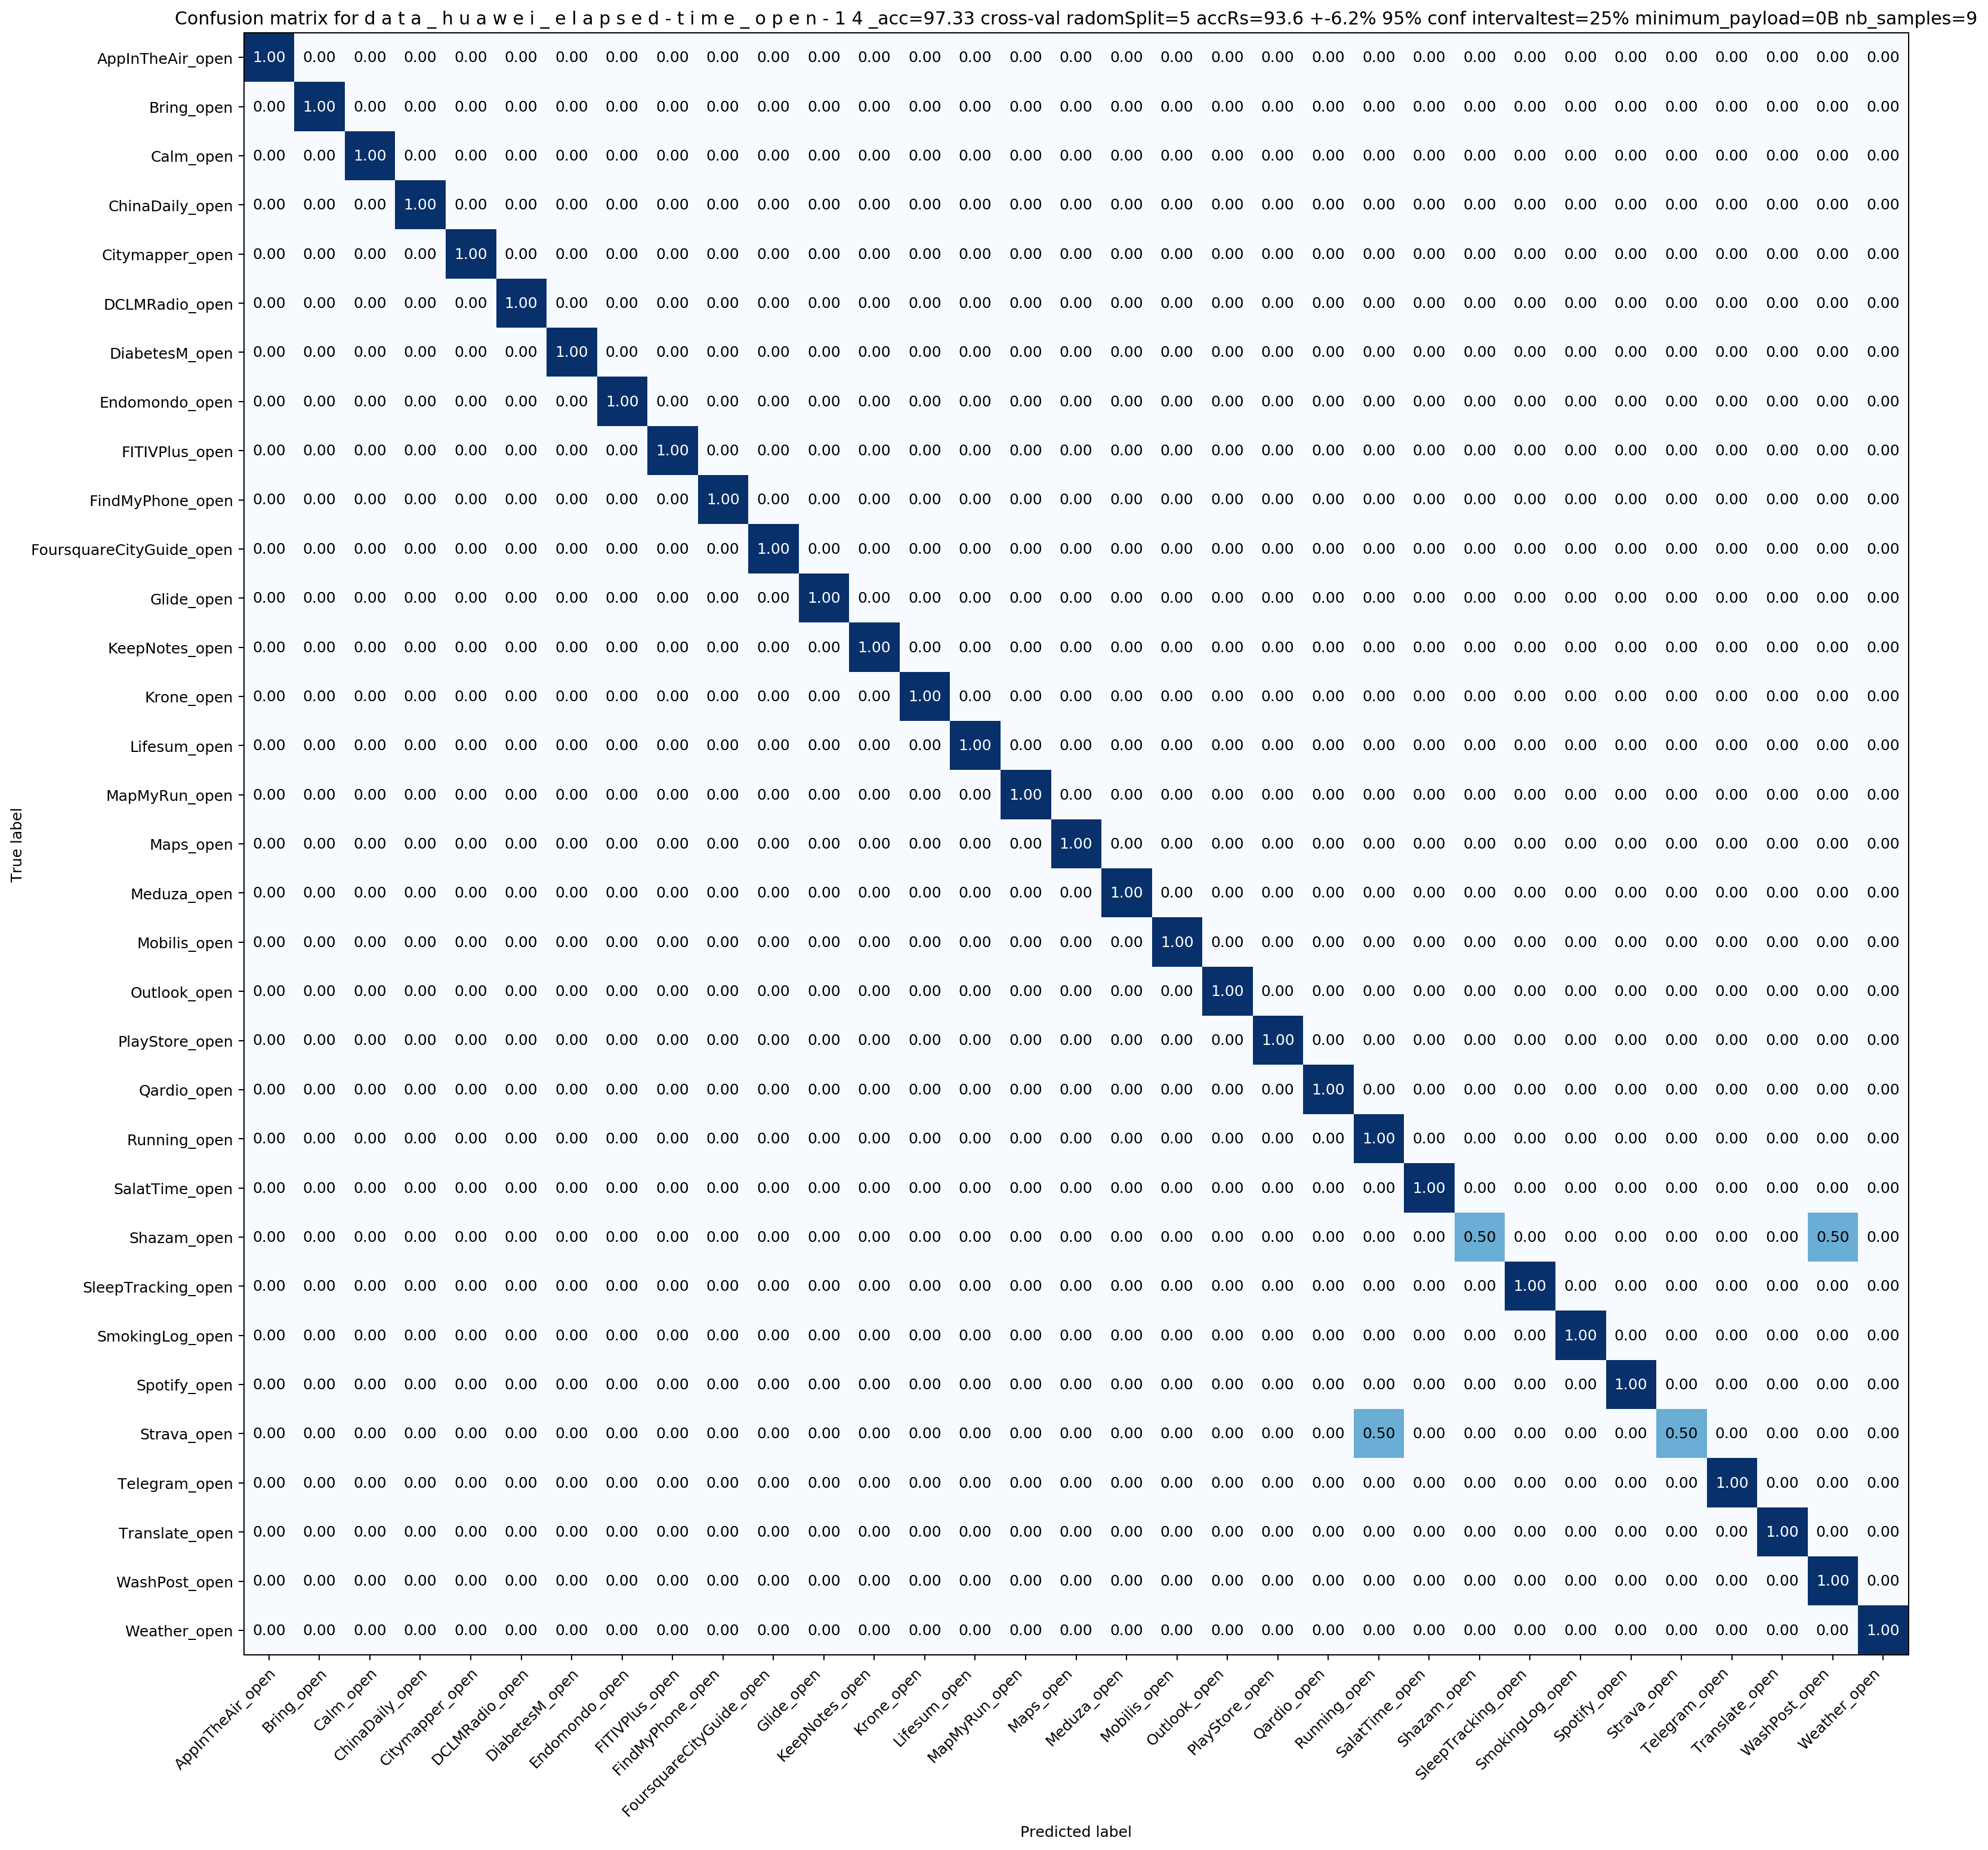

In [1368]:
evaluate(DATA_PATH="data/huawei/elapsed-time/open-14/", MINIMUM_PAYLOAD=0,DETAIL_PRINT=True, PRINT_COUNT=True, CM_ALL_LABEL=True)

In [926]:
first = pd.read_csv('application_version/LEO-BX9_2020_04_22_11h.tsv',sep='\t', header=None,index_col=0, names=['packages', 'version'])
last =  pd.read_csv('application_version/LEO-BX9_2020_04_28_15h.tsv',sep='\t', header=None, index_col=0, names=['packages', 'version'])
print("Number of updates in 6 days:", len(first[first["version"] != last["version"]]))

Number of updates in 6 days: 11


In [1372]:
first

version
packages                                                 
com.huawei.hwretailattractloop                     1.0.12
com.android.cts.priv.ctsshim                  7.0-2996264
com.endless.healthyrecipes                          3.0.0
com.google.android.ext.services                         1
com.google.android.googlequicksearchbox     11.5.9.25.arm
...                                                   ...
com.google.android.apps.walletnfcrel       2.72.209520801
com.google.android.apps.wearable.phone           2.02.009
com.google.android.wearable.app          2.16.0.217378318
com.google.android.apps.handwriting.ime        20170322.0
com.runtastic.android                                 4.0

[116 rows x 1 columns]

Try with Shazam music

In [ ]:
DATA_PATH_REF = ["data/huawei/open-6/"] #, "./data/huawei/Shazam_openFound/",  "data/huawei/DCLM_openError/"]
DISCARDED_ACTION = ['Calm_open', 'AppInTheAir_open', 'Fit_open', 'FitBreathe_open', "FitWorkout_open", 'Qardio_open']

cumul_acc = []
self_acc = []



cumul_true = []
cumul_pred = []

cumul_self_true = []
cumul_self_pred = []




steps = [1, 2, 4, 8, 12, 16, 20, 24, 28, 32]
repeat = 50


X_past, y_past, _ = evaluate(DATA_PATH_REF, DISCARDED_ACTION=DISCARDED_ACTION, RETURN_FEATURES_AND_LABELS=True, PRINT_COUNT=False, EQUALIZATION=True)




clf_past=RandomForestClassifier(n_estimators=200, random_state=None)
clf_past.fit(X_past, y_past)


accuracy, _ = evaluate(DATA_PATH_REF, DISCARDED_ACTION=DISCARDED_ACTION, RATIO=0.3, DATA_SIZE_FILTER=10, RETURN_ACC_AND_CONF=True, N_SPLITS=repeat, PRINT_COUNT=True, EQUALIZATION=False)
cumul_acc += [accuracy] * repeat # already averaged over 10 runs by 10-Splits
self_acc += [accuracy] * repeat


for i, step in zip(range(7, 17), steps):
    DATA_PATH_NEW = ["data/huawei/elapsed-time/open-"+str(i)+"/"] # all
    X_new_all, y_new_all, _ = evaluate(DATA_PATH_NEW, DISCARDED_ACTION=DISCARDED_ACTION, EQUALIZATION=False, RETURN_FEATURES_AND_LABELS=True)
    print("day elapsed: ", step)
    for _ in range(repeat):
        
        # train old model with 7 random stratified samples
        X_past_train, _, y_past_train, _ = train_test_split(X_past,  y_past, 
                 stratify=y_past,
                 train_size=30*7)
        
        
        clf_past=RandomForestClassifier(n_estimators=200, random_state=None)
        clf_past.fit(X_past_train, y_past_train)
        
        # test old model with 7 new random stratified samples
        X_new_train, X_new_true, y_new_train, y_new_true = train_test_split(X_new_all,  y_new_all, 
                 stratify=y_new_all,
                 test_size=30*3)

        y_new_pred = clf_past.predict(X_new_true)
        accuracy = metrics.accuracy_score(y_new_true, y_new_pred)
        print("delayed accuracy = ", accuracy)

        cumul_acc.append(accuracy)
        cumul_true.append(y_new_true)
        cumul_pred.append(y_new_pred)
            

        # Self accuracy 
        clf_new=RandomForestClassifier(n_estimators=200, random_state=None)
        clf_new.fit(X_new_train[:7*30], y_new_train[:7*30])
        y_new_pred = clf_new.predict(X_new_true)
        accuracy = metrics.accuracy_score(y_new_true, y_new_pred)
        
        cumul_self_true.append(y_new_true)
        cumul_self_pred.append(y_new_pred)
        self_acc.append(accuracy)
        print("Self acc = {}".format(accuracy))
        print()
    

In [1330]:
cumul_acc_avg = np.array(cumul_acc).reshape((-1,repeat)).mean(axis = 1)
self_acc_avg = np.array(self_acc).reshape((-1,repeat)).mean(axis = 1)

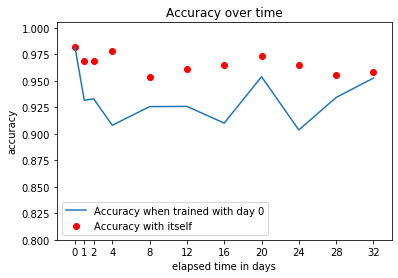

In [1369]:
steps = [0, 1, 2, 4, 8, 12, 16, 20, 24, 28, 32]

plt.plot(steps, cumul_acc_avg, label="Accuracy when trained with day 0")
plt.scatter(steps, self_acc_avg, color="r", label="Accuracy with itself")
plt.ylim([0.8, 1.005])
plt.xticks(steps)
plt.ylabel("accuracy")
plt.xlabel("elapsed time in days")
plt.legend(loc="lower left")
plt.title("Accuracy over time")
plt.savefig("Accuracy_over_time_c08to1_train_only0_bis2", dpi= 80)


In [1456]:
def plot_difference(cumul_self_true, cumul_self_pred, cumul_true, cumul_pred, by='all', repeat=50, selected_apps = None):
    
    
    
    if by!='all':
        idxs = np.where(np.array(steps)== by)
        start = (idxs[0][0]-1) * repeat
        print(start)
        cumul_self_true = cumul_self_true[start: start + repeat]
        cumul_self_pred = cumul_self_pred[start: start + repeat]
        cumul_true = cumul_true[start: start + repeat]
        cumul_pred = cumul_pred[start: start + repeat]
        print(start, start + repeat)
    
    cumul_true_self_flat = [t for ts in cumul_self_true for t in ts]
    cumul_pred_self_flat = [t for ts in cumul_self_pred for t in ts]
    cumul_true_flat = [t for ts in cumul_true for t in ts]
    cumul_pred_flat = [t for ts in cumul_pred for t in ts]
    
    print("pred nb self, ", len(cumul_pred_flat))
    print("pred nb delayed: ", len(cumul_pred_self_flat))
    cm_self, a2, a3 = plot_confusion_matrix(cumul_true_self_flat, cumul_pred_self_flat)
    cm, _, _ = plot_confusion_matrix(cumul_true_flat, cumul_pred_flat)

    print(len(cm))
    acc_diff = np.array([])
    for x in range(len(cm)):
        acc_diff = np.append(acc_diff, cm[x,x] -  cm_self[x,x])

    print("%.2f increased on averaged" % (acc_diff.mean() * 100))

    print(np.mean(acc_diff[np.where(acc_diff<0)]))
    print(np.mean(acc_diff[np.where(acc_diff>0)]))

    clf.classes_[np.where(acc_diff<0)]

    clf.classes_[np.where(acc_diff>0.1)]

    print("acc diff: ", acc_diff)
    fig, ax = plt.subplots(figsize=(12,8))


    sorted_indice = np.argsort(acc_diff)
    sorted_class = clf.classes_[sorted_indice]
    sorted_class= [c.split("_")[0] for c in sorted_class]
 #   sorted_class_idx = [APP_TO_INDEX[c] for c in sorted_class]
    print("worst classes :", sorted_class[:5])
    acc_diff_sorted = acc_diff[sorted_indice]
    first_0 = np.where(acc_diff_sorted == 0)[0][0]
    barlist = plt.bar(x = np.arange(len(acc_diff)), height = acc_diff_sorted, width=0.8, tick_label = "")
    [barlist[i].set_color('r') for i in range(first_0)]
    plt.xlabel("Classes Index", fontsize=17)
    plt.ylabel("Accuracy gain", fontsize=17)
    
    title = "Accuracy gain per class"
    if by == 'all':
        title += " averaged over all days"
    else:
        title += " on day " + str(by)
    plt.title(title, fontsize=20)
    ax.set( #xticks=np.arange(sorted_class),
               xticklabels=sorted_class)
    plt.xticks(fontsize=15, rotation=90)
    plt.yticks(fontsize=15)
    plt.ylim([-0.7, 0.3])
    plt.savefig("accuracy_gain_per_class_when_mix_trained_j=" +str(by) , dpi=80)
    plt.show()
    
    if by!='all':
        idxs = np.where(np.array(steps)== by)
        start = (idxs[0][0]-1) * repeat
        cumul_self_true = cumul_self_true[start: start + repeat]
        cumul_self_pred = cumul_self_pred[start: start + repeat]
        cumul_true = cumul_true[start: start + repeat]
        cumul_pred = cumul_pred[start: start + repeat]
    

        


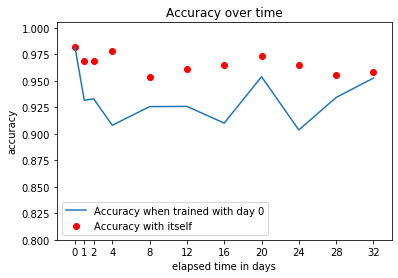

In [1450]:
steps = [0, 1, 2, 4, 8, 12, 16, 20, 24, 28, 32]

plt.plot(steps, cumul_acc_avg, label="Accuracy when trained with day 0")
plt.scatter(steps, self_acc_avg, color="r", label="Accuracy with itself")
plt.ylim([0.8, 1.005])
plt.xticks(steps)
plt.ylabel("accuracy")
plt.xlabel("elapsed time in days")
plt.legend(loc="lower left")
plt.title("Accuracy over time")
plt.savefig("Accuracy_over_time_c08to1_train_only0_bis2", dpi= 80)


pred nb self,  45000
pred nb delayed:  45000
30
-3.70 increased on averaged
-0.05761815298935533
0.0052155536247379675
acc diff:  [ 0.00066845 -0.02742475  0.00736772 -0.47491639  0.00133601 -0.00467602
  0.00133511 -0.01270053 -0.00801603 -0.02068045 -0.01403743 -0.05344021
  0.00066845  0.00667557 -0.12008005  0.         -0.0173449  -0.12374582
 -0.02606952 -0.04803202  0.01804813 -0.06951872  0.005625   -0.02141901
  0.         -0.01068804 -0.01137124 -0.0447861  -0.01606426 -0.02735157]
worst classes : ['DCLMRadio', 'Outlook', 'Maps', 'Shazam', 'Krone']


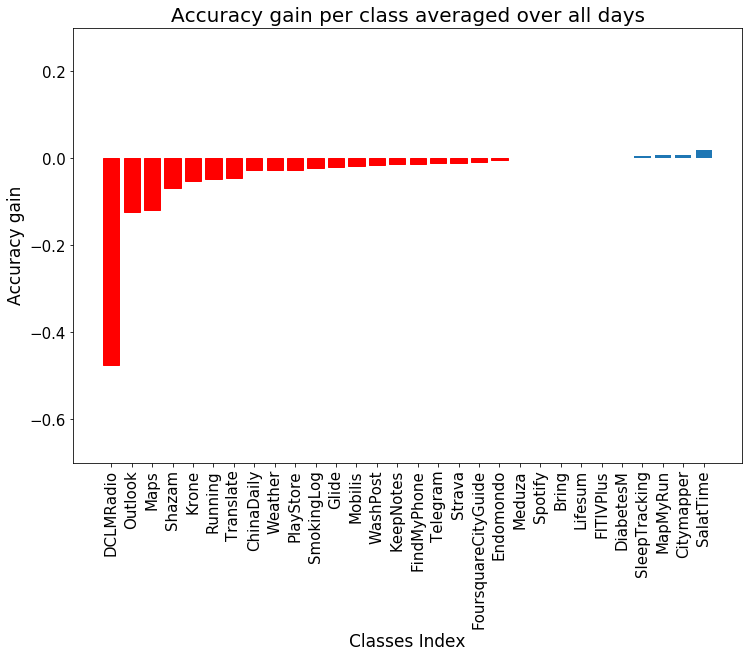

In [1457]:
plot_difference(cumul_self_true, cumul_self_pred, cumul_true, cumul_pred, by='all', repeat=repeat)

100
100 150
pred nb self,  4500
pred nb delayed:  4500
30
-7.02 increased on averaged
-0.12392156862745096
nan
acc diff:  [ 0.         -0.08       -0.01333333 -0.76666667  0.         -0.06
  0.         -0.06        0.         -0.04        0.         -0.12666667
  0.          0.         -0.02        0.         -0.00666667 -0.47333333
 -0.00666667 -0.02        0.         -0.10666667  0.         -0.01333333
  0.         -0.18        0.         -0.06666667 -0.06666667  0.        ]
worst classes : ['DCLMRadio', 'Outlook', 'Strava', 'Krone', 'Shazam']


/usr/local/Cellar/jupyterlab/1.2.6/libexec/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/Cellar/jupyterlab/1.2.6/libexec/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


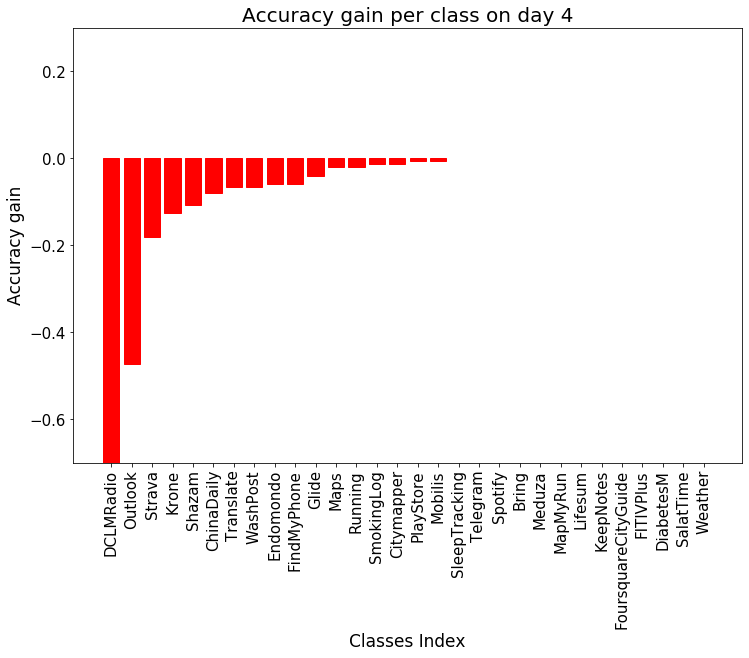

In [1459]:
plot_difference(cumul_self_true, cumul_self_pred, cumul_true, cumul_pred, by=4, repeat=repeat)

100
100 150
pred nb self,  4500
pred nb delayed:  4500
30
-7.02 increased on averaged
-0.12392156862745096
nan
acc diff:  [ 0.         -0.08       -0.01333333 -0.76666667  0.         -0.06
  0.         -0.06        0.         -0.04        0.         -0.12666667
  0.          0.         -0.02        0.         -0.00666667 -0.47333333
 -0.00666667 -0.02        0.         -0.10666667  0.         -0.01333333
  0.         -0.18        0.         -0.06666667 -0.06666667  0.        ]
worst classes : ['DCLMRadio_open' 'Outlook_open' 'Strava_open' 'Krone_open' 'Shazam_open']


/usr/local/Cellar/jupyterlab/1.2.6/libexec/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/Cellar/jupyterlab/1.2.6/libexec/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


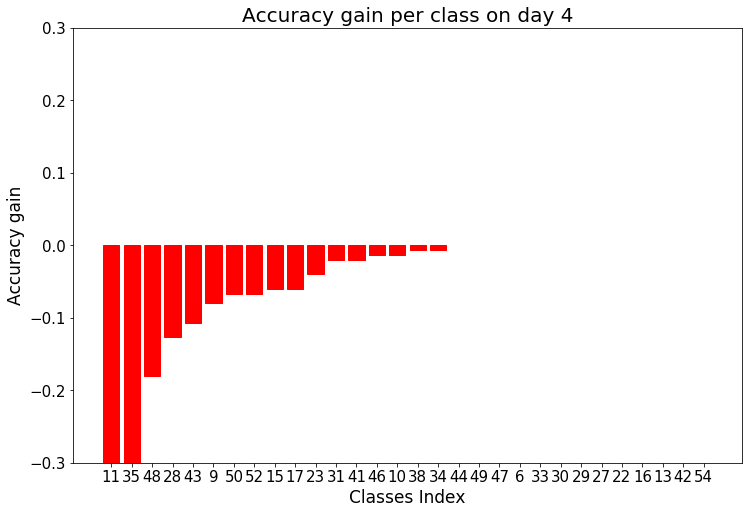

In [1406]:
plot_difference(cumul_self_true, cumul_self_pred, cumul_true, cumul_pred, by=4, repeat=repeat)

In [ ]:

DATA_PATH_REF_1 = ["data/huawei/open-6/"] #, "./data/huawei/Shazam_openFound/",  "data/huawei/DCLM_openError/"]
DATA_PATH_REF_2 = ["data/huawei/elapsed-time/open-7/"]
DATA_PATH_REF_3 = ["data/huawei/elapsed-time/open-8/"]
DATA_PATH_REF = DATA_PATH_REF_1 + DATA_PATH_REF_3 + DATA_PATH_REF_3

DISCARDED_ACTION = ['Calm_open', 'AppInTheAir_open', 'Fit_open', 'FitBreathe_open', "FitWorkout_open", 'Qardio_open']

cumul_acc_mix = []
self_acc_mix = []



cumul_true_mix = []
cumul_pred_mix = []

cumul_self_true_mix = []
cumul_self_pred_mix = []




steps = [4 , 8, 12, 16, 20, 24, 28, 32]
repeat = 50


X_past_1, y_past_1, _ = evaluate(DATA_PATH_REF, DISCARDED_ACTION=DISCARDED_ACTION, RETURN_FEATURES_AND_LABELS=True, PRINT_COUNT=False, EQUALIZATION=False)
X_past_2, y_past_2, _ = evaluate(DATA_PATH_REF, DISCARDED_ACTION=DISCARDED_ACTION, RETURN_FEATURES_AND_LABELS=True, PRINT_COUNT=False, EQUALIZATION=False)
X_past_3, y_past_3, _ = evaluate(DATA_PATH_REF, DISCARDED_ACTION=DISCARDED_ACTION, RETURN_FEATURES_AND_LABELS=True, PRINT_COUNT=False, EQUALIZATION=False)


X_past_train_1, _, y_past_train_1, _ = train_test_split(X_past_1,  y_past_1,  stratify=y_past_3, train_size=30*3)
X_past_train_2, _, y_past_train_2, _ = train_test_split(X_past_2,  y_past_2,  stratify=y_past_3, train_size=30*2)
X_past_train_3, _, y_past_train_3, _ = train_test_split(X_past_3,  y_past_3,  stratify=y_past_3, train_size=30*2)

X_past_train = X_past_1 + X_past_2 + X_past_3
y_past_train = y_past_1 + y_past_2 + y_past_3



clf_past=RandomForestClassifier(n_estimators=200, random_state=None)
clf_past.fit(X_past, y_past)


accuracy, _ = evaluate(DATA_PATH_REF, DISCARDED_ACTION=DISCARDED_ACTION, RATIO=0.3, DATA_SIZE_FILTER=10, RETURN_ACC_AND_CONF=True, N_SPLITS=repeat, PRINT_COUNT=True, EQUALIZATION=False)
cumul_acc_mix += [accuracy] * repeat # already averaged over 10 runs by 10-Splits
self_acc_mix += [accuracy] *  repeat


for i, step in zip(range(9, 17), steps):
    DATA_PATH_NEW = ["data/huawei/elapsed-time/open-"+str(i)+"/"] # all
    X_new_all, y_new_all, _ = evaluate(DATA_PATH_NEW, DISCARDED_ACTION=DISCARDED_ACTION, EQUALIZATION=False, RETURN_FEATURES_AND_LABELS=True)
    print("day elapsed: ", step)
    for _ in range(repeat):
        
        # train old model with 7 random stratified samples
        X_past_train_1, _, y_past_train_1, _ = train_test_split(X_past_1,  y_past_1,  stratify=y_past_1, train_size=30*3)
        X_past_train_2, _, y_past_train_2, _ = train_test_split(X_past_2,  y_past_2,  stratify=y_past_2, train_size=30*2)
        X_past_train_3, _, y_past_train_3, _ = train_test_split(X_past_3,  y_past_3,  stratify=y_past_3, train_size=30*2)
        
        X_past_train = X_past_1 + X_past_2 + X_past_3
        y_past_train = y_past_1 + y_past_2 + y_past_3
        
        clf_past=RandomForestClassifier(n_estimators=200, random_state=None)
        clf_past.fit(X_past_train, y_past_train)
        
        # test the old model with 3 new random stratified samples
        X_new_train, X_new_true, y_new_train, y_new_true = train_test_split(X_new_all,  y_new_all, stratify=y_new_all, test_size=30*3)

        y_new_pred = clf_past.predict(X_new_true)
        accuracy = metrics.accuracy_score(y_new_true, y_new_pred)
        print("delayed accuracy = ", accuracy)

        cumul_acc_mix.append(accuracy)
        cumul_true_mix.append(y_new_true)
        cumul_pred_mix.append(y_new_pred)
            

        # Self accuracy 
        clf_new=RandomForestClassifier(n_estimators=200, random_state=None)
        clf_new.fit(X_new_train[:7*30], y_new_train[:7*30])
        y_new_pred = clf_new.predict(X_new_true)
        accuracy = metrics.accuracy_score(y_new_true, y_new_pred)
        
        cumul_self_true_mix.append(y_new_true)
        cumul_self_pred_mix.append(y_new_pred)
        self_acc_mix.append(accuracy)
        print("Self acc = {}".format(accuracy))
        print()
    

In [1321]:
cumul_acc_avg_mix = np.array(cumul_acc_mix).reshape((-1,repeat)).mean(axis = 1)
self_acc_avg_mix = np.array(self_acc_mix).reshape((-1,repeat)).mean(axis = 1)

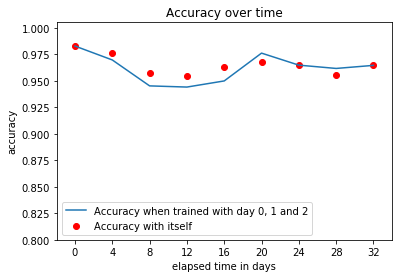

In [1390]:
steps = [0, 4, 8, 12, 16, 20, 24, 28, 32]

plt.plot(steps, cumul_acc_avg_mix, label="Accuracy when trained with day 0, 1 and 2")
plt.scatter(steps, self_acc_avg_mix, color="r", label="Accuracy with itself")
plt.ylim([0.8, 1.005])
plt.xticks(steps)
plt.ylabel("accuracy")
plt.xlabel("elapsed time in days")
plt.legend(loc="lower left")
plt.title("Accuracy over time")
plt.savefig("Accuracy_over_time_c08to1_train_only0_bis2_mix", dpi= 80)


pred nb self,  36000
pred nb delayed:  36000
30
-0.37 increased on averaged
-0.05201598247255483
0.024136164714633573
acc diff:  [ 0.          0.0442404   0.09106099 -0.24644946  0.00250417  0.01597981
  0.00083472  0.02259414  0.00751252  0.00250836  0.00420521  0.00251046
 -0.0075188  -0.01335559  0.01585977  0.         -0.01083333 -0.07679466
  0.0201005   0.00751252  0.06427379 -0.09106099 -0.00230769 -0.02923977
  0.          0.09607352  0.00251046 -0.0342523  -0.00834725  0.01003344]
worst classes : ['DCLMRadio_open' 'Shazam_open' 'Outlook_open' 'Translate_open'
 'SmokingLog_open']


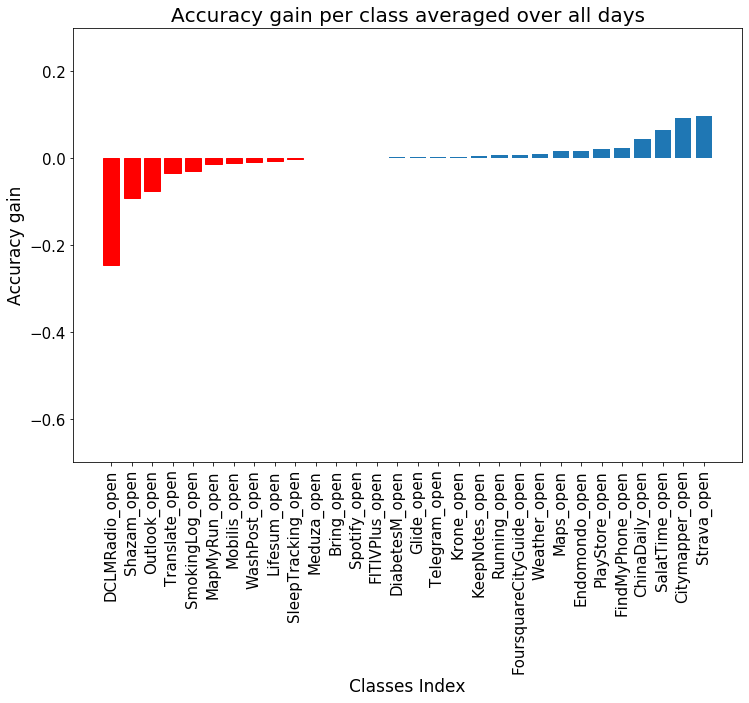

In [1445]:
plot_difference(cumul_self_true_mix, cumul_self_pred_mix, cumul_true_mix, cumul_pred_mix, by='all', repeat=repeat)

In [1463]:
DATA_PATH_REF = ["data/huawei/elapsed-time/open-7/"] #, "./data/huawei/Shazam_openFound/",  "data/huawei/DCLM_openError/"]
DISCARDED_ACTION = ['Calm_open', 'AppInTheAir_open', 'Fit_open', 'FitBreathe_open', "FitWorkout_open", 'Qardio_open']

cumul_acc_day_2 = []
self_acc_day_2 = []



cumul_true_day_2 = []
cumul_pred_day_2 = []

cumul_self_true_day_2 = []
cumul_self_pred_day_2 = []




steps_day_2 = [4, 8, 12, 16, 20, 24, 28, 32]
repeat = 50


X_past, y_past, _ = evaluate(DATA_PATH_REF, DISCARDED_ACTION=DISCARDED_ACTION, RETURN_FEATURES_AND_LABELS=True, PRINT_COUNT=False, EQUALIZATION=True)




clf_past=RandomForestClassifier(n_estimators=200, random_state=None)
clf_past.fit(X_past, y_past)


accuracy, _ = evaluate(DATA_PATH_REF, DISCARDED_ACTION=DISCARDED_ACTION, RATIO=0.3, DATA_SIZE_FILTER=10, RETURN_ACC_AND_CONF=True, N_SPLITS=repeat, PRINT_COUNT=True, EQUALIZATION=False)
cumul_acc_day_2 += [accuracy] * repeat # already averaged over 10 runs by 10-Splits
self_acc_day_2 += [accuracy] * repeat


for i, step in zip(range(8, 17), steps):
    DATA_PATH_NEW = ["data/huawei/elapsed-time/open-"+str(i)+"/"] # all
    X_new_all, y_new_all, _ = evaluate(DATA_PATH_NEW, DISCARDED_ACTION=DISCARDED_ACTION, EQUALIZATION=False, RETURN_FEATURES_AND_LABELS=True)
    print("day elapsed: ", step)
    for _ in range(repeat):
        
        # train old model with 7 random stratified samples
        X_past_train, _, y_past_train, _ = train_test_split(X_past,  y_past, 
                 stratify=y_past,
                 train_size=30*7)
        
        
        clf_past=RandomForestClassifier(n_estimators=200, random_state=None)
        clf_past.fit(X_past_train, y_past_train)
        
        # test old model with 7 new random stratified samples
        X_new_train, X_new_true, y_new_train, y_new_true = train_test_split(X_new_all,  y_new_all, 
                 stratify=y_new_all,
                 test_size=30*3)

        y_new_pred = clf_past.predict(X_new_true)
        accuracy = metrics.accuracy_score(y_new_true, y_new_pred)
        print("delayed accuracy = ", accuracy)

        cumul_acc_day_2.append(accuracy)
        cumul_true_day_2.append(y_new_true)
        cumul_pred_day_2.append(y_new_pred)
            

        # Self accuracy 
        clf_new=RandomForestClassifier(n_estimators=200, random_state=None)
        clf_new.fit(X_new_train[:7*30], y_new_train[:7*30])
        y_new_pred = clf_new.predict(X_new_true)
        accuracy = metrics.accuracy_score(y_new_true, y_new_pred)
        
        cumul_self_true_day_2.append(y_new_true)
        cumul_self_pred_day_2.append(y_new_pred)
        self_acc.append(accuracy)
        print("Self acc = {}".format(accuracy))
        print()
    


importing data...
withdraw action to be discarded
filtering app that does not send traffic by their length

class event count
LEO-BX9: Bring_open - 10
LEO-BX9: ChinaDaily_open - 10
LEO-BX9: Citymapper_open - 10
LEO-BX9: DCLMRadio_open - 10
LEO-BX9: DiabetesM_open - 10
LEO-BX9: Endomondo_open - 10
LEO-BX9: FITIVPlus_open - 10
LEO-BX9: FindMyPhone_open - 10
LEO-BX9: FoursquareCityGuide_open - 10
LEO-BX9: Glide_open - 10
LEO-BX9: KeepNotes_open - 10
LEO-BX9: Krone_open - 10
LEO-BX9: Lifesum_open - 10
LEO-BX9: MapMyRun_open - 10
LEO-BX9: Maps_open - 10
LEO-BX9: Meduza_open - 10
LEO-BX9: Mobilis_open - 10
LEO-BX9: Outlook_open - 10
LEO-BX9: PlayStore_open - 10
LEO-BX9: Running_open - 10
LEO-BX9: SalatTime_open - 10
LEO-BX9: Shazam_open - 10
LEO-BX9: SleepTracking_open - 10
LEO-BX9: SmokingLog_open - 10
LEO-BX9: Spotify_open - 10
LEO-BX9: Strava_open - 10
LEO-BX9: Telegram_open - 10
LEO-BX9: Translate_open - 10
LEO-BX9: WashPost_open - 10
LEO-BX9: Weather_open - 10
Nb class =  30

building 

Self acc = 0.9444444444444444

delayed accuracy =  0.8777777777777778
Self acc = 0.9111111111111111

delayed accuracy =  0.9333333333333333
Self acc = 0.9777777777777777

delayed accuracy =  0.9
Self acc = 0.9666666666666667

delayed accuracy =  0.9222222222222223
Self acc = 0.9444444444444444

delayed accuracy =  0.9222222222222223
Self acc = 0.9555555555555556

delayed accuracy =  0.9111111111111111
Self acc = 0.9555555555555556

delayed accuracy =  0.9333333333333333
Self acc = 0.9666666666666667

delayed accuracy =  0.9222222222222223
Self acc = 0.9666666666666667

delayed accuracy =  0.9222222222222223
Self acc = 0.9666666666666667

delayed accuracy =  0.9222222222222223
Self acc = 0.9555555555555556

delayed accuracy =  0.9111111111111111
Self acc = 0.9555555555555556

delayed accuracy =  0.9333333333333333
Self acc = 0.9777777777777777

delayed accuracy =  0.9333333333333333
Self acc = 0.9777777777777777

delayed accuracy =  0.8888888888888888
Self acc = 0.9444444444444444

dela

Self acc = 0.9888888888888889

delayed accuracy =  0.9
Self acc = 0.9777777777777777

delayed accuracy =  0.9111111111111111
Self acc = 0.9555555555555556

delayed accuracy =  0.8555555555555555
Self acc = 0.9222222222222223

delayed accuracy =  0.9222222222222223
Self acc = 1.0

delayed accuracy =  0.9
Self acc = 0.9777777777777777

delayed accuracy =  0.8777777777777778
Self acc = 0.9666666666666667

delayed accuracy =  0.9
Self acc = 0.9666666666666667

delayed accuracy =  0.9222222222222223
Self acc = 1.0

delayed accuracy =  0.8888888888888888
Self acc = 0.9666666666666667

delayed accuracy =  0.9
Self acc = 0.9888888888888889

delayed accuracy =  0.9222222222222223
Self acc = 0.9666666666666667

delayed accuracy =  0.9111111111111111
Self acc = 0.9888888888888889

delayed accuracy =  0.9222222222222223
Self acc = 0.9888888888888889

delayed accuracy =  0.9
Self acc = 0.9777777777777777

delayed accuracy =  0.8777777777777778
Self acc = 0.9666666666666667

delayed accuracy =  0.91

delayed accuracy =  0.8777777777777778
Self acc = 0.9777777777777777

delayed accuracy =  0.8777777777777778
Self acc = 0.9555555555555556

day elapsed:  20
delayed accuracy =  0.9222222222222223
Self acc = 0.9111111111111111

delayed accuracy =  0.9444444444444444
Self acc = 0.9888888888888889

delayed accuracy =  0.9222222222222223
Self acc = 0.9666666666666667

delayed accuracy =  0.9222222222222223
Self acc = 0.9555555555555556

delayed accuracy =  0.9333333333333333
Self acc = 0.9666666666666667

delayed accuracy =  0.9333333333333333
Self acc = 0.9444444444444444

delayed accuracy =  0.9222222222222223
Self acc = 0.9666666666666667

delayed accuracy =  0.9111111111111111
Self acc = 0.9777777777777777

delayed accuracy =  0.9444444444444444
Self acc = 0.9888888888888889

delayed accuracy =  0.9333333333333333
Self acc = 0.9888888888888889

delayed accuracy =  0.9222222222222223
Self acc = 0.9555555555555556

delayed accuracy =  0.9
Self acc = 0.9555555555555556

delayed accuracy =

In [1464]:
cumul_acc_avg_day_2 = np.array(cumul_acc_day_2).reshape((-1,repeat)).mean(axis = 1)
self_acc_avg_day_2 = np.array(self_acc_day_2).reshape((-1,repeat)).mean(axis = 1)

ValueError: x and y must be the same size

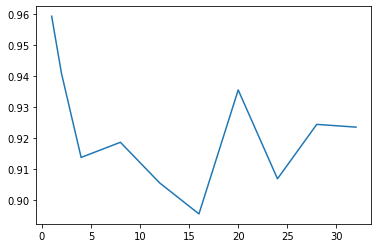

In [1467]:
steps = [1,2, 4, 8, 12, 16, 20, 24, 28, 32]

plt.plot(steps, cumul_acc_avg_day_2, label="Accuracy when trained with day 0, 1 and 2")
plt.scatter(steps, self_acc_avg_day_2, color="r", label="Accuracy with itself")
plt.ylim([0.8, 1.005])
plt.xticks(steps)
plt.ylabel("accuracy")
plt.xlabel("elapsed time in days")
plt.legend(loc="lower left")
plt.title("Accuracy over time")
plt.savefig("Accuracy_over_time_c08to1_train_only0_bis2_mix", dpi= 80)

pred nb self,  40500
pred nb delayed:  40500
30
-4.69 increased on averaged
-0.0997604355666386
0.00801531225452931
acc diff:  [ 0.00000000e+00  2.52976190e-02  5.95238095e-03 -9.87360595e-01
  0.00000000e+00  1.55786350e-02 -7.43494424e-04  1.55786350e-02
 -1.70623145e-02 -1.11524164e-02 -4.45765230e-03 -5.93912398e-03
  2.22551929e-03 -1.26112760e-02  2.22551929e-03  0.00000000e+00
  1.48367953e-03 -1.57620818e-01 -1.85735513e-02  9.64391691e-03
  3.71471025e-03 -8.91530461e-02  2.75862069e-03 -4.52522255e-02
  0.00000000e+00 -6.25931446e-02  3.70919881e-03 -2.89317507e-02
 -8.18452381e-03 -4.67706013e-02]
worst classes : ['DCLMRadio', 'Outlook', 'Shazam', 'Strava', 'Weather']


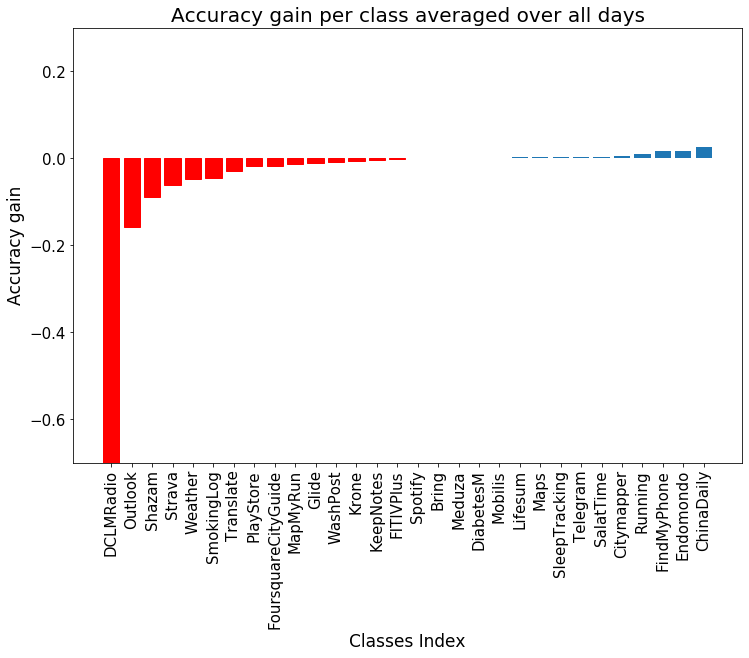

In [1469]:
plot_difference(cumul_self_true_day_2, cumul_self_pred_day_2, cumul_true_day_2, cumul_pred_day_2, by='all', repeat=repeat)

To confirm that: 

Improve previous results by capture both when location not found and location found. **Making the model more general by also including data when location is disabled**


Improve FN rate by adding a class missclassifed after having predicted the label. The criteria to put a label in the nocallfound class will be if the classifier has >50% confidence about this particular sample

##### Becarefull with outlook could not login on nexus

##  For Long-run Classifing NoApp_NoAction

In [ ]:
def cut_all_datasets_in_events(sources_files, timeout=-1):
    """
    Returns a map[device][app][action] => list[[(time, size)],] where list is cut by events
    Second return value is the same structure, but with # of packets instead of events

    also return map[device][app][action] => list[[event_id] used latter to track
    the missclassified events
    """
    events = dict()
    events_id = dict()
    counts = dict()

    # cut each file in events
    for s in sources_files:
        fname = filter_out_path(s)
        parts = fname.split("_")
        device, app, action, event_id = parts[0], parts[1], parts[2], parts[3]

        if not device in events:
            events[device] = dict()
        if not app in events[device]:
            events[device][app] = dict()
        if not action in events[device][app]:
            events[device][app][action] = []

        file_events = dataset_file_to_xy_events(s, timeout=timeout) # cut each trace into subtraces after 4.5 idle time

        event_index = 0
        for event in file_events:
            n_packets = len(event['xs'])
            if n_packets == 0:
                #print("Skipping", s, " (",device,app,action,") event",event_index, "as it has 0 packets")
                pass
            else:
                events[device][app][action].append(event)

            event_index += 1

    return events, counts


def cut_all_datasets_in_event(sources_files, timeout=-1):
    """
    Returns a map[device][app][action][event] => (time, size) where list is cut by events
    Second return value is the same structure, but with # of packets instead of events
    """
    events = dict()
    counts = dict()

    # cut each file in events
    for s in sources_files:
        fname = filter_out_path(s)
        parts = fname.split("_")
        device, app, action = parts[0], parts[1], parts[2]
        event_nb = parts[5][: parts[5].find(".")]

        if not device in events:
            events[device] = dict()
        if not app in events[device]:
            events[device][app] = dict()
        if not action in events[device][app]:
            events[device][app][action] = dict()

        file_events = dataset_file_to_xy_events(s, timeout=timeout) # cut each trace into subtraces after 4.5 idle time

        event_index = 0
        for event in file_events:
            n_packets = len(event['xs'])
            if n_packets == 0:
                #print("Skipping", s, " (",device,app,action,") event",event_index, "as it has 0 packets")
                pass
            else:
                events[device][app][action][event_nb] = event

            event_index += 1

    return events, counts

In [ ]:
f_s = find_sources("./data/huawei/NoApp_NoAction-2/")

e, _ =cut_all_datasets_in_event(f_s)

In [ ]:
ises = []
for w in e:
    for ap in e[w]:
        for ac in e[w][ap]:
            for i in e[w][ap][ac]:
                ys = e[w][ap][ac][i]['ys']
                t_traf = np.sum(np.abs(np.array(ys)))
                if t_traf > 200:
                    print("i {}: t_traf= {}".format(i,t_traf))
                    ises.append(i)
                    
print(ises)


<a id='apple-huawei'></a>
### Transferability iwatch - huawei
[Table of Content](#tc)

In [ ]:
DATA_PATH = ["data/iwatch/batch-1/","data/huawei/elapsed-time/open-13/"]
equilibrate_events = evaluate(DATA_PATH, DISCARDED_ACTION=DISCARD, TO_MERGE=TO_MERGED, MERGED_NAMES=Names, EQUALIZATION=True, RETURN_EQUILIBRATE_EVENTS=True, PRINT_COUNT=True)


equilibrate_events_huawei = dict()
equilibrate_events_iwatch = dict()

# Separation of the two datasets
equilibrate_events_huawei["LEO-BX9"] = equilibrate_events["LEO-BX9"]
equilibrate_events_iwatch["AppleWatch"] = equilibrate_events["AppleWatch"]

print("building and training the model for cross validation ")
clf=RandomForestClassifier(n_estimators=1000, random_state=None)


print("building and training a model for confusion matrix")
X_huawei, y_huawei, _ = build_features_labels_dataset(equilibrate_events_huawei)
clf.fit(X_huawei, y_huawei)
X_iwatch, y_iwatch, _ = build_features_labels_dataset(equilibrate_events_iwatch)


y_iwatch_pred = clf.predict(X_iwatch)
accuracy = metrics.accuracy_score(y_iwatch, y_iwatch_pred)
print("accuracy = ", accuracy)



title = "Confusion_matrix_train_with_Huawei_test_with_Apple_acc={:0.2f}".format(accuracy * 100)
saved_title = title.replace(".", "_").replace(" ", "_")
_ = plot_confusion_matrix(y_iwatch, y_iwatch_pred, title= title, figname = saved_title, CM_NO_LABELS=True)


In [ ]:
DATA_PATH = ["data/iwatch/batch-1/","data/huawei/elapsed-time/open-13/"]
equilibrate_events = evaluate(DATA_PATH, DISCARDED_ACTION=DISCARD, TO_MERGE=TO_MERGED, MERGED_NAMES=Names, EQUALIZATION=True, RETURN_EQUILIBRATE_EVENTS=True, PRINT_COUNT=True)


equilibrate_events_huawei = dict()
equilibrate_events_iwatch = dict()

# Separation of the two datasets
equilibrate_events_huawei["LEO-BX9"] = equilibrate_events["LEO-BX9"]
equilibrate_events_iwatch["AppleWatch"] = equilibrate_events["AppleWatch"]

print("building and training the model for cross validation ")
clf=RandomForestClassifier(n_estimators=1000, random_state=None)


print("building and training a model for confusion matrix")
X_huawei, y_huawei, _ = build_features_labels_dataset(equilibrate_events_huawei)
clf.fit(X_huawei, y_huawei)
X_iwatch, y_iwatch, _ = build_features_labels_dataset(equilibrate_events_iwatch)


y_iwatch_pred = clf.predict(X_iwatch)
accuracy = metrics.accuracy_score(y_iwatch, y_iwatch_pred)
print("accuracy = ", accuracy)



title = "Confusion_matrix_train_with_Huawei_test_with_Apple_acc={:0.2f}".format(accuracy * 100)
saved_title = title.replace(".", "_").replace(" ", "_")
_ = plot_confusion_matrix(y_iwatch, y_iwatch_pred, title= title, figname = saved_title, CM_NO_LABELS=True)


<a id='model tunning'></a>
## Model Tunning
[Table of Content](#tc)

In [434]:
DATA_PATH = "data/huawei/open-3/"
DISCARDED_ACTION = ['NoApp_NoAction']
repeat = 10

accs = []
for i in range(0, 110, 4):
    print(i)
    for _ in range(repeat):
        acc, conf = evaluate(DATA_PATH, DISCARDED_ACTION=DISCARDED_ACTION, N_SPLITS=5, UNIQUE_DELTAS=[],
                             UNIQUE_LENGTH_FROM=i,
                             RETURN_ACC_AND_CONF=True, TITLE="Size Unordered Confusion Matrix", 
                             figname="Confusion_matrix_unordered_by_amount_of_traffic")
        print(acc)
        accs.append(acc)


0
feature length :  1030
0.9689750692520775
feature length :  1030
0.9695290858725762
feature length :  1030
0.9761772853185595
feature length :  1030
0.9678670360110804
feature length :  1030
0.9700831024930748
feature length :  1030
0.9700831024930748
feature length :  1030
0.9722991689750693
feature length :  1030
0.9706371191135734
feature length :  1030
0.9717451523545707
feature length :  1030
0.9700831024930748
4
feature length :  1026
0.9728531855955678
feature length :  1026
0.9750692520775622
feature length :  1026
0.970083102493075
feature length :  1026
0.968421052631579
feature length :  1026
0.9700831024930748
feature length :  1026
0.975623268698061
feature length :  1026
0.9706371191135735
feature length :  1026
0.9678670360110804
feature length :  1026
0.9667590027700831
feature length :  1026
0.968421052631579
8
feature length :  1022
0.9667590027700831
feature length :  1022
0.9745152354570636
feature length :  1022
0.9722991689750693
feature length :  1022
0.9678670

0.9601108033240997
feature length :  954
0.9601108033240997
feature length :  954
0.956786703601108
80
feature length :  950
0.9601108033240997
feature length :  950
0.9617728531855955
feature length :  950
0.962880886426593
feature length :  950
0.9518005540166203
feature length :  950
0.9551246537396121
feature length :  950
0.9612188365650971
feature length :  950
0.9584487534626038
feature length :  950
0.9573407202216068
feature length :  950
0.9634349030470915
feature length :  950
0.9634349030470915
84
feature length :  946
0.9551246537396121
feature length :  946
0.9562326869806095
feature length :  946
0.956786703601108
feature length :  946
0.968421052631579
feature length :  946
0.9612188365650969
feature length :  946
0.9584487534626038
feature length :  946
0.9634349030470915
feature length :  946
0.9700831024930746
feature length :  946
0.959556786703601
feature length :  946
0.9590027700831024
88
feature length :  942
0.9634349030470913
feature length :  942
0.9606648199

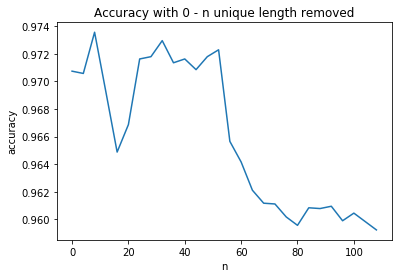

In [437]:
steps = range(0, 110, 4)
cumul_acc_avg = np.array(accs).reshape((-1,repeat)).mean(axis = 1)

fig, ax = plt.subplots()

ax.plot(steps, cumul_acc_avg)
plt.ylabel("accuracy")
plt.xlabel("n")
plt.title("Accuracy with 0 - n unique length removed")
plt.savefig("Accuracy with 0 - n unique length removed", dpi= 80)

In [ ]:
DATA_PATH = "data/huawei/open-3/"
DISCARDED_ACTION = ['NoApp_NoAction']
repeat = 10

accs_extra = []
for i in range(0, 20, 4):
    print(i)
    for _ in range(repeat):
        acc, conf = evaluate(DATA_PATH, DISCARDED_ACTION=DISCARDED_ACTION, N_SPLITS=6, UNIQUE_DELTAS=[],
                             UNIQUE_LENGTH_FROM=i,
                             RETURN_ACC_AND_CONF=True, TITLE="Size Unordered Confusion Matrix", 
                             figname="Confusion_matrix_unordered_by_amount_of_traffic")
        print(acc)
        accs_extra.append(acc)

In [438]:
i = 2
acc, conf = evaluate(DATA_PATH, DISCARDED_ACTION=DISCARDED_ACTION, N_SPLITS=5, UNIQUE_DELTAS=[],
                             UNIQUE_LENGTH_FROM=i,
                             RETURN_ACC_AND_CONF=True, TITLE="Size Unordered Confusion Matrix", 
                             figname="Confusion_matrix_unordered_by_amount_of_traffic")

array([0.97074792, 0.97058172, 0.97357341, 0.96925208, 0.96487535,
       0.96686981, 0.97163435, 0.97180055, 0.97296399, 0.97135734,
       0.97163435, 0.97085873, 0.97180055, 0.97229917, 0.96565097,
       0.96415512, 0.96210526, 0.96116343, 0.96110803, 0.9601662 ,
       0.95955679, 0.96083102, 0.96077562, 0.96094183, 0.9598892 ,
       0.96044321, 0.9598338 , 0.95922438])

# Which Criterion to choose

In [443]:
criterion = ['gini', 'entropy']
accs_cr = []
confs_cr = []
for c in criterion:
    acc, conf = evaluate(DATA_PATH, DISCARDED_ACTION=DISCARDED_ACTION, N_SPLITS=50, UNIQUE_DELTAS=[],
                         UNIQUE_LENGTH_FROM=46,
                         SPLIT_CRITERION=c,
                         RETURN_ACC_AND_CONF=True,
                         TITLE="Size Unordered Confusion Matrix",
                         figname="Confusion_matrix_unordered_by_amount_of_traffic")
    print(acc)
    
    accs_cr.append(acc)
    confs_cr.append(conf)

feature length :  984
0.972797783933518
feature length :  984
0.964321329639889


# Set Max features


In [456]:
i = np.arange(0.2,1.2,0.2)

In [463]:
mxfs = ['sqrt', 'log2']
accs_max_feat = []
for mxf in mxfs:
    acc, conf = evaluate(DATA_PATH, DISCARDED_ACTION=DISCARDED_ACTION, N_SPLITS=50, UNIQUE_DELTAS=[],
                         UNIQUE_LENGTH_FROM=46,
                         MAX_FEATURES=mxf,
                         RETURN_ACC_AND_CONF=True,
                         TITLE="Size Unordered Confusion Matrix",
                         figname="Confusion_matrix_unordered_by_amount_of_traffic")
    print(acc)
    
    accs_max_feat.append(acc)
    accs_max_feat.append(conf)

feature length :  984
0.973573407202216
feature length :  984
0.9711357340720221


In [ ]:
for mxf in mxfs:
    acc, conf = evaluate(DATA_PATH, DISCARDED_ACTION=DISCARDED_ACTION, N_SPLITS=50, UNIQUE_DELTAS=[],
                         UNIQUE_LENGTH_FROM=46,
                         MAX_FEATURES=mxf,
                         RETURN_ACC_AND_CONF=True,
                         TITLE="Size Unordered Confusion Matrix",
                         figname="Confusion_matrix_unordered_by_amount_of_traffic")
    print(acc)
    
    accs_max_feat.append(acc)
    accs_max_feat.append(conf)

## Features importance

In [826]:
def feature_importance_explaination(clf, f_name_filtered):
    


    features_importance = clf.feature_importances_
    top_args = np.argsort(-features_importance)[:30].tolist()

    top_feat_name = np.array(f_name_filtered)[top_args]
    top_importance = np.array(features_importance)[top_args]
    print("Top features: ")
    print(top_feat_name)
    print("Top importance")
    print(top_importance)


    f_name_filtered = np.array(f_name_filtered)
    feature_importances = clf.feature_importances_
    indices_uniques = np.array([i for i, n in enumerate(f_name_filtered) if n.startswith("unique_lengths")])
    indices_deltas = np.array([i for i, n in enumerate(f_name_filtered) if "deltas" in n])
    indices_mean = np.array([i for i, n in enumerate(f_name_filtered) if "mean" in n])
    indices_kurtosis = np.array([i for i, n in enumerate(f_name_filtered) if "kurtosis" in n])
    indices_count = np.array([i for i, n in enumerate(f_name_filtered) if "count" in n])
    indices_min = np.array([i for i, n in enumerate(f_name_filtered) if "min" in n])
    indices_max = np.array([i for i, n in enumerate(f_name_filtered) if "max" in n])
    indices_std = np.array([i for i, n in enumerate(f_name_filtered) if "std" in n])
    indices_incoming = np.array([i for i, n in enumerate(f_name_filtered) if "incoming" in n])
    indices_outgoing = np.array([i for i, n in enumerate(f_name_filtered) if "outgoing" in n])
    indices_nonull = np.array([i for i, n in enumerate(f_name_filtered) if "non_null" in n])


    importance_dict = dict()

    importance_dict["unique length"] = np.sum(feature_importances[indices_uniques])


    importance_dict["deltas"] = np.sum(feature_importances[indices_deltas])
    importance_dict["mean"] = np.sum(feature_importances[indices_mean])
    importance_dict["kurtosis"] = np.sum(feature_importances[indices_kurtosis])
    importance_dict["count"] = np.sum(feature_importances[indices_count])
    importance_dict["min"] = np.sum(feature_importances[indices_min])
    importance_dict["max"] = np.sum(feature_importances[indices_max])
    importance_dict["std"] = np.sum(feature_importances[indices_std])
    importance_dict["incoming"] = np.sum(feature_importances[indices_incoming])
    importance_dict["outgoing"] = np.sum(feature_importances[indices_outgoing])
    importance_dict["non null"] = np.sum(feature_importances[indices_outgoing])


    indices_uniques_all = np.array([i for i, n in enumerate(f_name) if n.startswith("unique_lengths")])
    print("number of unique lengths cut off: ", len(indices_uniques_all) - len(indices_uniques))

    indices_sorted = np.argsort(feature_importances[indices_uniques])
    ranked_feat = f_name_filtered[indices_uniques][indices_sorted][::-1]
    TOP_10 = [int(''.join(filter(str.isdigit, feature))) for feature in ranked_feat]
    LENGTH_TOP10 = TOP_10[:10]

    imp = pd.DataFrame(importance_dict, index=["importance"]).transpose()
    imp.sort_index().plot(kind = 'barh')
    return imp

### Huawei open

In [819]:
DATA_PATH = ['data/huawei/open-3/']
to_withdraw = find_feat_to_withdraw(DATA_PATH,  MAX_ITERATION=1)
clf_open = evaluate(DATA_PATH, DETAIL_PRINT=False, 
               RETURN_CLF=True,
               TO_WITHDRAW=to_withdraw,
              )

_, _, f_name_filtered_open = evaluate(DATA_PATH, DETAIL_PRINT=True, 
                                 RETURN_FEATURES_AND_LABELS=True, 
                                 TO_WITHDRAW=to_withdraw,
                                 N_SPLITS=50)


importing data...
filtering app that does not send traffic by their length
dataset equalization per class
building features and labels
features count :  1002
features count :  501

importing data...
filtering app that does not send traffic by their length
dataset equalization per class
building features and labels
features count :  501


Top features: 
['max_incoming' 'count_outgoing' 'unique_lengths_1005' 'mean_incoming'
 'std_outgoing' 'std_incoming' 'min_incoming' 'mean_outgoing'
 'min_x_deltas_46' 'max_x_deltas_46' 'count_non_null' 'max_outgoing'
 'std_x_deltas_46' 'kurtosis_x_deltas_46' 'count_x_deltas_46'
 'std_unique_lengths' 'mean_unique_lengths' 'count_incoming'
 'kurtosis_outgoing' 'std_non_null' 'min_outgoing' 'unique_lengths_54'
 'max_unique_lengths' 'mean_non_null' 'kurtosis_unique_lengths'
 'count_x_deltas_0' 'min_x_deltas_0' 'kurtosis_x_deltas_0'
 'kurtosis_incoming' 'kurtosis_non_null']
Top importance
[0.03185683 0.02594419 0.0258067  0.0255033  0.02538348 0.02504161
 0.0249049  0.02459957 0.02419324 0.02113741 0.02057158 0.01958912
 0.01861997 0.01859163 0.01633635 0.01627419 0.01591063 0.01450241
 0.01380113 0.01374283 0.01365347 0.01342054 0.01310384 0.01158347
 0.01152503 0.0109679  0.01091778 0.01062217 0.00988389 0.00962129]
number of unique lengths cut off:  497


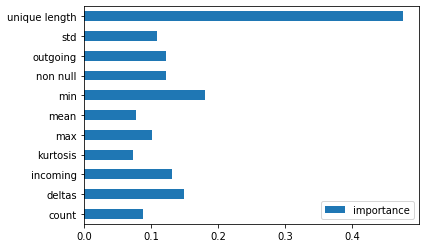

In [827]:
imp_open = feature_importance_explaination(clf_open, f_name_filtered_open)

### Huawei actions

In [804]:
DATA_PATH = ["data/huawei/Endomondo-1/", "data/huawei/DiabetesM-4/",
             "data/huawei/FoursquareCityGuide-1/", "data/huawei/HealthyRecipes-1/",
             "data/huawei/Lifesum-1/", "data/huawei/Playstore-1/"]
to_withdraw = find_feat_to_withdraw(DATA_PATH,  MAX_ITERATION=1)

clf_action = evaluate(DATA_PATH, DETAIL_PRINT=False, 
               RETURN_CLF=True,
               TO_WITHDRAW=to_withdraw,
              )

_, _, f_name_filtered = evaluate(DATA_PATH, DETAIL_PRINT=True, 
                                 RETURN_FEATURES_AND_LABELS=True, 
                                 TO_WITHDRAW=to_withdraw,
                                 N_SPLITS=50)


importing data...
filtering app that does not send traffic by their length
dataset equalization per class
building features and labels
features count :  1002
features count :  377

importing data...
filtering app that does not send traffic by their length
dataset equalization per class
building features and labels
features count :  377
building and training the model for cross validation 
Random split cross-validation: Accuracy=0.728 (+/- 0.068). 
building and training a model for confusion matrix
fitting duration = 0.412
prediction duration = 0.034
accuracy = 0.7228915662650602
done


TypeError: cannot unpack non-iterable NoneType object

Top features: 
['max_x_deltas_46' 'min_x_deltas_46' 'std_incoming' 'min_x_deltas_0'
 'count_non_null' 'mean_incoming' 'mean_outgoing' 'std_outgoing'
 'std_x_deltas_46' 'max_incoming' 'max_x_deltas_0' 'max_outgoing'
 'kurtosis_incoming' 'kurtosis_x_deltas_46' 'std_x_deltas_0'
 'unique_lengths_54' 'count_x_deltas_46' 'std_unique_lengths'
 'unique_lengths_170' 'unique_lengths_1005' 'count_incoming'
 'mean_non_null' 'unique_lengths_216' 'mean_unique_lengths'
 'kurtosis_non_null' 'count_outgoing' 'kurtosis_outgoing'
 'max_unique_lengths' 'count_x_deltas_0' 'kurtosis_x_deltas_0']
Top importance
[0.03558143 0.03483478 0.0281886  0.02795785 0.0265669  0.02549993
 0.02511215 0.02423743 0.02373657 0.02353587 0.02335004 0.02220712
 0.02027588 0.02007394 0.01979672 0.0187482  0.01821082 0.01801559
 0.01650434 0.01640904 0.01632872 0.01619601 0.01599669 0.01598245
 0.01509243 0.01503326 0.01468082 0.01458827 0.01413413 0.01401338]
number of unique lengths cut off:  617


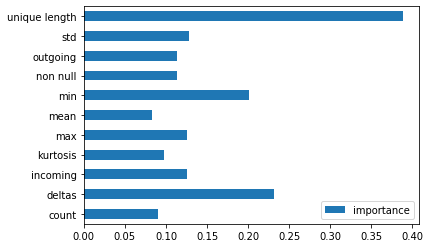

In [828]:
imp = feature_importance_explaination(clf, f_name_filtered)

In [830]:
imp["features importance open"] = imp_open["importance"]

In [834]:
imp = imp.rename(columns={"importance": "features importance inApp"})

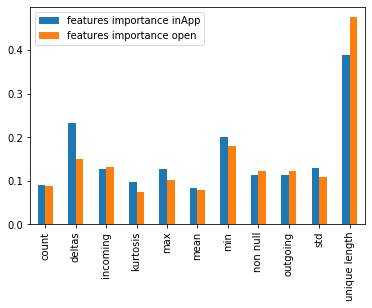

In [836]:
    imp.sort_index().plot(kind = 'bar')

In [902]:
DATA_PATH_REF = ["data/huawei/open-6/"] #, "./data/huawei/Shazam_openFound/",  "data/huawei/DCLM_openError/"]
DISCARDED_ACTION = ['Calm_open', 'AppInTheAir_open', 'Fit_open', 'FitBreathe_open', "FitWorkout_open", 'Qardio_open']

cumul_acc = []
cumul_true = []
cumul_pred = []
self_acc = []


X_past, y_past, _ = evaluate(DATA_PATH_REF, DISCARDED_ACTION=DISCARDED_ACTION, DATA_SIZE_FILTER=7, RETURN_FEATURES_AND_LABELS=True, PRINT_COUNT=False, EQUALIZATION=False)

clf=RandomForestClassifier(n_estimators=200, random_state=None)
clf.fit(X_past, y_past)


steps = [1, 2, 4, 8, 12, 16, 20, 24, 28, 32]
repeat = 10

for _ in range(repeat):
    y_true, y_pred = evaluate(DATA_PATH_REF, RETURN_PRED=True, DISCARDED_ACTION=DISCARDED_ACTION, DATA_SIZE_FILTER=10, EQUALIZATION=False, PRINT_COUNT=False, N_ESTIMATOR=200)
    accuracy = metrics.accuracy_score(y_true, y_pred)
    cumul_acc.append(accuracy)
    self_acc.append(accuracy)

for i, step in zip(range(7, 17), steps):
    DATA_PATH_NEW = ["data/huawei/elapsed-time/open-"+str(i)+"/"] # all
    print("day elapsed: ", step)
    for _ in range(repeat):
        X_new, y_new, _ = evaluate(DATA_PATH_NEW, DISCARDED_ACTION=DISCARDED_ACTION, PRINT_COUNT=True, EQUALIZATION=False, DATA_SIZE_FILTER=3, RETURN_FEATURES_AND_LABELS=True)


        y_new_pred = clf.predict(X_new)
        accuracy = metrics.accuracy_score(y_new, y_new_pred)
        print("accuracy = ", accuracy)


        cumul_acc.append(accuracy)
        cumul_true.append(y_new)
        cumul_pred.append(y_new_pred)

        # Self accuracy 
        acc, conf = evaluate(DATA_PATH_NEW, RATIO=0.25, DISCARDED_ACTION=DISCARDED_ACTION, PRINT_COUNT=False, N_SPLITS=5, EQUALIZATION=False, DATA_SIZE_FILTER=10, N_ESTIMATOR=200, RETURN_ACC_AND_CONF=True)
        self_acc.append(acc)
        print("Self acc = {}, conf = {}".format(acc, conf))
        print()


features count :  1002
features count :  1002
features count :  1002
features count :  1002
features count :  1002
features count :  1002
features count :  1002
features count :  1002
features count :  1002
features count :  1002
features count :  1002
day elapsed:  1

importing data...
withdraw action to be discarded
filtering app that does not send traffic by their length

class event count
LEO-BX9: Bring_open - 3
LEO-BX9: ChinaDaily_open - 3
LEO-BX9: Citymapper_open - 3
LEO-BX9: DCLMRadio_open - 3
LEO-BX9: DiabetesM_open - 3
LEO-BX9: Endomondo_open - 3
LEO-BX9: FITIVPlus_open - 3
LEO-BX9: FindMyPhone_open - 3
LEO-BX9: FoursquareCityGuide_open - 3
LEO-BX9: Glide_open - 3
LEO-BX9: KeepNotes_open - 3
LEO-BX9: Krone_open - 3
LEO-BX9: Lifesum_open - 3
LEO-BX9: MapMyRun_open - 3
LEO-BX9: Maps_open - 3
LEO-BX9: Meduza_open - 3
LEO-BX9: Mobilis_open - 3
LEO-BX9: Outlook_open - 3
LEO-BX9: PlayStore_open - 3
LEO-BX9: Running_open - 3
LEO-BX9: SalatTime_open - 3
LEO-BX9: Shazam_open - 3
LEO-BX


class event count
LEO-BX9: Bring_open - 3
LEO-BX9: ChinaDaily_open - 3
LEO-BX9: Citymapper_open - 3
LEO-BX9: DCLMRadio_open - 3
LEO-BX9: DiabetesM_open - 3
LEO-BX9: Endomondo_open - 3
LEO-BX9: FITIVPlus_open - 3
LEO-BX9: FindMyPhone_open - 3
LEO-BX9: FoursquareCityGuide_open - 3
LEO-BX9: Glide_open - 3
LEO-BX9: KeepNotes_open - 3
LEO-BX9: Krone_open - 3
LEO-BX9: Lifesum_open - 3
LEO-BX9: MapMyRun_open - 3
LEO-BX9: Maps_open - 3
LEO-BX9: Meduza_open - 3
LEO-BX9: Mobilis_open - 3
LEO-BX9: Outlook_open - 3
LEO-BX9: PlayStore_open - 3
LEO-BX9: Running_open - 3
LEO-BX9: SalatTime_open - 3
LEO-BX9: Shazam_open - 3
LEO-BX9: SleepTracking_open - 3
LEO-BX9: SmokingLog_open - 3
LEO-BX9: Spotify_open - 3
LEO-BX9: Strava_open - 3
LEO-BX9: Telegram_open - 3
LEO-BX9: Translate_open - 3
LEO-BX9: WashPost_open - 3
LEO-BX9: Weather_open - 3
Nb class =  30

building features and labels
features count :  1002
accuracy =  0.9444444444444444
features count :  1002
Self acc = 0.952, conf = 0.03617242657666

features count :  1002
accuracy =  0.9222222222222223
features count :  1002
Self acc = 0.984, conf = 0.019955506062794316


importing data...
withdraw action to be discarded
filtering app that does not send traffic by their length

class event count
LEO-BX9: Bring_open - 3
LEO-BX9: ChinaDaily_open - 3
LEO-BX9: Citymapper_open - 3
LEO-BX9: DCLMRadio_open - 3
LEO-BX9: DiabetesM_open - 3
LEO-BX9: Endomondo_open - 3
LEO-BX9: FITIVPlus_open - 3
LEO-BX9: FindMyPhone_open - 3
LEO-BX9: FoursquareCityGuide_open - 3
LEO-BX9: Glide_open - 3
LEO-BX9: KeepNotes_open - 3
LEO-BX9: Krone_open - 3
LEO-BX9: Lifesum_open - 3
LEO-BX9: MapMyRun_open - 3
LEO-BX9: Maps_open - 3
LEO-BX9: Meduza_open - 3
LEO-BX9: Mobilis_open - 3
LEO-BX9: Outlook_open - 3
LEO-BX9: PlayStore_open - 3
LEO-BX9: Running_open - 3
LEO-BX9: SalatTime_open - 3
LEO-BX9: Shazam_open - 3
LEO-BX9: SleepTracking_open - 3
LEO-BX9: SmokingLog_open - 3
LEO-BX9: Spotify_open - 3
LEO-BX9: Strava_open - 3
LEO-BX9: Telegram_open - 3
LEO-BX9: Tra


class event count
LEO-BX9: Bring_open - 3
LEO-BX9: ChinaDaily_open - 3
LEO-BX9: Citymapper_open - 3
LEO-BX9: DCLMRadio_open - 3
LEO-BX9: DiabetesM_open - 3
LEO-BX9: Endomondo_open - 3
LEO-BX9: FITIVPlus_open - 3
LEO-BX9: FindMyPhone_open - 3
LEO-BX9: FoursquareCityGuide_open - 3
LEO-BX9: Glide_open - 3
LEO-BX9: KeepNotes_open - 3
LEO-BX9: Krone_open - 3
LEO-BX9: Lifesum_open - 3
LEO-BX9: MapMyRun_open - 3
LEO-BX9: Maps_open - 3
LEO-BX9: Meduza_open - 3
LEO-BX9: Mobilis_open - 3
LEO-BX9: Outlook_open - 3
LEO-BX9: PlayStore_open - 3
LEO-BX9: Running_open - 3
LEO-BX9: SalatTime_open - 3
LEO-BX9: Shazam_open - 3
LEO-BX9: SleepTracking_open - 3
LEO-BX9: SmokingLog_open - 3
LEO-BX9: Spotify_open - 3
LEO-BX9: Strava_open - 3
LEO-BX9: Telegram_open - 3
LEO-BX9: Translate_open - 3
LEO-BX9: WashPost_open - 3
LEO-BX9: Weather_open - 3
Nb class =  30

building features and labels
features count :  1002
accuracy =  0.9111111111111111
N_TO_PICK too large. Took all the dataset for Mobilis_open  inst


class event count
LEO-BX9: Bring_open - 3
LEO-BX9: ChinaDaily_open - 3
LEO-BX9: Citymapper_open - 3
LEO-BX9: DCLMRadio_open - 3
LEO-BX9: DiabetesM_open - 3
LEO-BX9: Endomondo_open - 3
LEO-BX9: FITIVPlus_open - 3
LEO-BX9: FindMyPhone_open - 3
LEO-BX9: FoursquareCityGuide_open - 3
LEO-BX9: Glide_open - 3
LEO-BX9: KeepNotes_open - 3
LEO-BX9: Krone_open - 3
LEO-BX9: Lifesum_open - 3
LEO-BX9: MapMyRun_open - 3
LEO-BX9: Maps_open - 3
LEO-BX9: Meduza_open - 3
LEO-BX9: Mobilis_open - 3
LEO-BX9: Outlook_open - 3
LEO-BX9: PlayStore_open - 3
LEO-BX9: Running_open - 3
LEO-BX9: SalatTime_open - 3
LEO-BX9: Shazam_open - 3
LEO-BX9: SleepTracking_open - 3
LEO-BX9: SmokingLog_open - 3
LEO-BX9: Spotify_open - 3
LEO-BX9: Strava_open - 3
LEO-BX9: Telegram_open - 3
LEO-BX9: Translate_open - 3
LEO-BX9: WashPost_open - 3
LEO-BX9: Weather_open - 3
Nb class =  30

building features and labels
features count :  1002
accuracy =  0.8888888888888888
N_TO_PICK too large. Took all the dataset for Mobilis_open  inst

features count :  1002
accuracy =  0.9666666666666667
features count :  1002
Self acc = 0.9546666666666667, conf = 0.05491002741859739


importing data...
withdraw action to be discarded
filtering app that does not send traffic by their length

class event count
LEO-BX9: Bring_open - 3
LEO-BX9: ChinaDaily_open - 3
LEO-BX9: Citymapper_open - 3
LEO-BX9: DCLMRadio_open - 3
LEO-BX9: DiabetesM_open - 3
LEO-BX9: Endomondo_open - 3
LEO-BX9: FITIVPlus_open - 3
LEO-BX9: FindMyPhone_open - 3
LEO-BX9: FoursquareCityGuide_open - 3
LEO-BX9: Glide_open - 3
LEO-BX9: KeepNotes_open - 3
LEO-BX9: Krone_open - 3
LEO-BX9: Lifesum_open - 3
LEO-BX9: MapMyRun_open - 3
LEO-BX9: Maps_open - 3
LEO-BX9: Meduza_open - 3
LEO-BX9: Mobilis_open - 3
LEO-BX9: Outlook_open - 3
LEO-BX9: PlayStore_open - 3
LEO-BX9: Running_open - 3
LEO-BX9: SalatTime_open - 3
LEO-BX9: Shazam_open - 3
LEO-BX9: SleepTracking_open - 3
LEO-BX9: SmokingLog_open - 3
LEO-BX9: Spotify_open - 3
LEO-BX9: Strava_open - 3
LEO-BX9: Telegram_open - 3


features count :  1002
accuracy =  0.9111111111111111
features count :  1002
Self acc = 0.9573333333333334, conf = 0.031098410105841637


importing data...
withdraw action to be discarded
filtering app that does not send traffic by their length

class event count
LEO-BX9: Bring_open - 3
LEO-BX9: ChinaDaily_open - 3
LEO-BX9: Citymapper_open - 3
LEO-BX9: DCLMRadio_open - 3
LEO-BX9: DiabetesM_open - 3
LEO-BX9: Endomondo_open - 3
LEO-BX9: FITIVPlus_open - 3
LEO-BX9: FindMyPhone_open - 3
LEO-BX9: FoursquareCityGuide_open - 3
LEO-BX9: Glide_open - 3
LEO-BX9: KeepNotes_open - 3
LEO-BX9: Krone_open - 3
LEO-BX9: Lifesum_open - 3
LEO-BX9: MapMyRun_open - 3
LEO-BX9: Maps_open - 3
LEO-BX9: Meduza_open - 3
LEO-BX9: Mobilis_open - 3
LEO-BX9: Outlook_open - 3
LEO-BX9: PlayStore_open - 3
LEO-BX9: Running_open - 3
LEO-BX9: SalatTime_open - 3
LEO-BX9: Shazam_open - 3
LEO-BX9: SleepTracking_open - 3
LEO-BX9: SmokingLog_open - 3
LEO-BX9: Spotify_open - 3
LEO-BX9: Strava_open - 3
LEO-BX9: Telegram_open - 3

features count :  1002
accuracy =  0.9111111111111111
features count :  1002
Self acc = 0.9466666666666667, conf = 0.05059644256269404


importing data...
withdraw action to be discarded
filtering app that does not send traffic by their length

class event count
LEO-BX9: Bring_open - 3
LEO-BX9: ChinaDaily_open - 3
LEO-BX9: Citymapper_open - 3
LEO-BX9: DCLMRadio_open - 3
LEO-BX9: DiabetesM_open - 3
LEO-BX9: Endomondo_open - 3
LEO-BX9: FITIVPlus_open - 3
LEO-BX9: FindMyPhone_open - 3
LEO-BX9: FoursquareCityGuide_open - 3
LEO-BX9: Glide_open - 3
LEO-BX9: KeepNotes_open - 3
LEO-BX9: Krone_open - 3
LEO-BX9: Lifesum_open - 3
LEO-BX9: MapMyRun_open - 3
LEO-BX9: Maps_open - 3
LEO-BX9: Meduza_open - 3
LEO-BX9: Mobilis_open - 3
LEO-BX9: Outlook_open - 3
LEO-BX9: PlayStore_open - 3
LEO-BX9: Running_open - 3
LEO-BX9: SalatTime_open - 3
LEO-BX9: Shazam_open - 3
LEO-BX9: SleepTracking_open - 3
LEO-BX9: SmokingLog_open - 3
LEO-BX9: Spotify_open - 3
LEO-BX9: Strava_open - 3
LEO-BX9: Telegram_open - 3


features count :  1002
accuracy =  0.9444444444444444
features count :  1002
Self acc = 0.968, conf = 0.021333333333333395


importing data...
withdraw action to be discarded
filtering app that does not send traffic by their length

class event count
LEO-BX9: Bring_open - 3
LEO-BX9: ChinaDaily_open - 3
LEO-BX9: Citymapper_open - 3
LEO-BX9: DCLMRadio_open - 3
LEO-BX9: DiabetesM_open - 3
LEO-BX9: Endomondo_open - 3
LEO-BX9: FITIVPlus_open - 3
LEO-BX9: FindMyPhone_open - 3
LEO-BX9: FoursquareCityGuide_open - 3
LEO-BX9: Glide_open - 3
LEO-BX9: KeepNotes_open - 3
LEO-BX9: Krone_open - 3
LEO-BX9: Lifesum_open - 3
LEO-BX9: MapMyRun_open - 3
LEO-BX9: Maps_open - 3
LEO-BX9: Meduza_open - 3
LEO-BX9: Mobilis_open - 3
LEO-BX9: Outlook_open - 3
LEO-BX9: PlayStore_open - 3
LEO-BX9: Running_open - 3
LEO-BX9: SalatTime_open - 3
LEO-BX9: Shazam_open - 3
LEO-BX9: SleepTracking_open - 3
LEO-BX9: SmokingLog_open - 3
LEO-BX9: Spotify_open - 3
LEO-BX9: Strava_open - 3
LEO-BX9: Telegram_open - 3
LEO-BX9: Tra

features count :  1002
accuracy =  0.9555555555555556
features count :  1002
Self acc = 0.992, conf = 0.021333333333333294


importing data...
withdraw action to be discarded
filtering app that does not send traffic by their length

class event count
LEO-BX9: Bring_open - 3
LEO-BX9: ChinaDaily_open - 3
LEO-BX9: Citymapper_open - 3
LEO-BX9: DCLMRadio_open - 3
LEO-BX9: DiabetesM_open - 3
LEO-BX9: Endomondo_open - 3
LEO-BX9: FITIVPlus_open - 3
LEO-BX9: FindMyPhone_open - 3
LEO-BX9: FoursquareCityGuide_open - 3
LEO-BX9: Glide_open - 3
LEO-BX9: KeepNotes_open - 3
LEO-BX9: Krone_open - 3
LEO-BX9: Lifesum_open - 3
LEO-BX9: MapMyRun_open - 3
LEO-BX9: Maps_open - 3
LEO-BX9: Meduza_open - 3
LEO-BX9: Mobilis_open - 3
LEO-BX9: Outlook_open - 3
LEO-BX9: PlayStore_open - 3
LEO-BX9: Running_open - 3
LEO-BX9: SalatTime_open - 3
LEO-BX9: Shazam_open - 3
LEO-BX9: SleepTracking_open - 3
LEO-BX9: SmokingLog_open - 3
LEO-BX9: Spotify_open - 3
LEO-BX9: Strava_open - 3
LEO-BX9: Telegram_open - 3
LEO-BX9: Tra

features count :  1002
accuracy =  0.9555555555555556
N_TO_PICK too large. Took all the dataset for Spotify_open  instead
features count :  1002
Self acc = 0.944, conf = 0.07035149844412224


importing data...
withdraw action to be discarded
filtering app that does not send traffic by their length

class event count
LEO-BX9: Bring_open - 3
LEO-BX9: ChinaDaily_open - 3
LEO-BX9: Citymapper_open - 3
LEO-BX9: DCLMRadio_open - 3
LEO-BX9: DiabetesM_open - 3
LEO-BX9: Endomondo_open - 3
LEO-BX9: FITIVPlus_open - 3
LEO-BX9: FindMyPhone_open - 3
LEO-BX9: FoursquareCityGuide_open - 3
LEO-BX9: Glide_open - 3
LEO-BX9: KeepNotes_open - 3
LEO-BX9: Krone_open - 3
LEO-BX9: Lifesum_open - 3
LEO-BX9: MapMyRun_open - 3
LEO-BX9: Maps_open - 3
LEO-BX9: Meduza_open - 3
LEO-BX9: Mobilis_open - 3
LEO-BX9: Outlook_open - 3
LEO-BX9: PlayStore_open - 3
LEO-BX9: Running_open - 3
LEO-BX9: SalatTime_open - 3
LEO-BX9: Shazam_open - 3
LEO-BX9: SleepTracking_open - 3
LEO-BX9: SmokingLog_open - 3
LEO-BX9: Spotify_open -

features count :  1002
accuracy =  0.9333333333333333
features count :  1002
Self acc = 0.9466666666666667, conf = 0.05593647190240808


importing data...
withdraw action to be discarded
filtering app that does not send traffic by their length

class event count
LEO-BX9: Bring_open - 3
LEO-BX9: ChinaDaily_open - 3
LEO-BX9: Citymapper_open - 3
LEO-BX9: DCLMRadio_open - 3
LEO-BX9: DiabetesM_open - 3
LEO-BX9: Endomondo_open - 3
LEO-BX9: FITIVPlus_open - 3
LEO-BX9: FindMyPhone_open - 3
LEO-BX9: FoursquareCityGuide_open - 3
LEO-BX9: Glide_open - 3
LEO-BX9: KeepNotes_open - 3
LEO-BX9: Krone_open - 3
LEO-BX9: Lifesum_open - 3
LEO-BX9: MapMyRun_open - 3
LEO-BX9: Maps_open - 3
LEO-BX9: Meduza_open - 3
LEO-BX9: Mobilis_open - 3
LEO-BX9: Outlook_open - 3
LEO-BX9: PlayStore_open - 3
LEO-BX9: Running_open - 3
LEO-BX9: SalatTime_open - 3
LEO-BX9: Shazam_open - 3
LEO-BX9: SleepTracking_open - 3
LEO-BX9: SmokingLog_open - 3
LEO-BX9: Spotify_open - 3
LEO-BX9: Strava_open - 3
LEO-BX9: Telegram_open - 3


features count :  1002
accuracy =  0.9666666666666667
features count :  1002
Self acc = 0.9493333333333334, conf = 0.026127890589687265


importing data...
withdraw action to be discarded
filtering app that does not send traffic by their length

class event count
LEO-BX9: Bring_open - 3
LEO-BX9: ChinaDaily_open - 3
LEO-BX9: Citymapper_open - 3
LEO-BX9: DCLMRadio_open - 3
LEO-BX9: DiabetesM_open - 3
LEO-BX9: Endomondo_open - 3
LEO-BX9: FITIVPlus_open - 3
LEO-BX9: FindMyPhone_open - 3
LEO-BX9: FoursquareCityGuide_open - 3
LEO-BX9: Glide_open - 3
LEO-BX9: KeepNotes_open - 3
LEO-BX9: Krone_open - 3
LEO-BX9: Lifesum_open - 3
LEO-BX9: MapMyRun_open - 3
LEO-BX9: Maps_open - 3
LEO-BX9: Meduza_open - 3
LEO-BX9: Mobilis_open - 3
LEO-BX9: Outlook_open - 3
LEO-BX9: PlayStore_open - 3
LEO-BX9: Running_open - 3
LEO-BX9: SalatTime_open - 3
LEO-BX9: Shazam_open - 3
LEO-BX9: SleepTracking_open - 3
LEO-BX9: SmokingLog_open - 3
LEO-BX9: Spotify_open - 3
LEO-BX9: Strava_open - 3
LEO-BX9: Telegram_open - 3

features count :  1002
accuracy =  0.9666666666666667
features count :  1002
Self acc = 0.96, conf = 0.023851391759997814


importing data...
withdraw action to be discarded
filtering app that does not send traffic by their length

class event count
LEO-BX9: Bring_open - 3
LEO-BX9: ChinaDaily_open - 3
LEO-BX9: Citymapper_open - 3
LEO-BX9: DCLMRadio_open - 3
LEO-BX9: DiabetesM_open - 3
LEO-BX9: Endomondo_open - 3
LEO-BX9: FITIVPlus_open - 3
LEO-BX9: FindMyPhone_open - 3
LEO-BX9: FoursquareCityGuide_open - 3
LEO-BX9: Glide_open - 3
LEO-BX9: KeepNotes_open - 3
LEO-BX9: Krone_open - 3
LEO-BX9: Lifesum_open - 3
LEO-BX9: MapMyRun_open - 3
LEO-BX9: Maps_open - 3
LEO-BX9: Meduza_open - 3
LEO-BX9: Mobilis_open - 3
LEO-BX9: Outlook_open - 3
LEO-BX9: PlayStore_open - 3
LEO-BX9: Running_open - 3
LEO-BX9: SalatTime_open - 3
LEO-BX9: Shazam_open - 3
LEO-BX9: SleepTracking_open - 3
LEO-BX9: SmokingLog_open - 3
LEO-BX9: Spotify_open - 3
LEO-BX9: Strava_open - 3
LEO-BX9: Telegram_open - 3
LEO-BX9: Tran

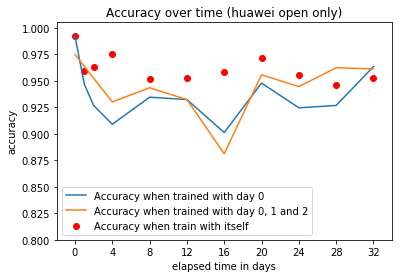

In [903]:
cumul_acc_avg_mix = np.array(cumul_acc_mix).reshape((-1,repeat)).mean(axis = 1)
self_acc_avg_mix = np.array(self_acc_mix).reshape((-1,repeat)).mean(axis = 1)
cumul_acc_avg = np.array(cumul_acc).reshape((-1,repeat)).mean(axis = 1)
self_acc_avg = np.array(self_acc).reshape((-1,repeat)).mean(axis = 1)

steps = [0, 4, 8, 12, 16, 20, 24, 28, 32]
steps_all = [0, 1, 2, 4, 8, 12, 16, 20, 24, 28, 32]
plt.plot(steps_all, cumul_acc_avg, label="Accuracy when trained with day 0")
plt.plot(steps, cumul_acc_avg_mix, label="Accuracy when trained with day 0, 1 and 2")
plt.scatter(steps_all, self_acc_avg, color="r", label="Accuracy when train with itself")
plt.ylim([0.8, 1.005])
plt.xticks(steps)
plt.ylabel("accuracy")
plt.xlabel("elapsed time in days")
plt.legend(loc="lower left")
plt.title("Accuracy over time (huawei open only)")
plt.savefig("Accuracy_over_time_08to1_all_bis4", dpi= 80)


In [ ]:

pd.read_csv(sep='\t')